In [5]:
# Import packages
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import cv2 as cv
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt
import skimage.measure

In [15]:
# Check data
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'
data_file = 'Fig3_ver01_221025_data119.cathodic.dF.dFF'
# 'Fig3_ver01_221025_data119.cathodic.dF.dFF'  # 10K
# 'Fig3_ver05_221114_data099.cathodic.dF,dFF' # 100K
# 'Fig3_ver05_221114_data101.anodic.dF,dFF' # 150K
# 'Fig3_ver05_221114_data239.cathodic.dF,dFF' # 50K
# 'Fig3_ver05_221114_data240.anodic.dF,dFF' # 60K
# 'Fig3_ver07_221123_data099data119.ImgSig' # W/o subtraction of darkframe values
# 'Fig3_ver08_221212_data211data213_picture,dF,dFF' # 15K 10K

data_dir = os.path.join(os.path.join(base_dir, 'data'), 'Fig3')
data_path = os.path.join(data_dir, data_file)
fig_dir = os.path.join(os.path.join(base_dir, 'figures'), 'Fig3')

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

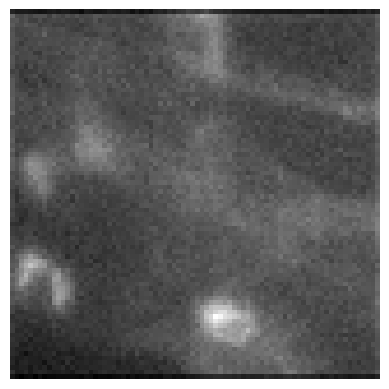

In [16]:
# Check the background image
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    data_type = 'data119'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'
    low_thres, high_thres = 1.5*1e4, 2.5*1e4
elif data_file == 'Fig3_ver05_221114_data099.cathodic.dF,dFF':
    data_type = 'data099'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data101.anodic.dF,dFF':
    data_type = 'data101'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data101.anodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data239.cathodic.dF,dFF':
    data_type = 'data239'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data239.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data240.anodic.dF,dFF':
    data_type = 'data240'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data240.anodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver07_221123_data099data119.ImgSig':
    data_type = 'data099' # 'data119'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
    # background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    data_type = 'data213' #  'data211' or 'data213'
    background_path = test['data213_anodic_picture'] # test['data211_cathodic_picture'] or test['data213_anodic_picture']
    low_thres, high_thres = 4.5*1e6, 6.25*1e6

if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    kernel_dim = 3
else:
    kernel_dim = 6

os.makedirs(os.path.join(fig_dir, f'Frames_{data_type}'), exist_ok=True)
os.makedirs(os.path.join(fig_dir, f'Results_{data_type}'), exist_ok=True)

if data_file != 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    img_data = []
    with open(background_path) as file:
        for (i, line) in enumerate(file):
            row_data = np.expand_dims(np.array(line.split(',')[:-1]).astype('float64'), axis=0)
            if i == 0:
                img_data = row_data
            else:
                img_data = np.concatenate([img_data, row_data], axis=0)
else:
    img_data = background_path

plt.imshow(img_data, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [18]:
# Print out shapes, min and max values
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    dF_var = 'data119_cathodic_dF'
    dFF_var = 'data119_cathodic_dFF'
elif data_file == 'Fig3_ver07_221123_data099data119.ImgSig':
    dF_var = 'data099_ImagSig'
    dFF_var = 'data119_ImgSig'
elif data_file == 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    dF_var = 'data213_anodic_dF' #'data211_cathodic_dF' # 'data213_anodic_dF'
    dFF_var = 'data213_anodic_dFF' #'data211_cathodic_dFF' # 'data213_anodic_dFF'
else:
    dF_var = 'dF'
    dFF_var = 'dFF'

print(test[dF_var].shape)
print(test[dF_var].min())
print(test[dF_var].max())

print(test[dFF_var].shape)
print(test[dFF_var].min())
print(test[dFF_var].max())

# The F0 value will be somewhere between these two below values.
print(test[dF_var].max() / test[dFF_var].min())
print(test[dF_var].min() / test[dFF_var].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112
51.063157894736705
30693.14285714294


In [19]:
# Cut off the front frames

front_frame_num = 900
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    orig_data = test[dF_var][:, :, front_frame_num:-100]
else:
    orig_data = test[dF_var][:, :, front_frame_num:]

print(orig_data.shape)
print(orig_data.min())
print(orig_data.max())

(80, 80, 4000)
-246.79999999999995
-16.799999999999955


In [20]:
# Temporal processing

## Low-pass filtering (10 hz)
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    sos = butter(5, [10], btype='low', output='sos', fs=1000.)

    temp_data = np.zeros(orig_data.shape)
    for x_coord in range(orig_data.shape[0]):
        for y_coord in range(orig_data.shape[1]):
            filt_data = sosfilt(sos, orig_data[x_coord, y_coord, :])
            temp_data[x_coord, y_coord, :] = filt_data
else:
    temp_data = orig_data
temp_data = orig_data

print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 4000)
-246.79999999999995
-16.799999999999955


In [21]:
# Spatial processing

## Movie scaling
space_data1_temp = np.swapaxes(temp_data, 0, -1)
space_data1 = (space_data1_temp - space_data1_temp.min(axis=0)) / (space_data1_temp.max(axis=0) - space_data1_temp.min(axis=0))
space_data1 *= 255

## Low-pass filtering (kernel x kernel mean)
iter_num = 3
kernel = np.ones((kernel_dim, kernel_dim)) 
space_data2 = np.zeros(space_data1.shape)
for frame_num in range(space_data2.shape[0]):
    space_data2[frame_num, :, :] = ndimage.convolve(space_data1[frame_num, :, :], kernel)
    for i in range(iter_num - 1):
        space_data2[frame_num, :, :] = ndimage.convolve(space_data2[frame_num, :, :], kernel)

## Subtracting the reference frame
space_data3 = np.zeros(space_data2.shape)

# # Exponential subtraction
# for x_coord in tqdm(range(space_data2.shape[1])):
#     for y_coord in range(space_data2.shape[-1]):
#         space_data3[:, x_coord, y_coord] = space_data2[:, x_coord, y_coord] - np.flip(np.repeat(np.exp(range(10, 15)), space_data2.shape[0] / 5))

for frame_num in range(space_data3.shape[0]):
    space_data3[frame_num, :, :] =  space_data2[frame_num, :, :] - space_data2[0, :, :]

print(space_data1.shape)
print(space_data1.min())
print(space_data1.max())
print(space_data2.shape)
print(space_data2.min())
print(space_data2.max())
print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

(4000, 80, 80)
0.0
255.0
(4000, 80, 80)
33770.64369789535
136134.10596641235
(4000, 80, 80)
-71712.88880818593
49420.720067922666


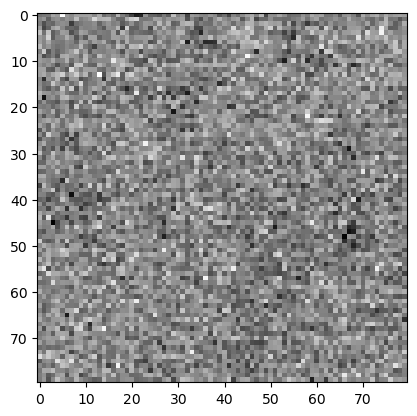

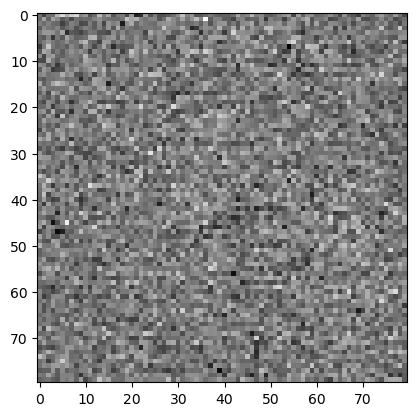

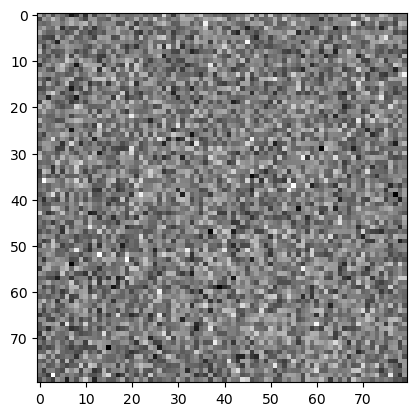

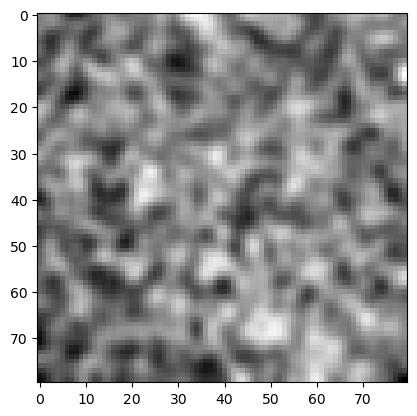

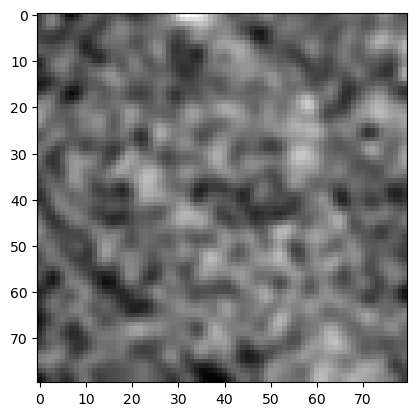

In [22]:
# Visualize one frame for full processing steps
frame_num = 1500 # 1447 or frame_num

plt.imshow(test[dF_var][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

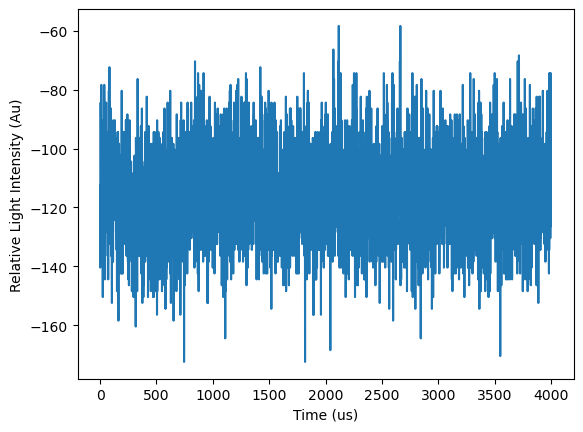

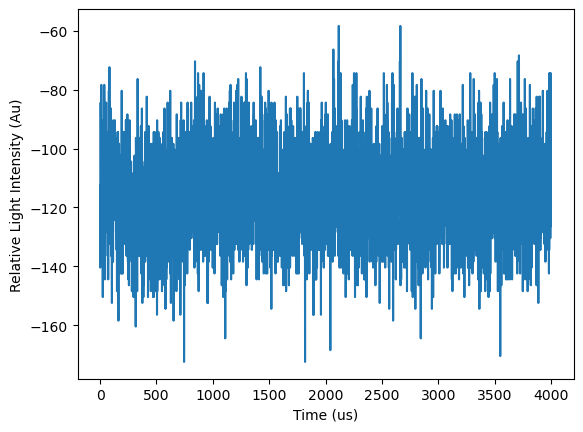

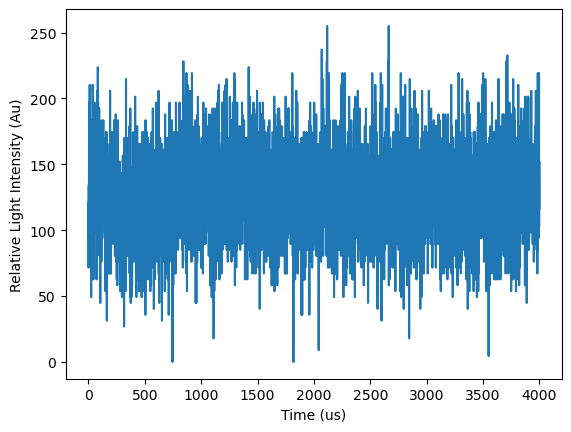

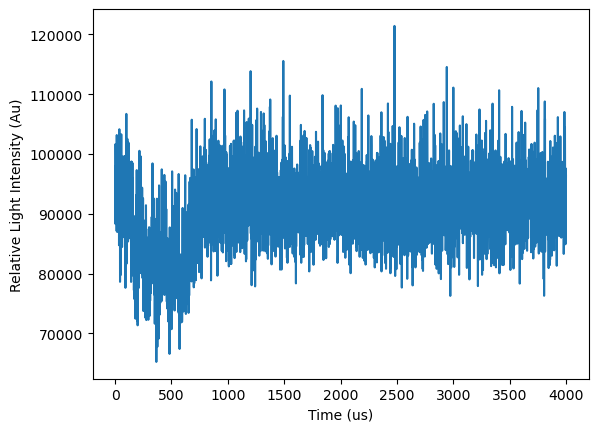

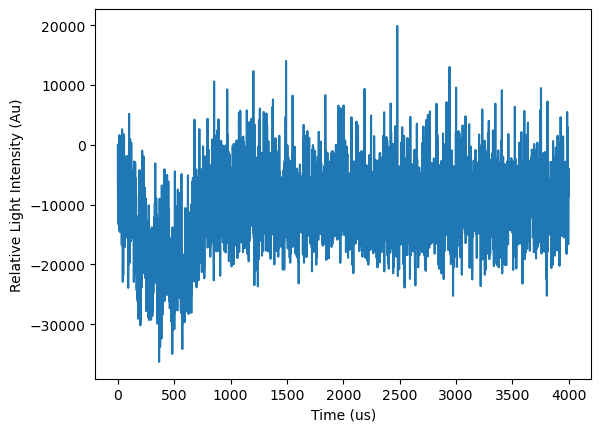

In [25]:
x_coord, y_coord = 10, 10 # 65, 45 # 10, 10 

plt.plot(range(orig_data.shape[-1]), orig_data[x_coord, y_coord, :])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(temp_data.shape[-1]), temp_data[x_coord, y_coord, :])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data1.shape[0]), space_data1[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data2.shape[0]), space_data2[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data3.shape[0]), space_data3[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

- Generate a discrete colored mask

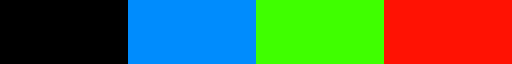

In [27]:
colors = ['#000000', '#008cfd', '#3FFF00', '#ff1203']
color_lst = [np.array((0, 0, 0)), np.array((0, 140, 253)), np.array((63, 255, 0)), np.array((255, 18, 3))]

matplotlib.colors.ListedColormap(colors)

Baseline: average whole pixels

In [28]:
mask = np.zeros(space_data3.shape)
colored_mask = np.zeros((mask.shape[0], 3, mask.shape[2], mask.shape[-1]))

max = space_data3[:, :, :].max()
min = space_data3[:, :, :].min()
one_interval = (max - min) / len(colors)

for x_coord in tqdm(range(space_data3.shape[1])):
    for y_coord in range(space_data3.shape[-1]):

        for frame_num in range(space_data3.shape[0]):

            signal_pnt = space_data3[frame_num, x_coord, y_coord]
            if signal_pnt == max:
                bin_pnt = len(colors)-1
            else:
                bin_pnt = (signal_pnt - min) // one_interval

            # for images
            mask[frame_num, x_coord, y_coord] = bin_pnt
            # for video clips
            colored_mask[frame_num, :, x_coord, y_coord] = color_lst[int(bin_pnt)]


unique, counts = np.unique(mask, return_counts=True)
print("Colors: ", unique, "Counts: ", counts)

100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


Colors:  [0. 1. 2. 3.] Counts:  [   20989  2693384 22588339   297288]


- Print images of separate masks

  0%|          | 20/4000 [00:01<04:37, 14.33it/s]C:\Users\Na Min An\AppData\Local\Temp\ipykernel_12200\1951926207.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
100%|██████████| 4000/4000 [05:01<00:00, 13.25it/s]


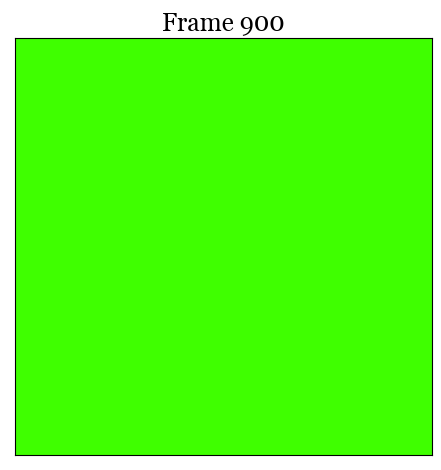

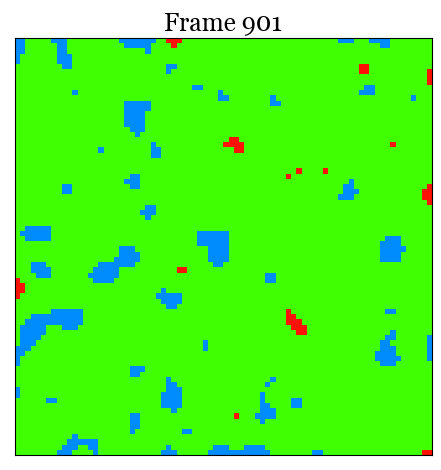

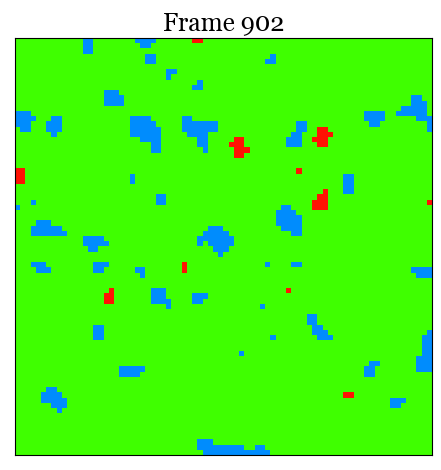

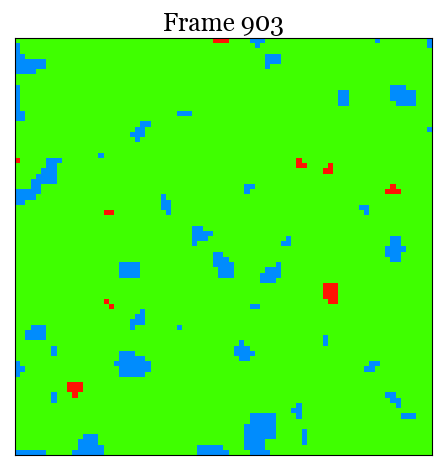

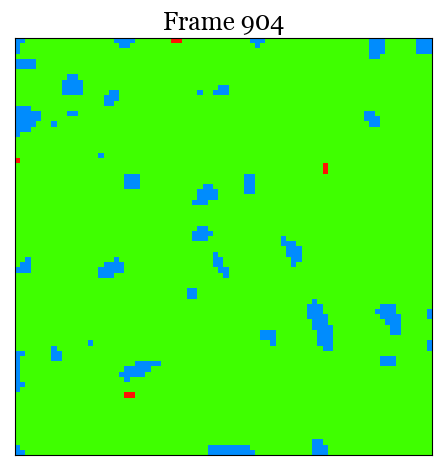

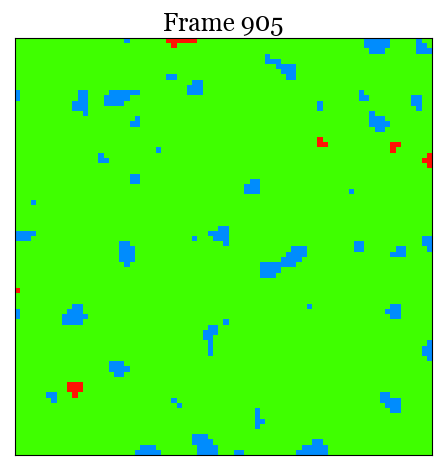

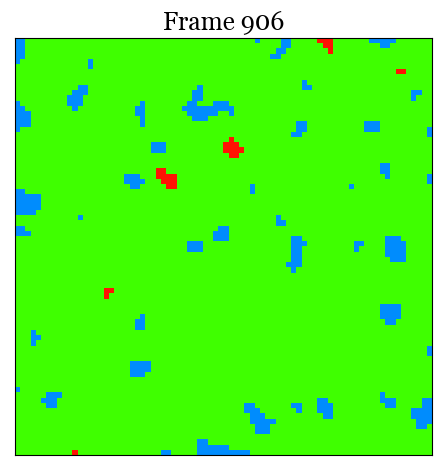

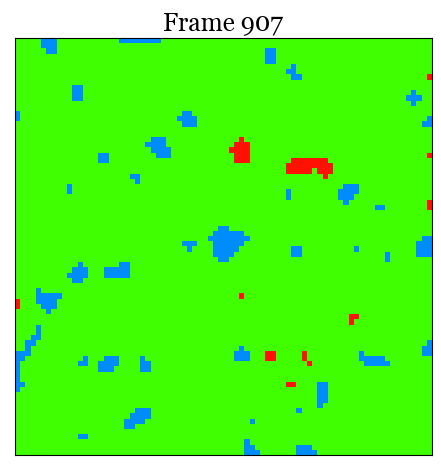

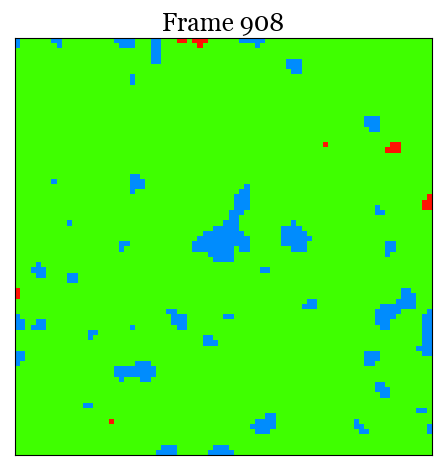

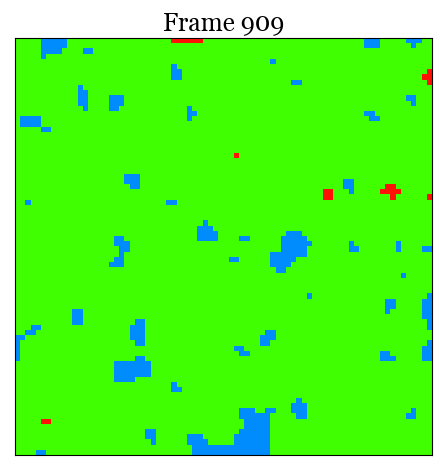

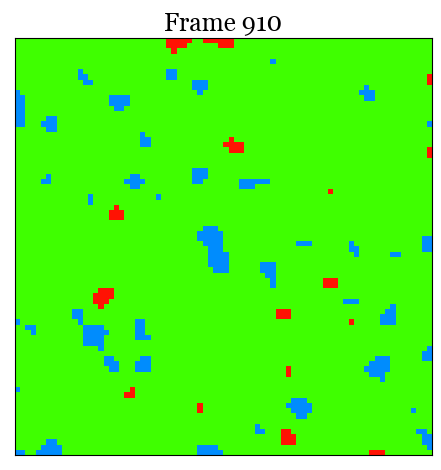

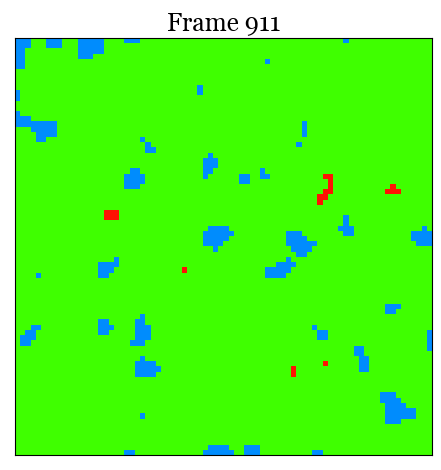

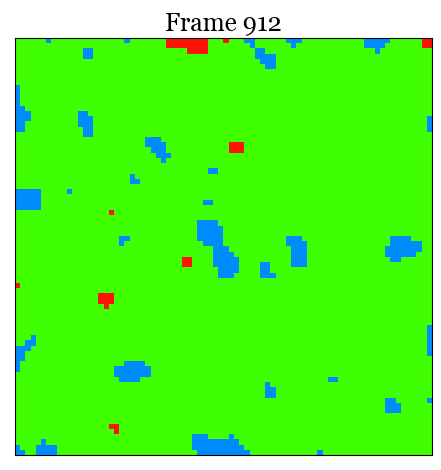

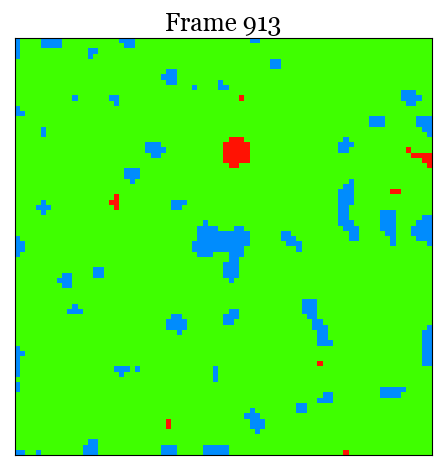

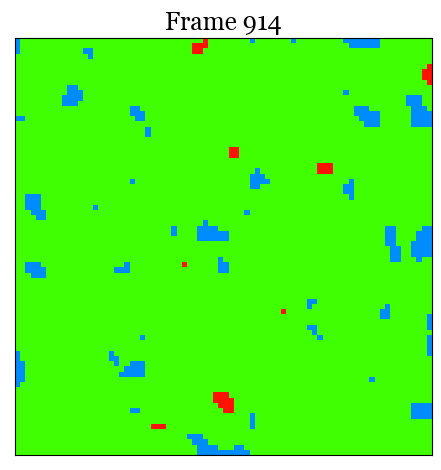

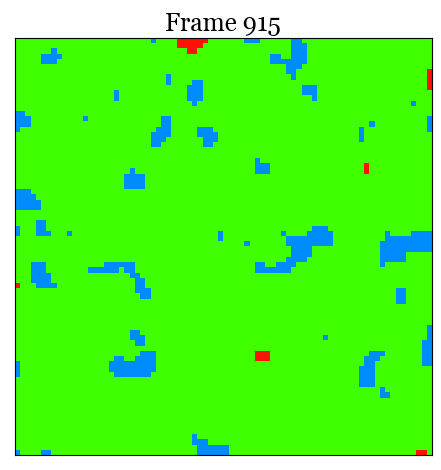

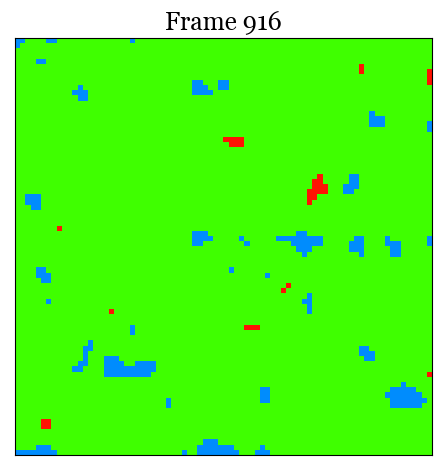

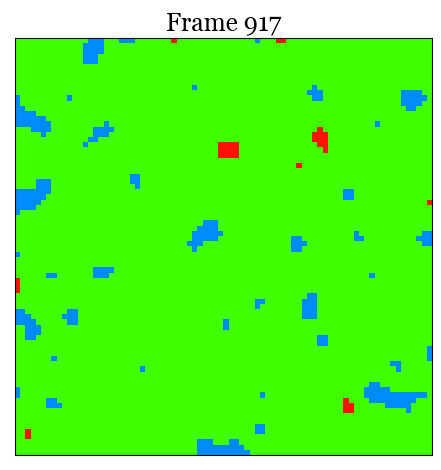

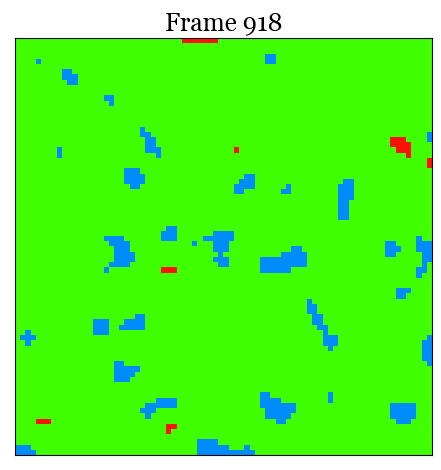

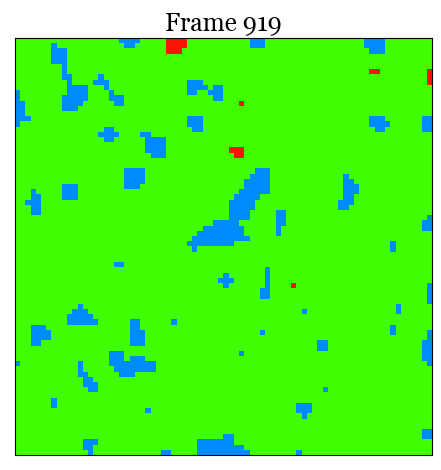

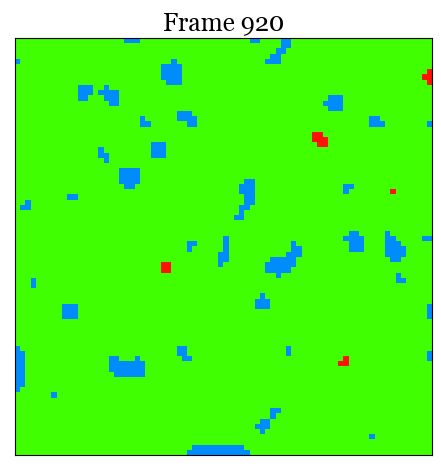

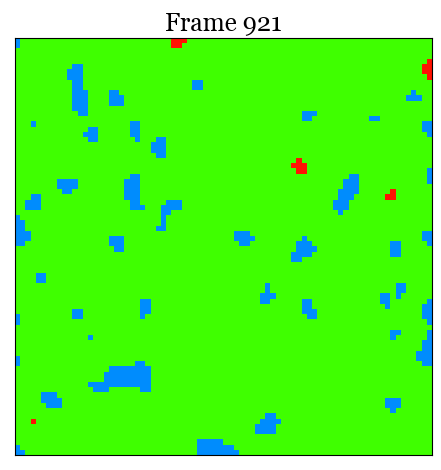

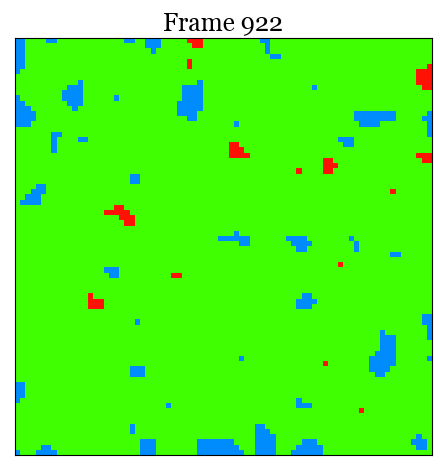

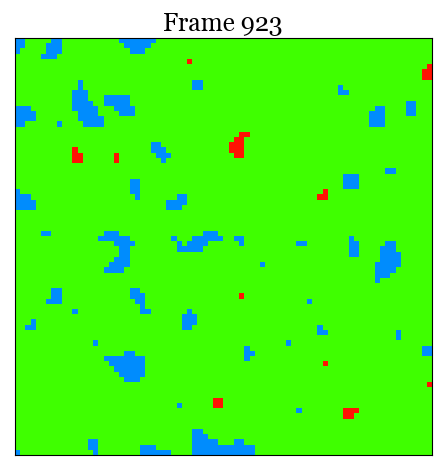

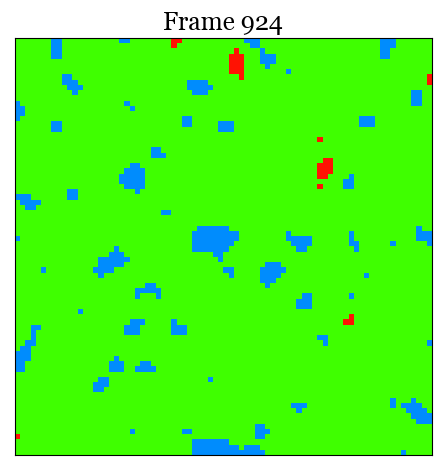

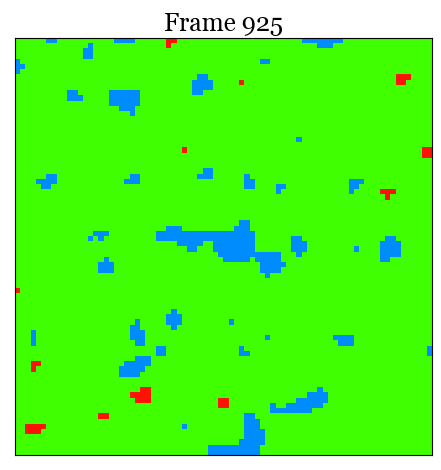

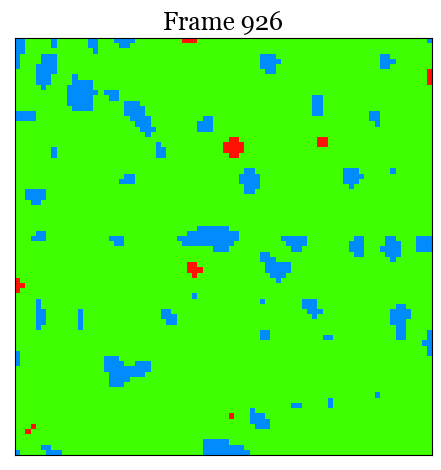

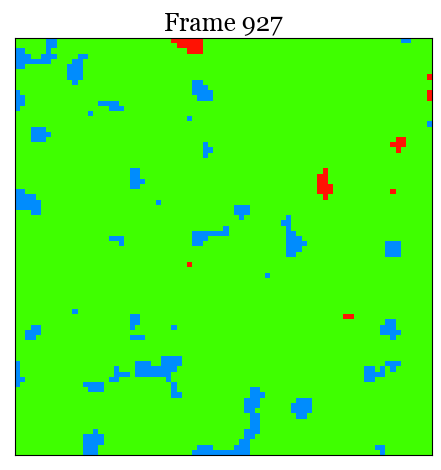

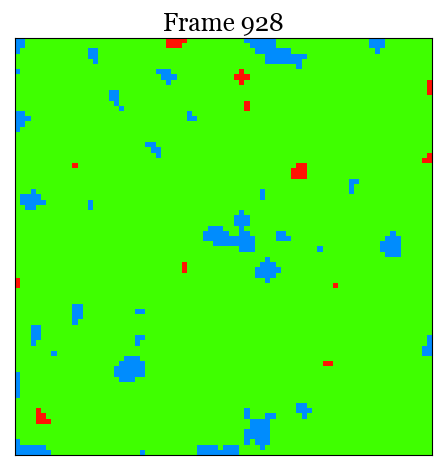

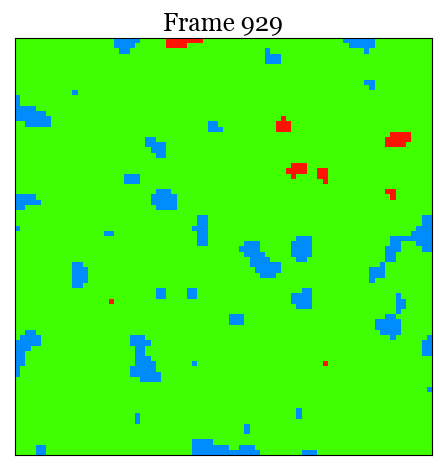

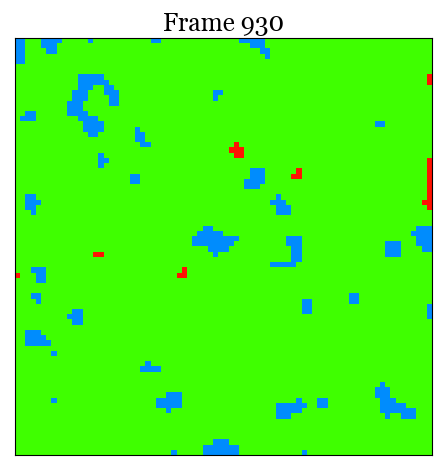

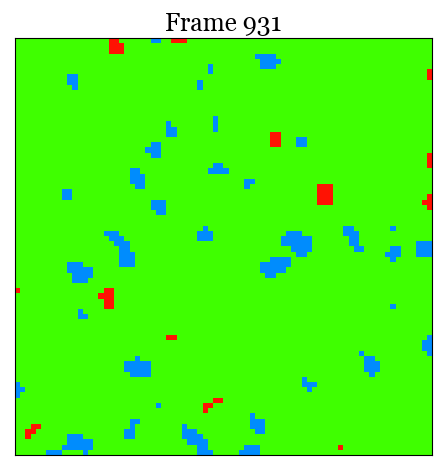

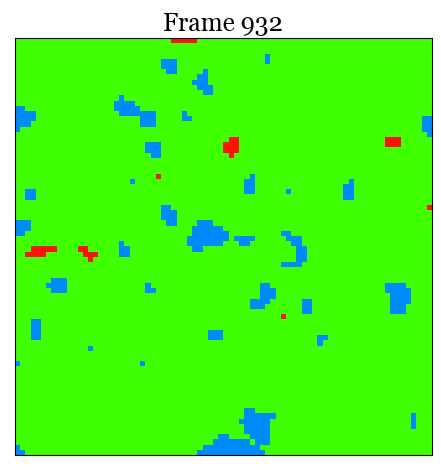

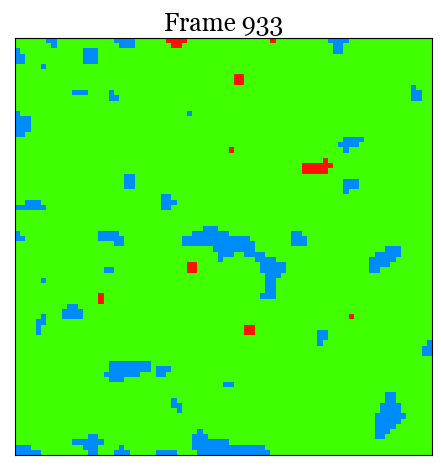

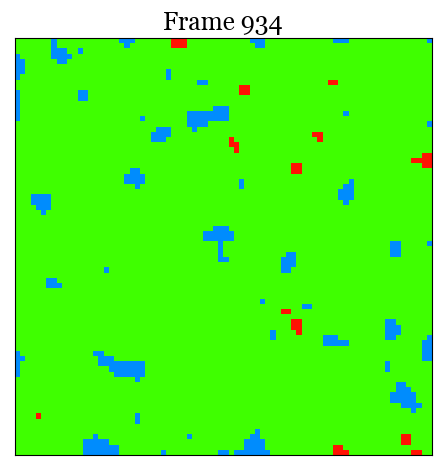

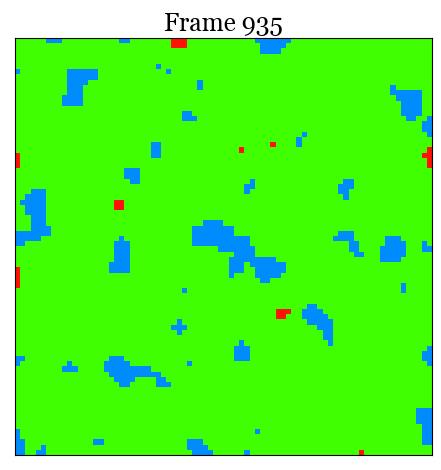

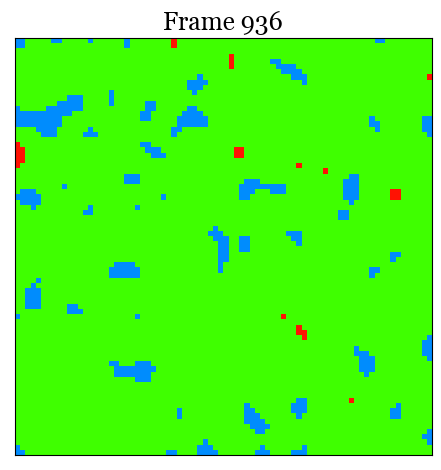

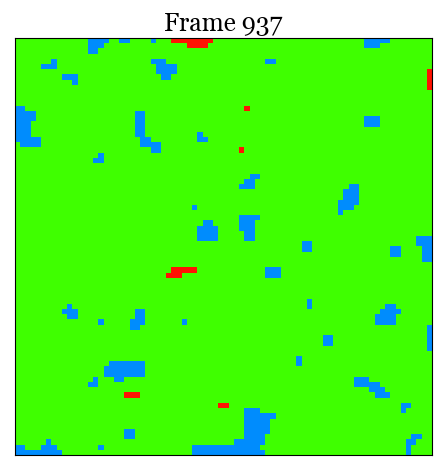

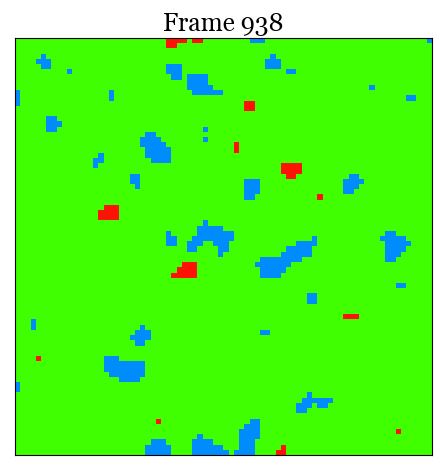

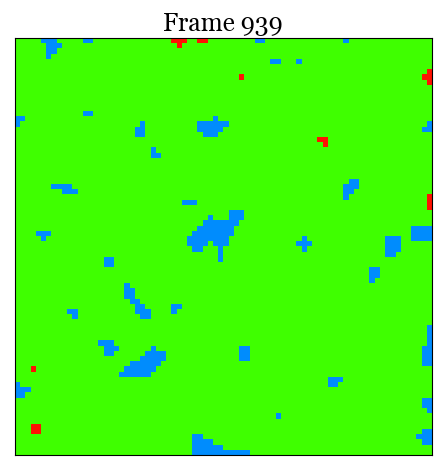

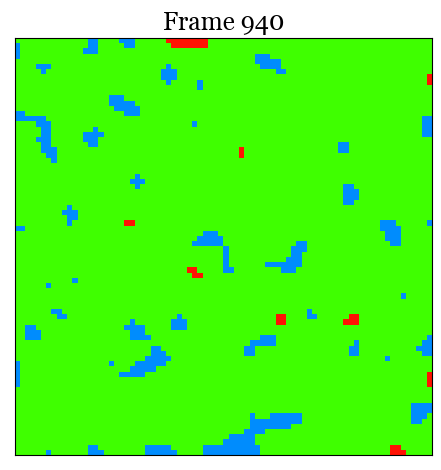

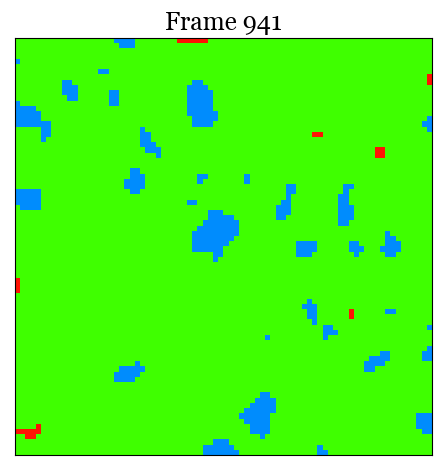

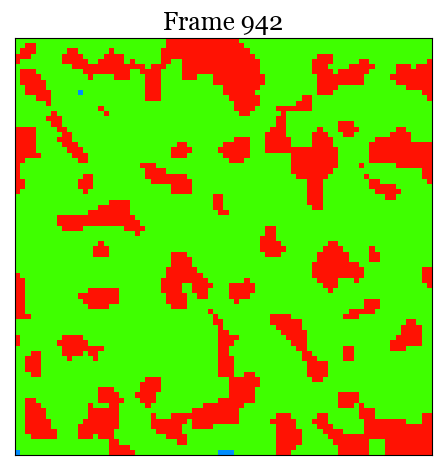

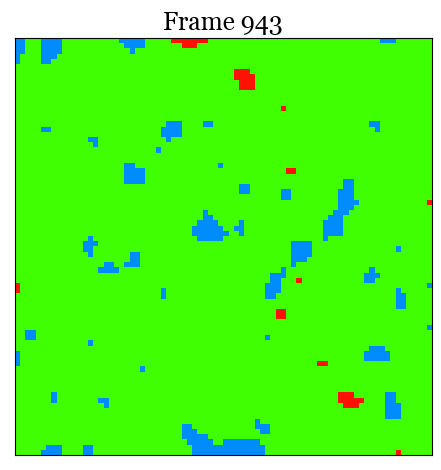

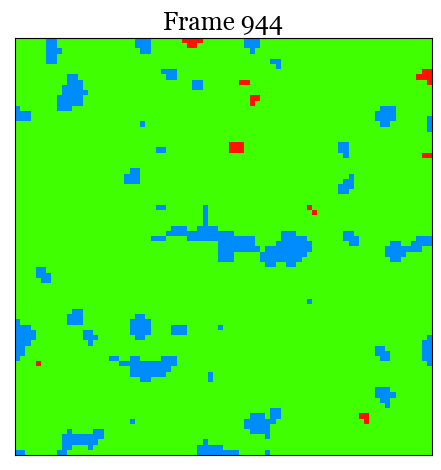

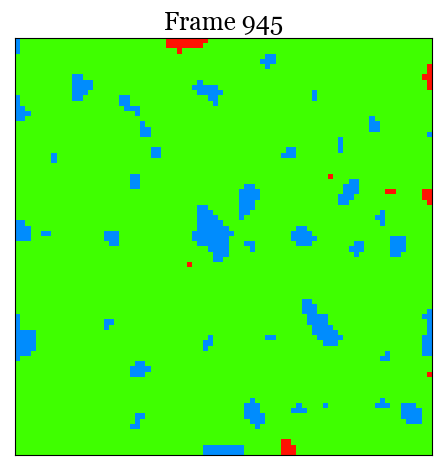

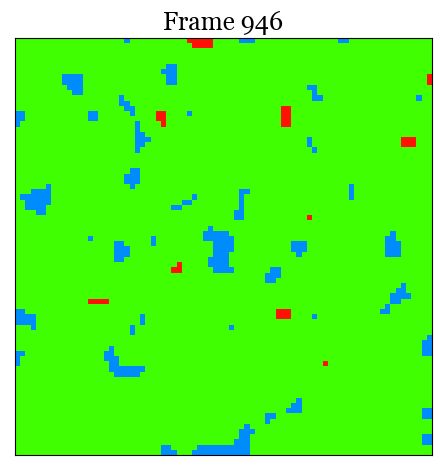

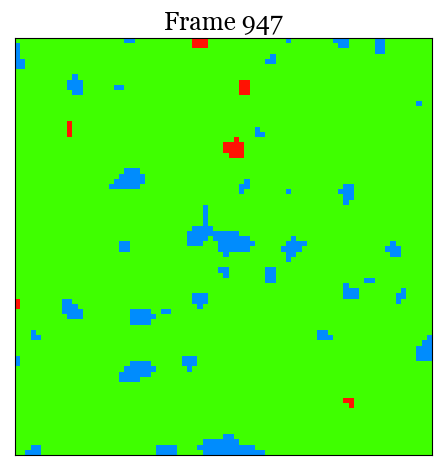

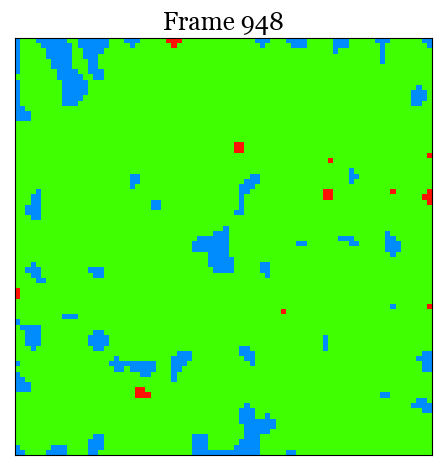

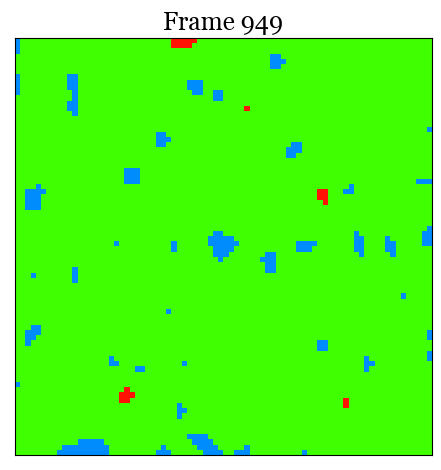

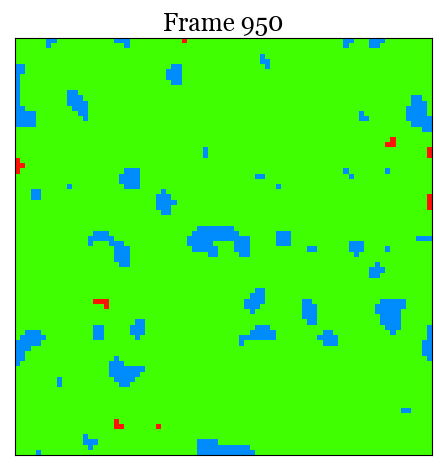

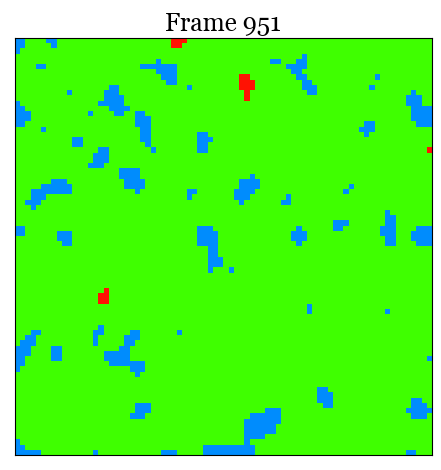

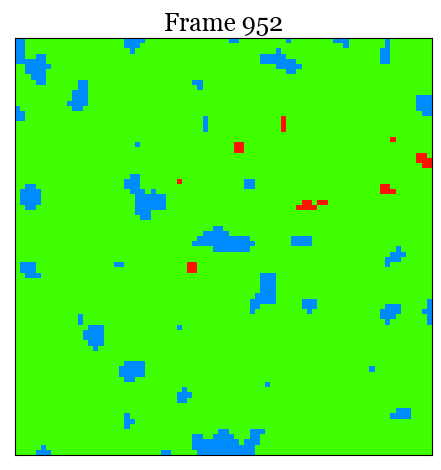

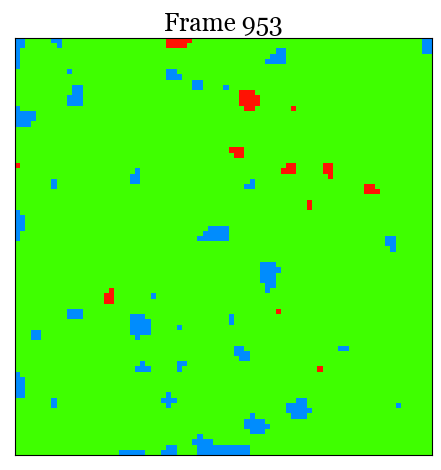

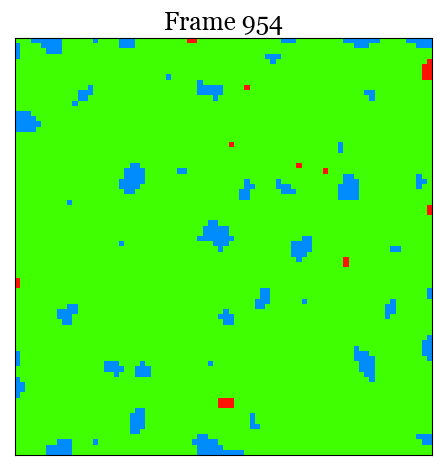

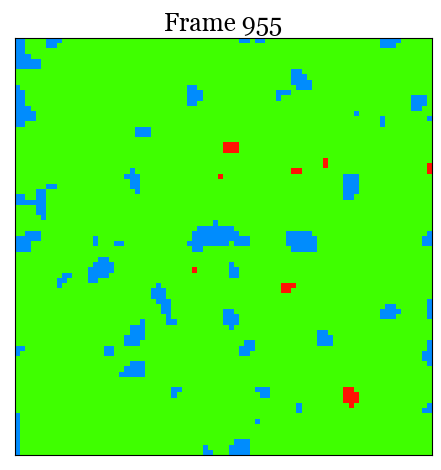

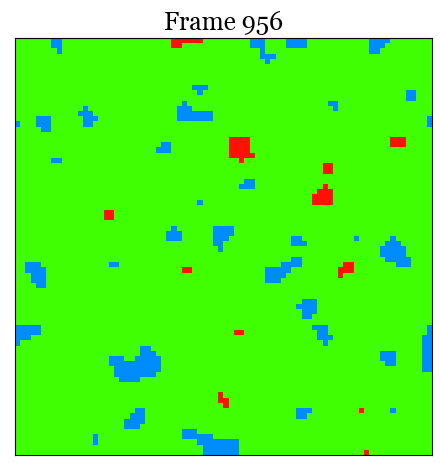

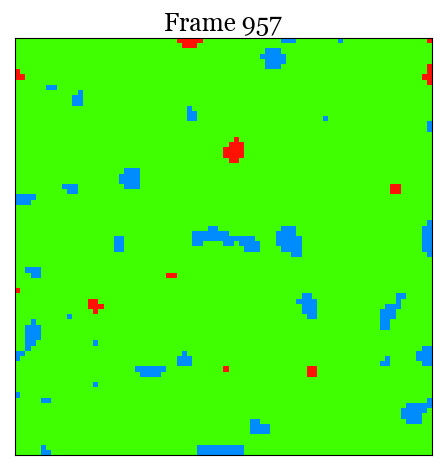

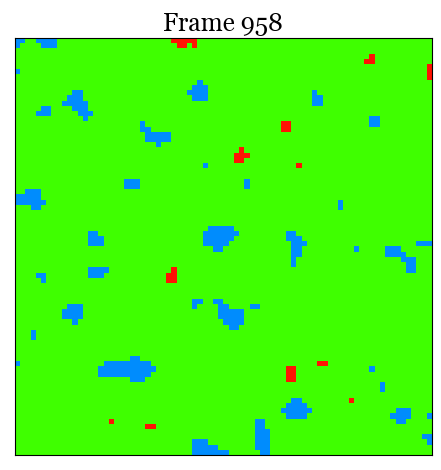

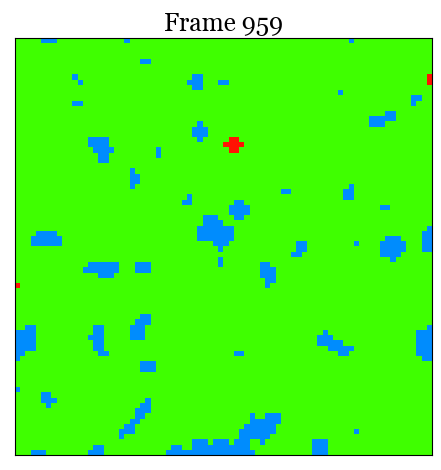

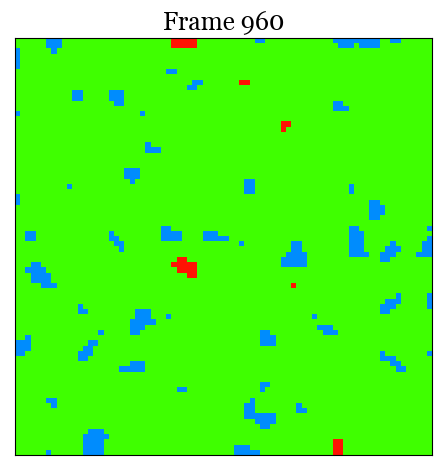

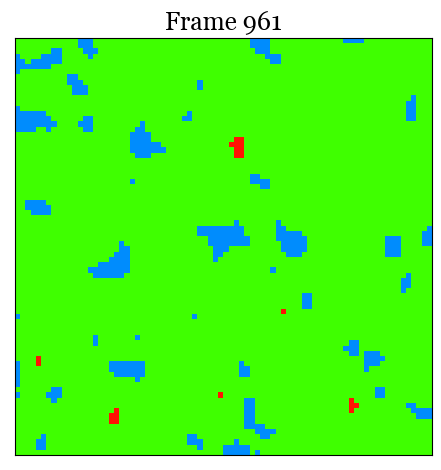

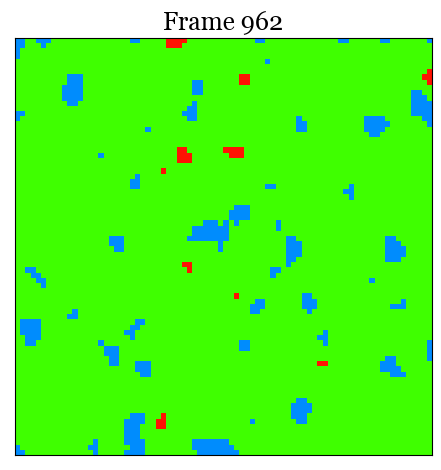

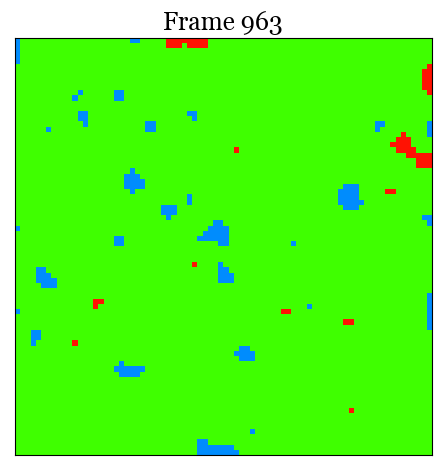

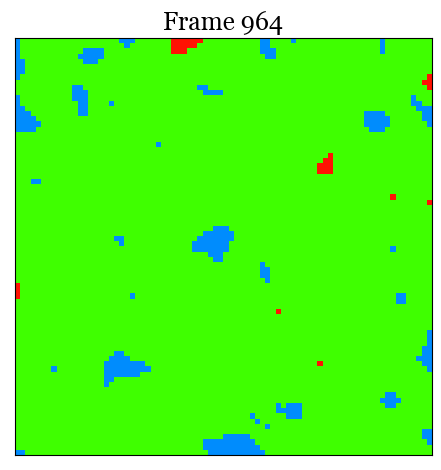

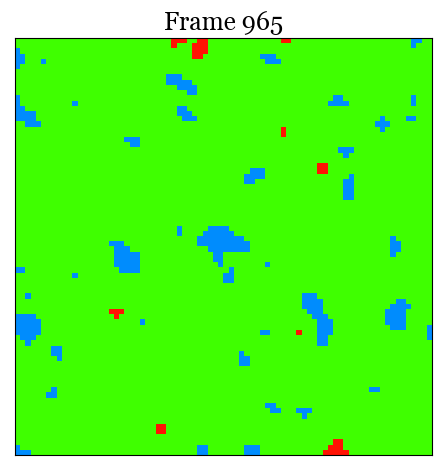

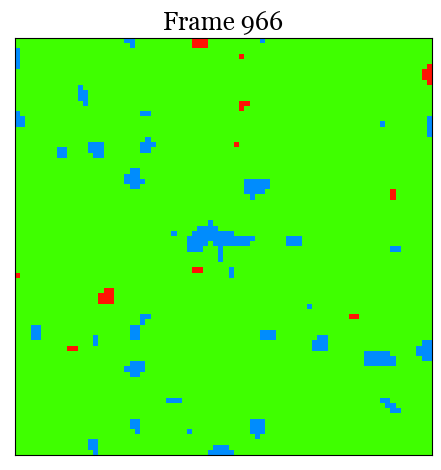

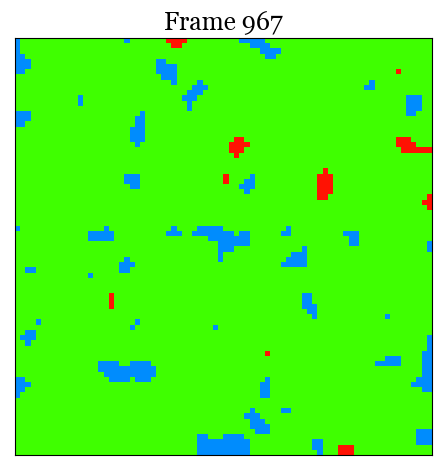

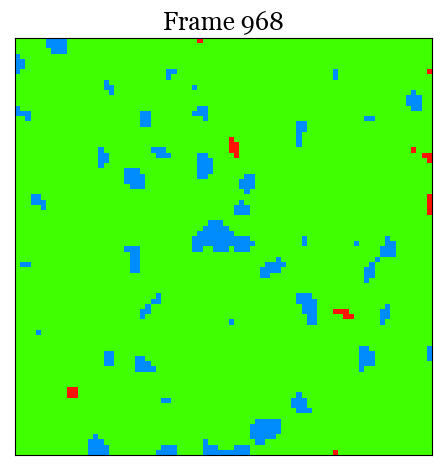

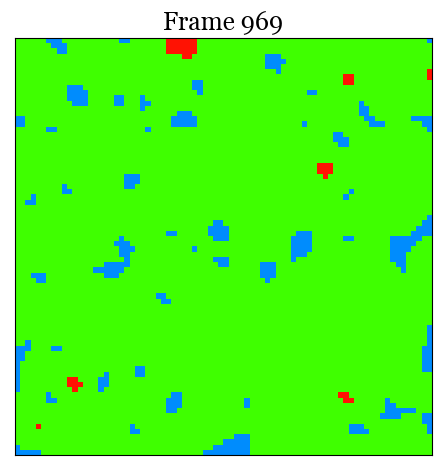

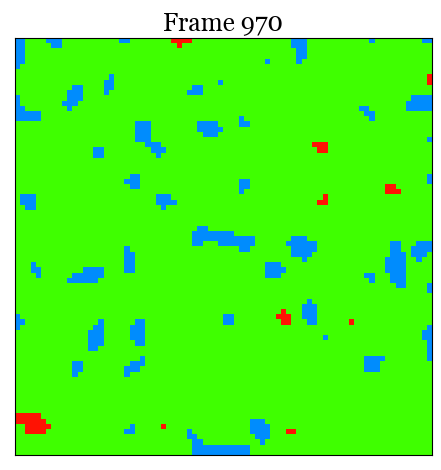

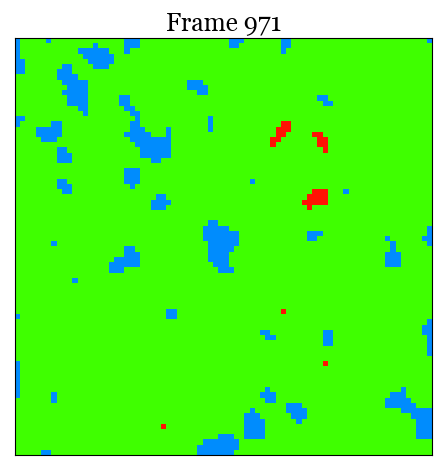

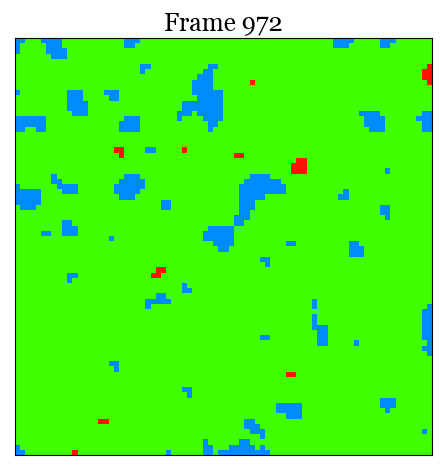

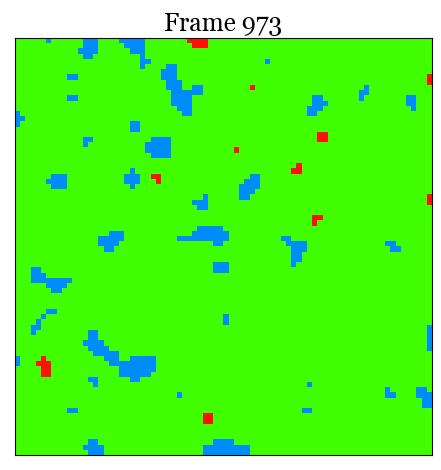

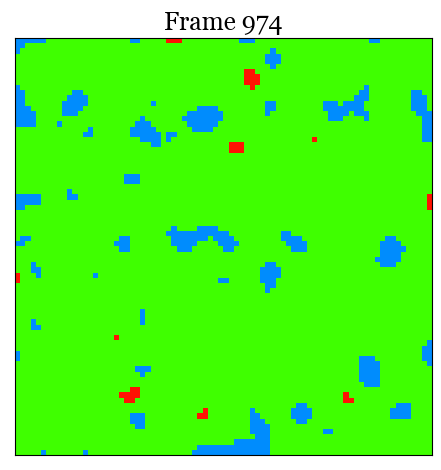

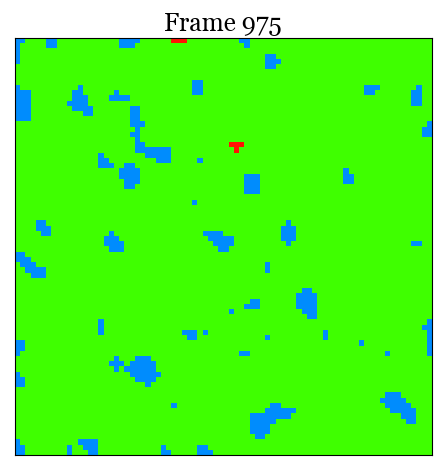

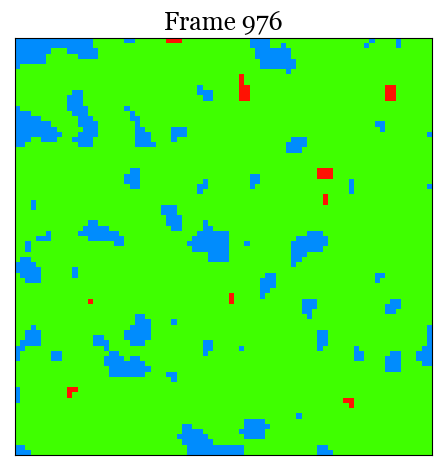

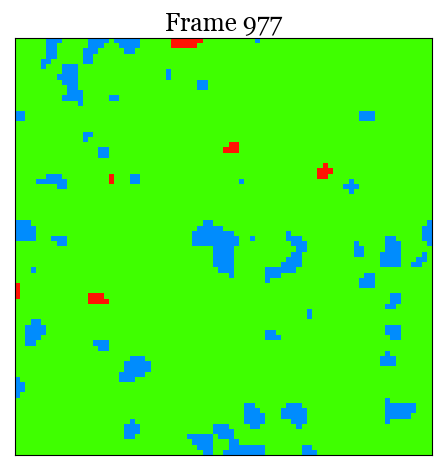

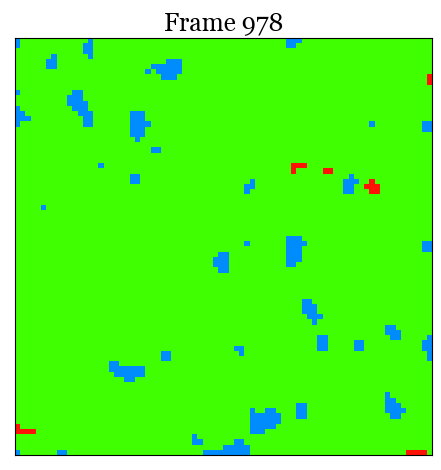

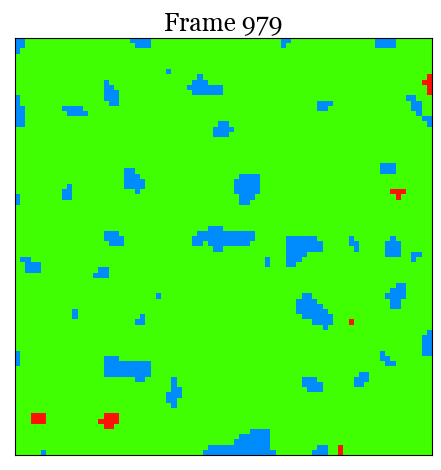

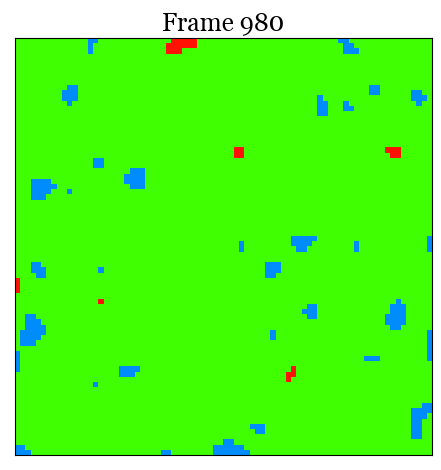

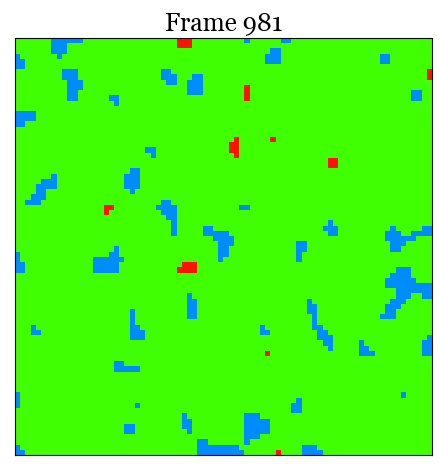

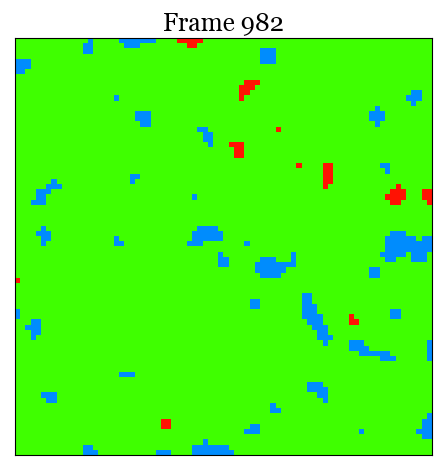

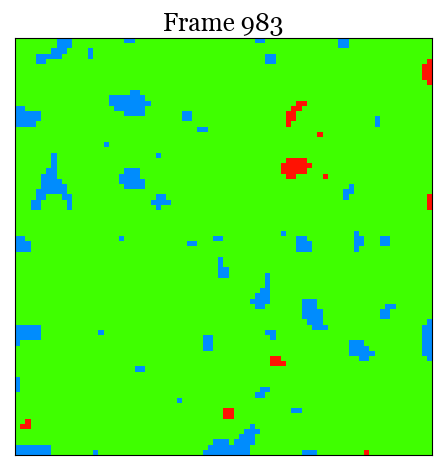

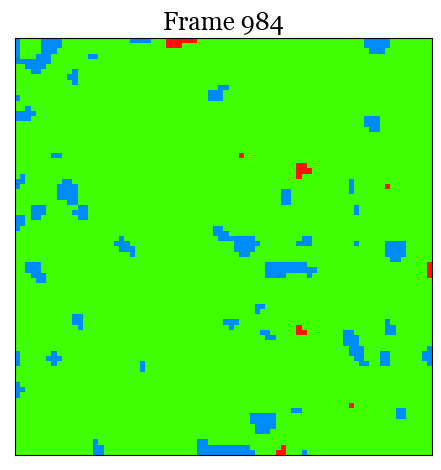

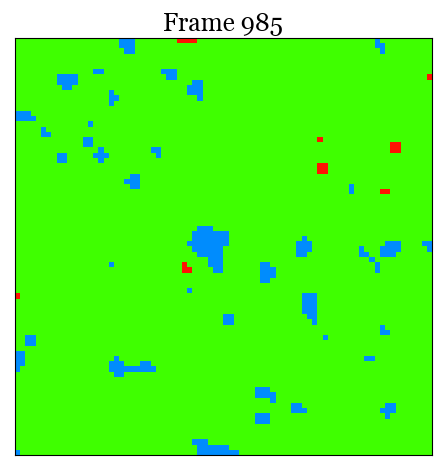

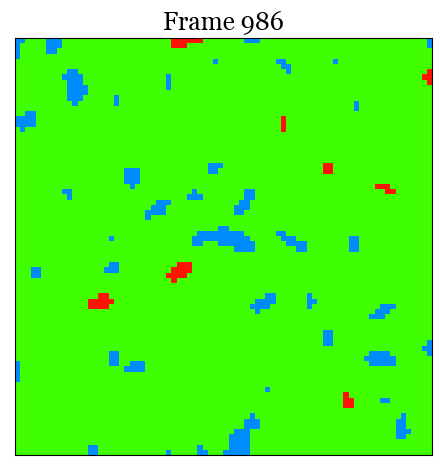

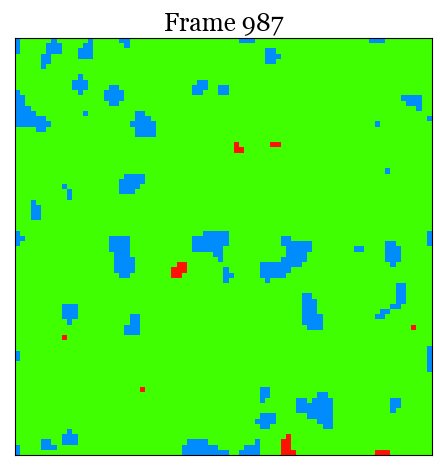

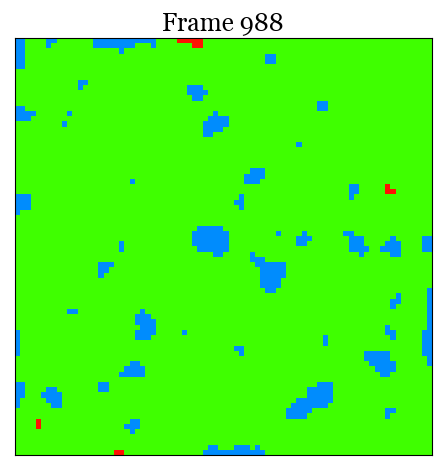

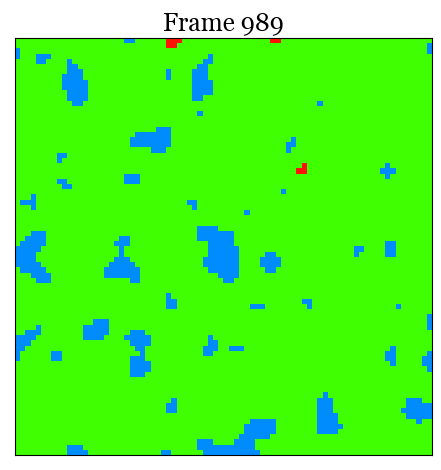

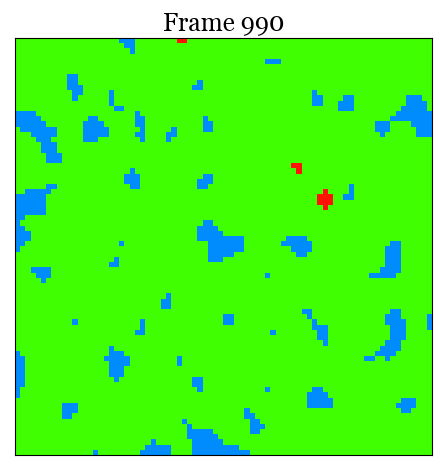

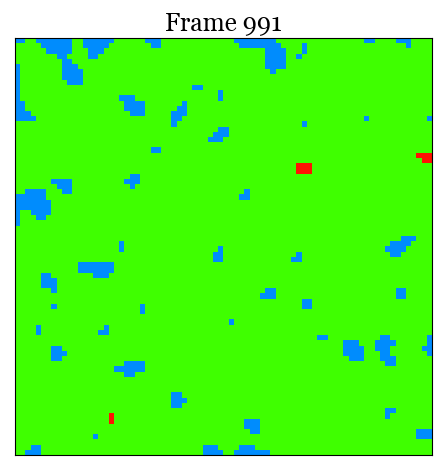

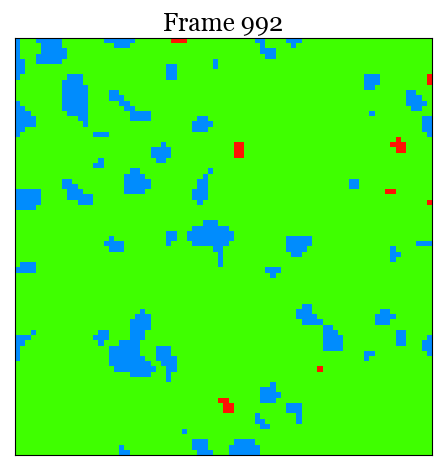

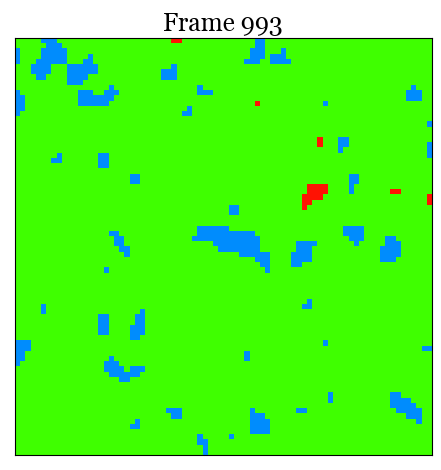

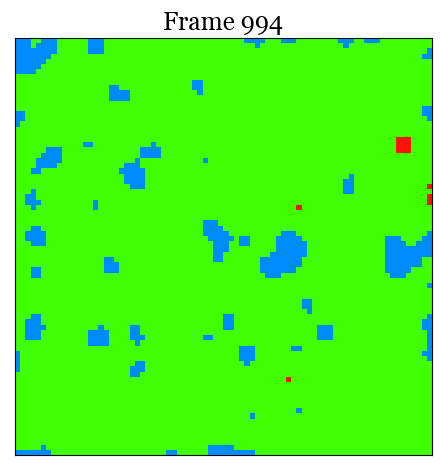

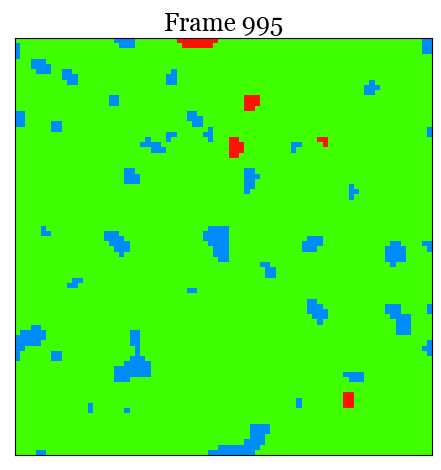

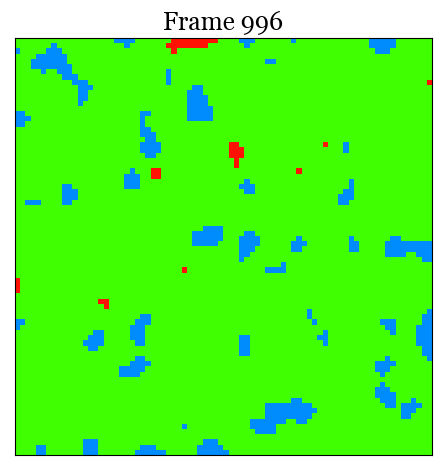

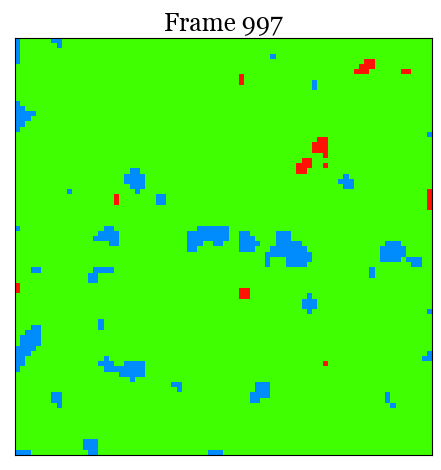

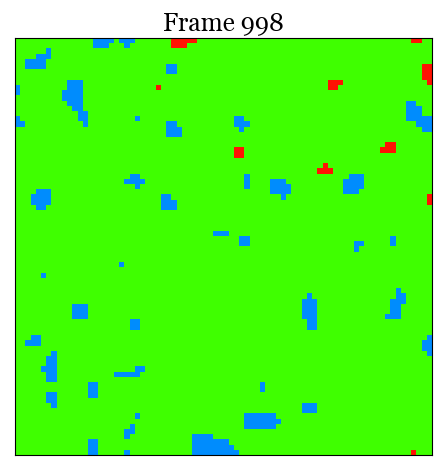

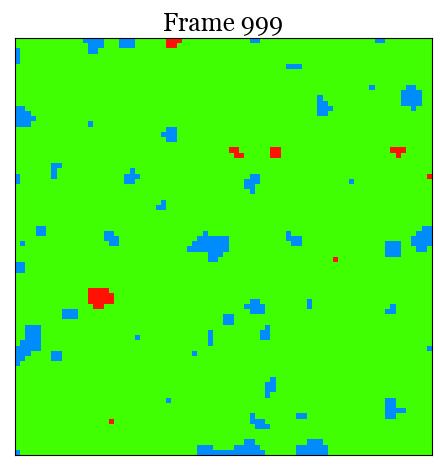

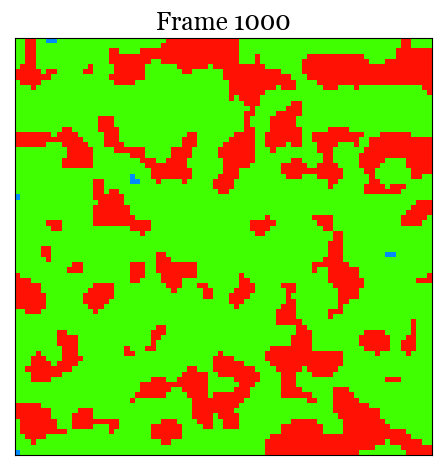

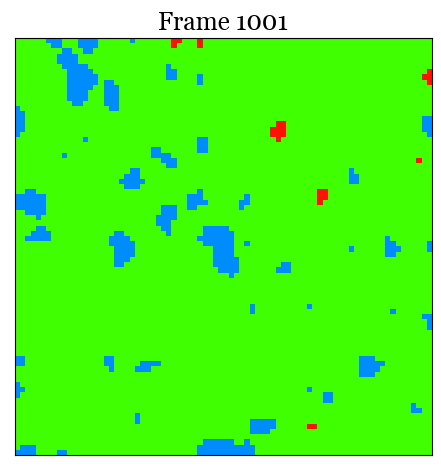

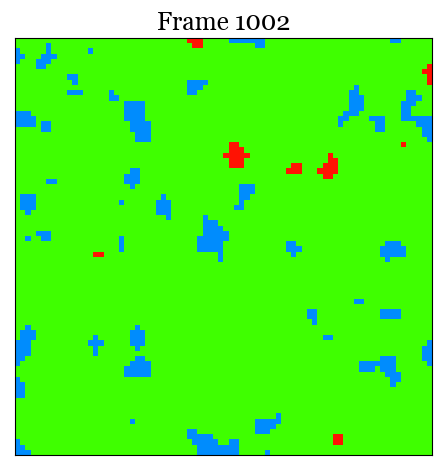

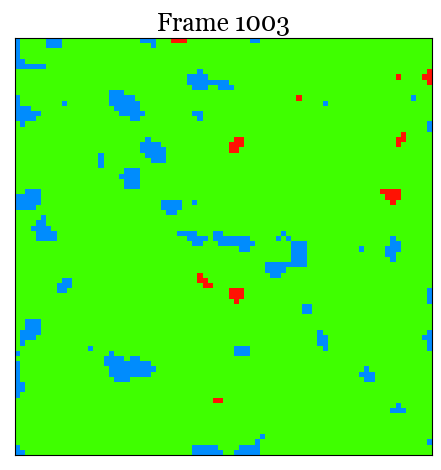

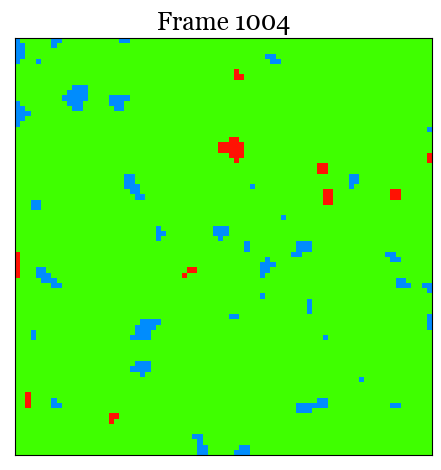

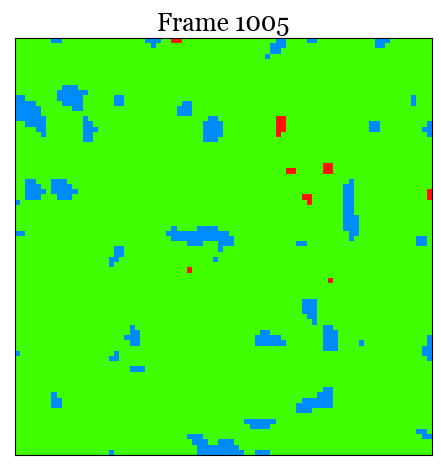

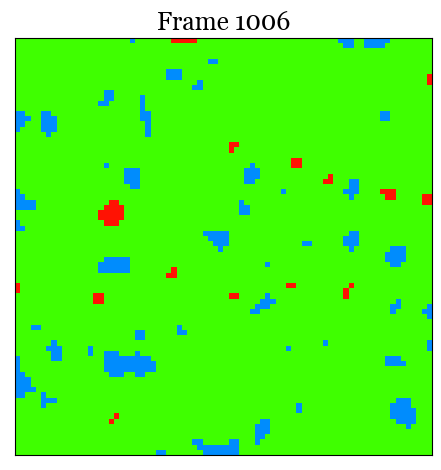

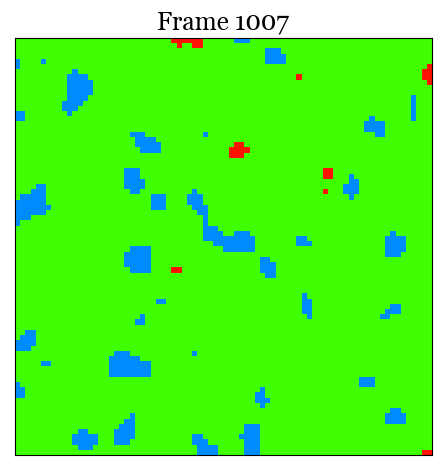

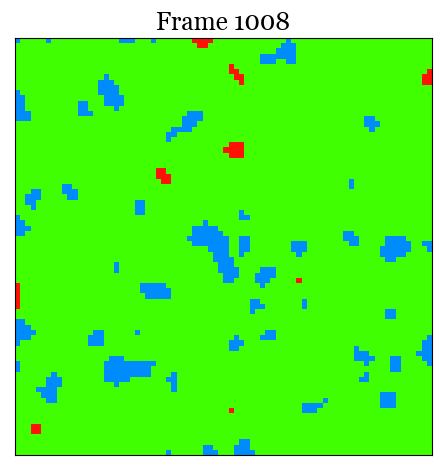

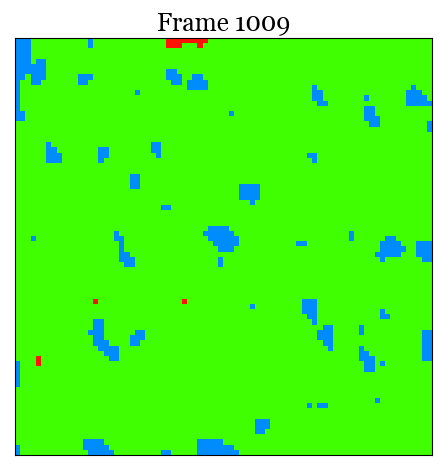

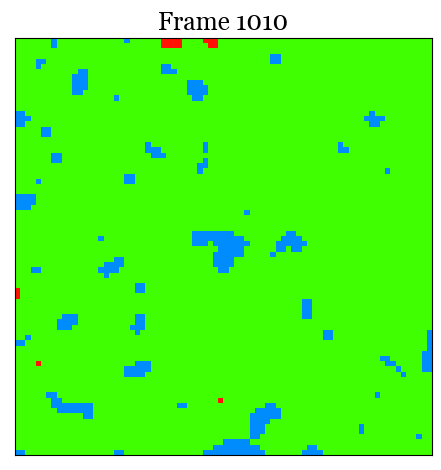

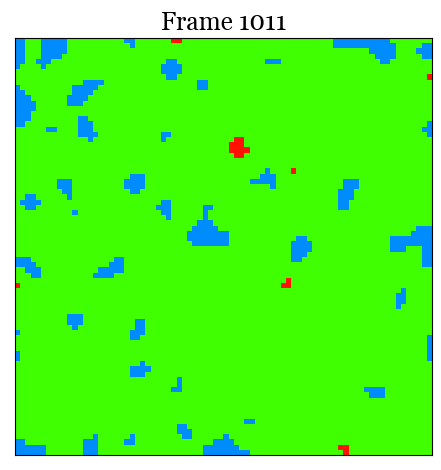

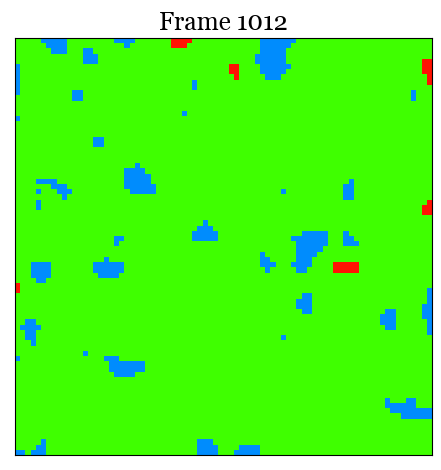

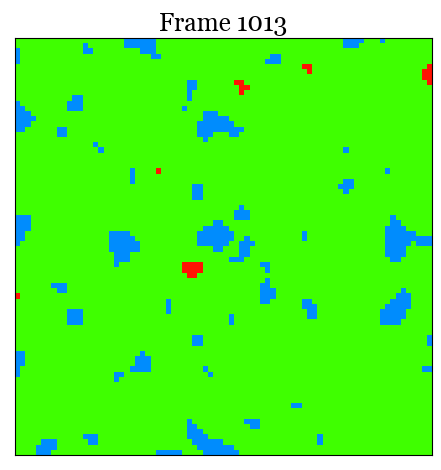

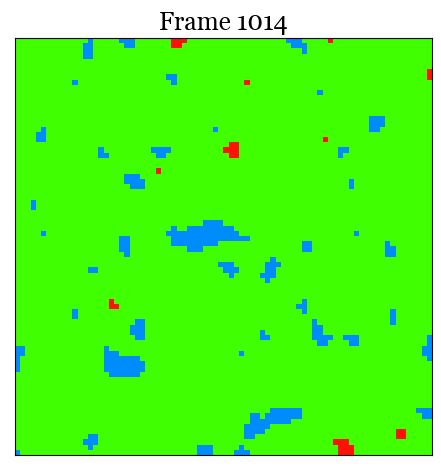

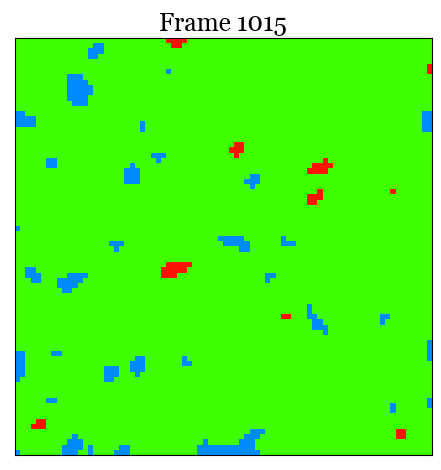

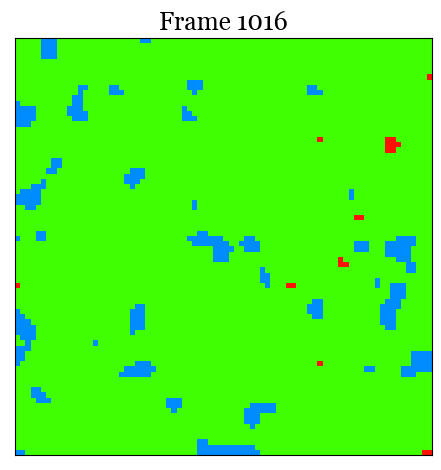

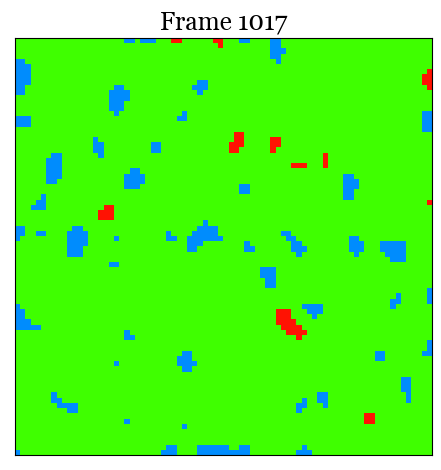

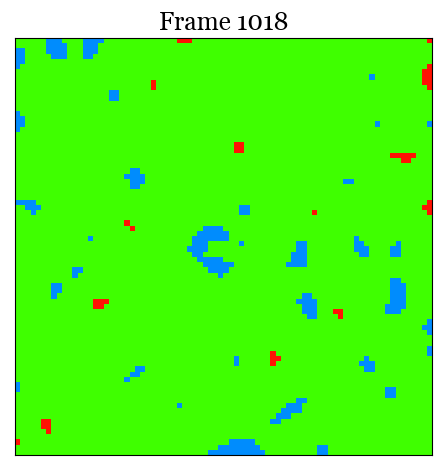

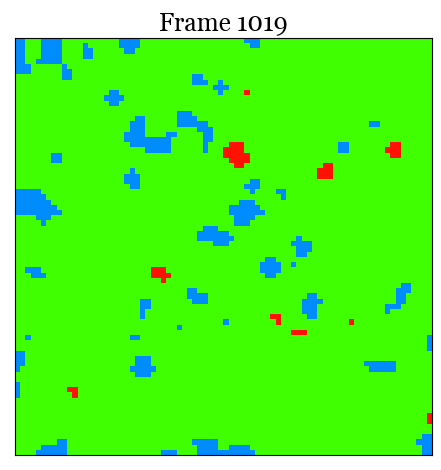

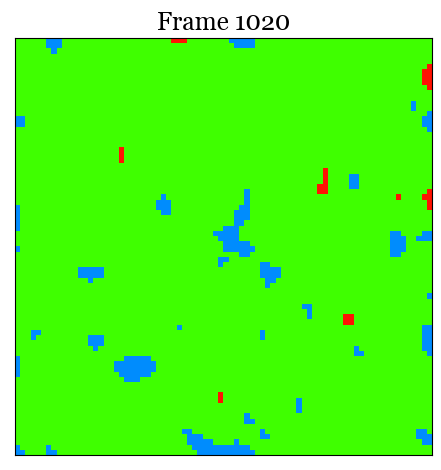

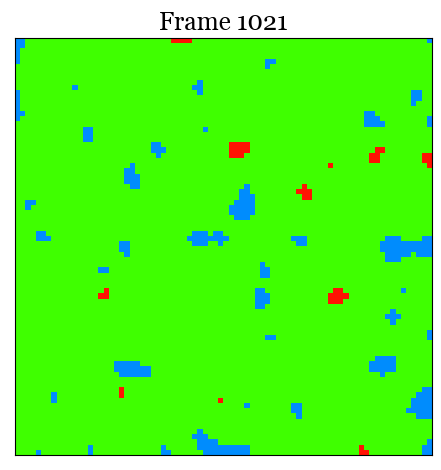

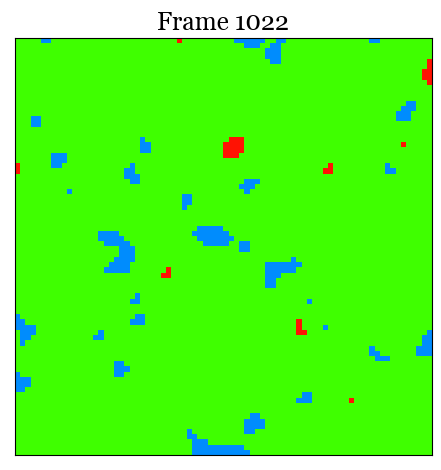

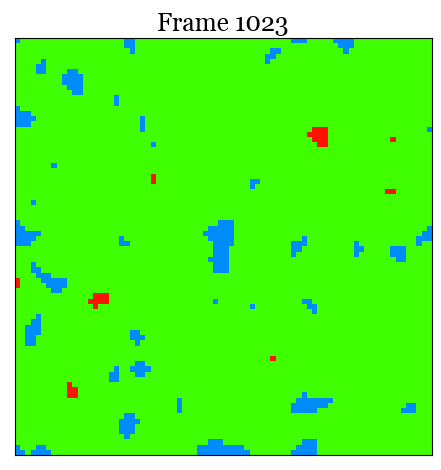

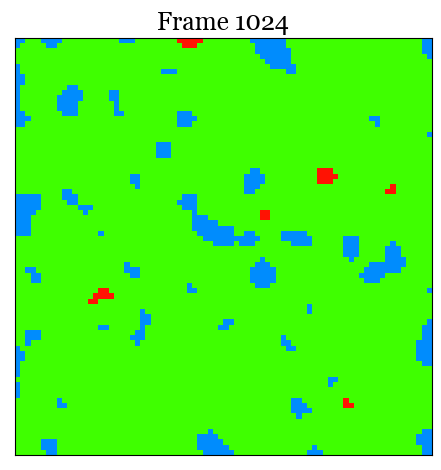

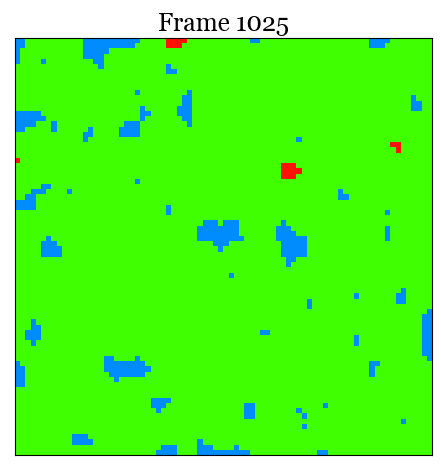

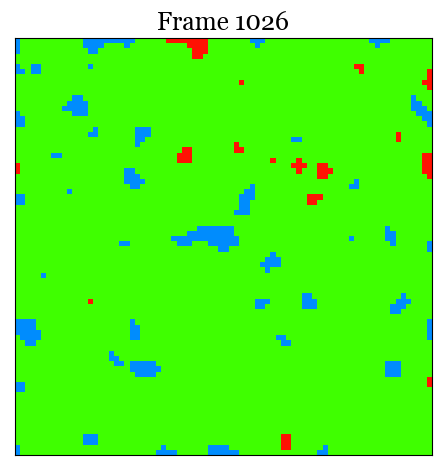

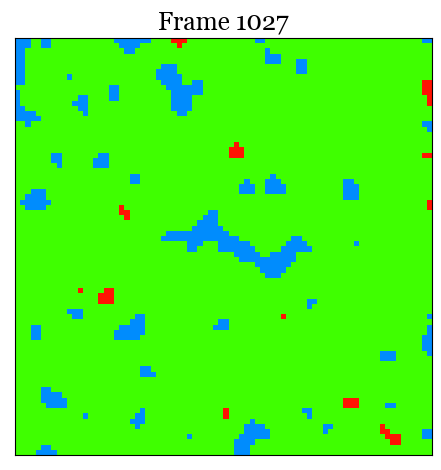

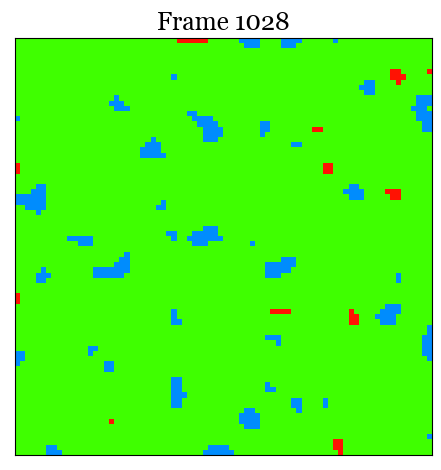

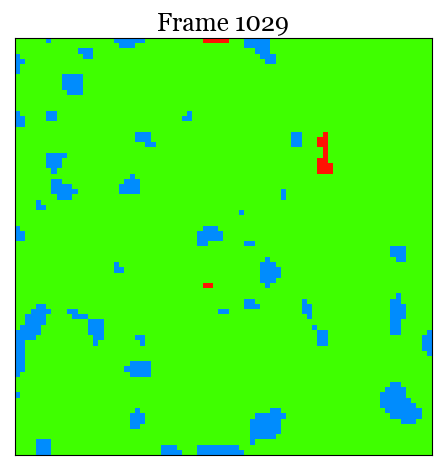

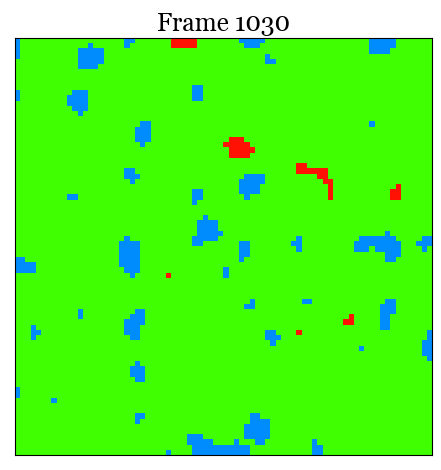

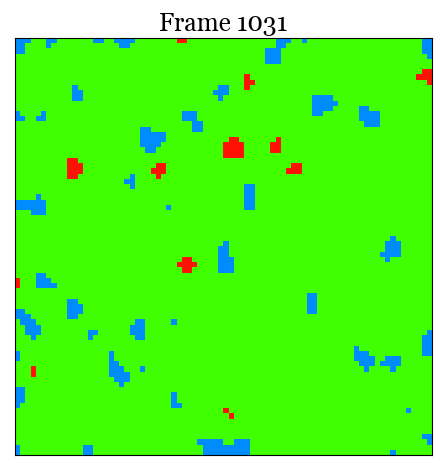

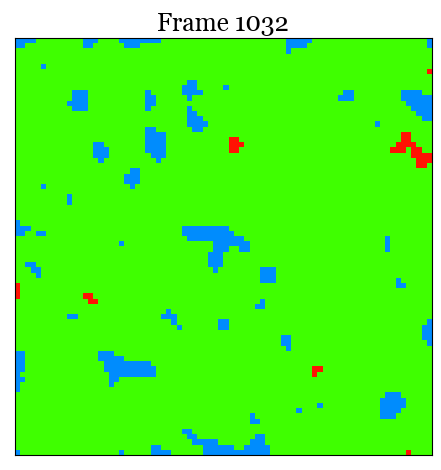

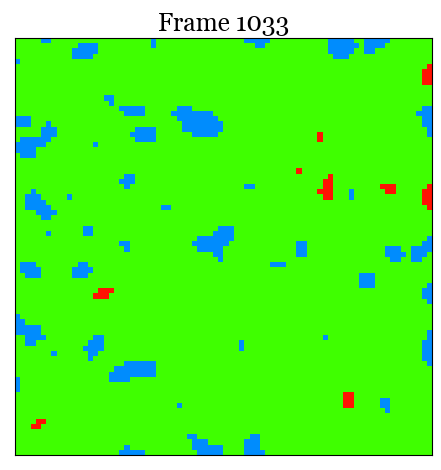

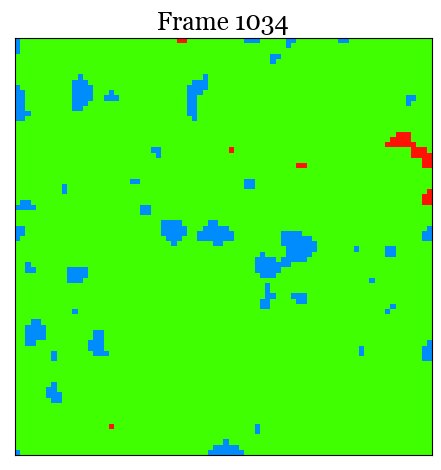

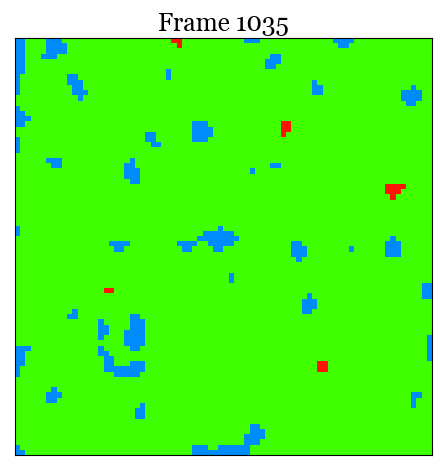

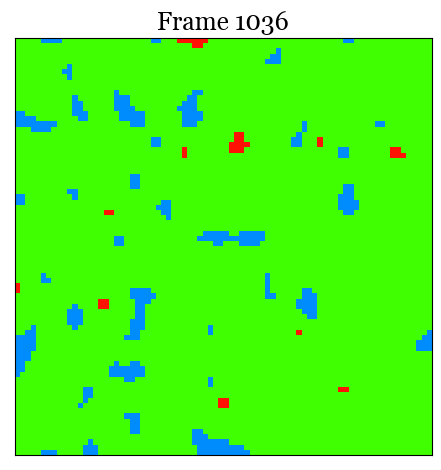

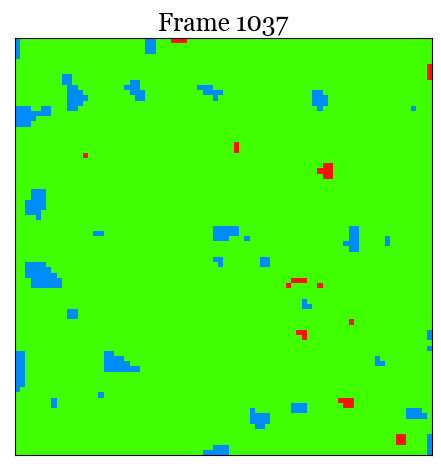

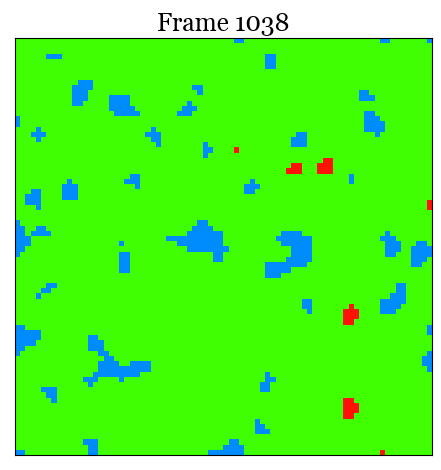

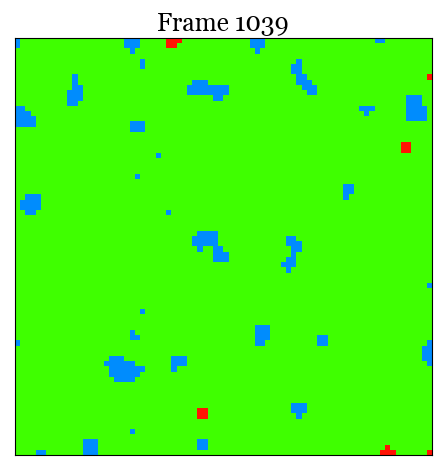

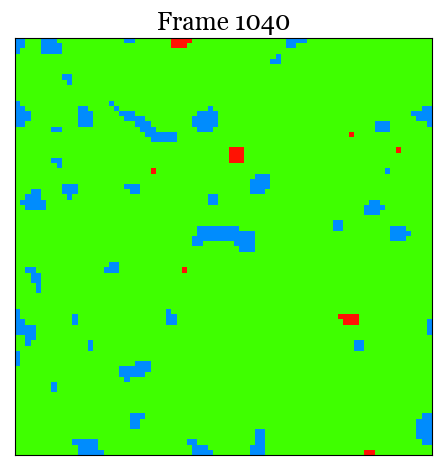

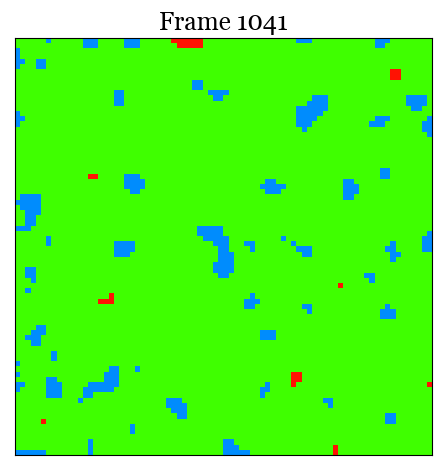

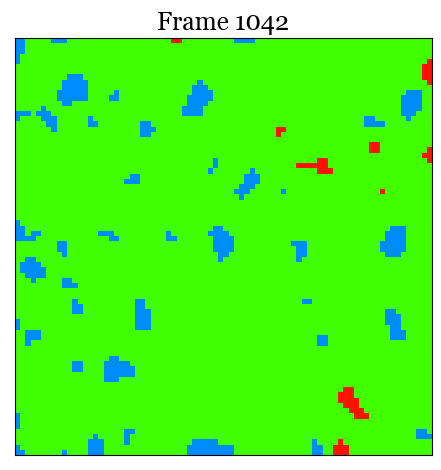

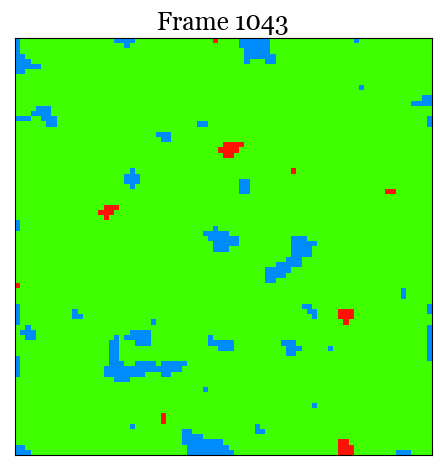

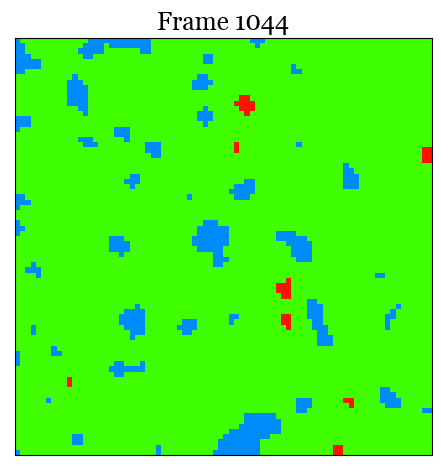

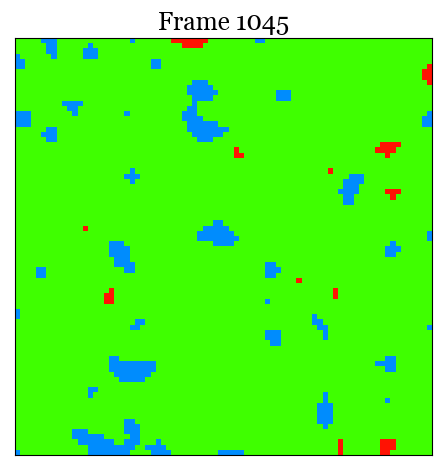

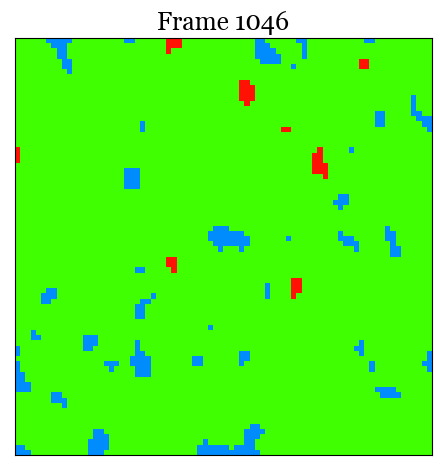

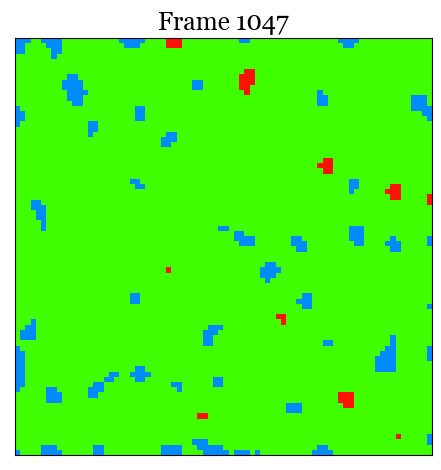

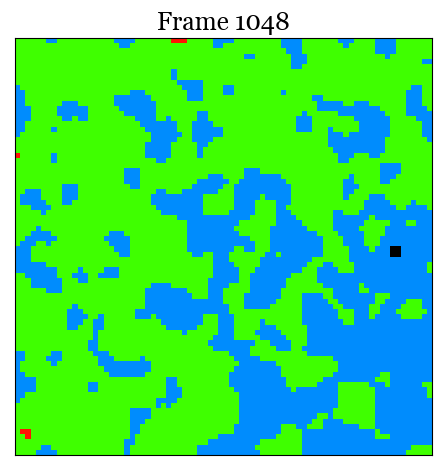

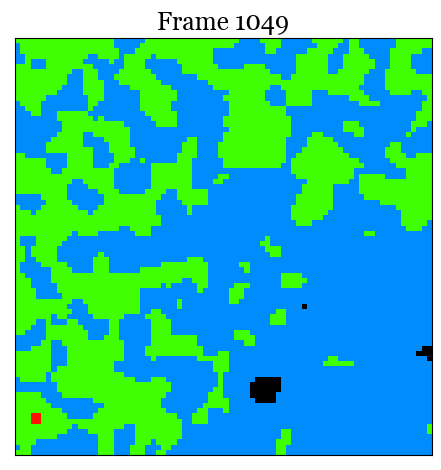

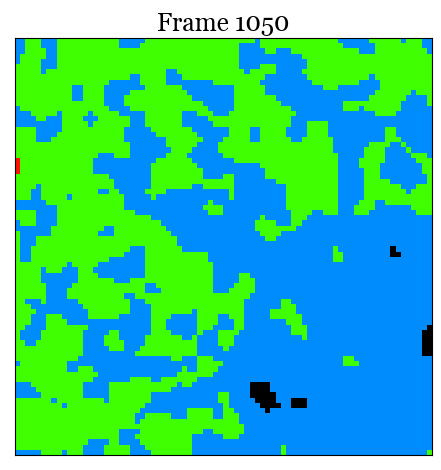

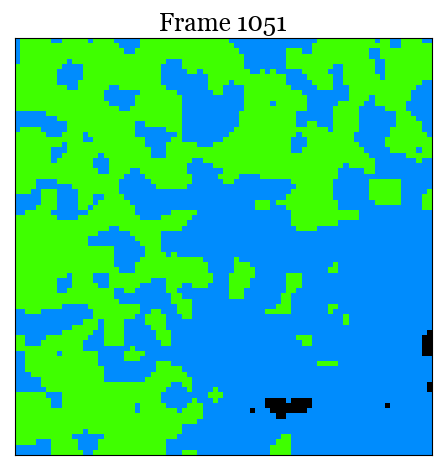

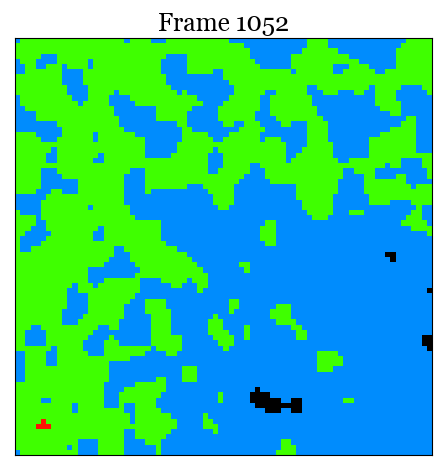

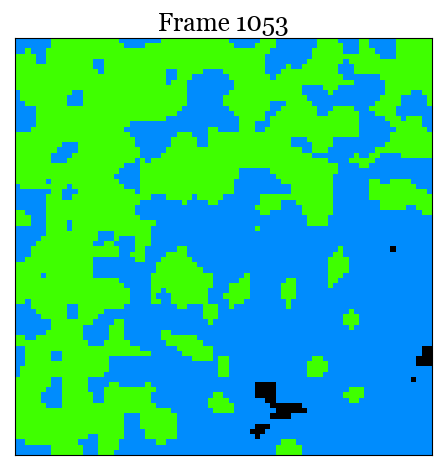

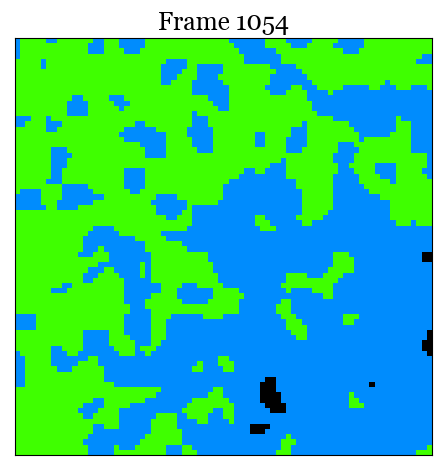

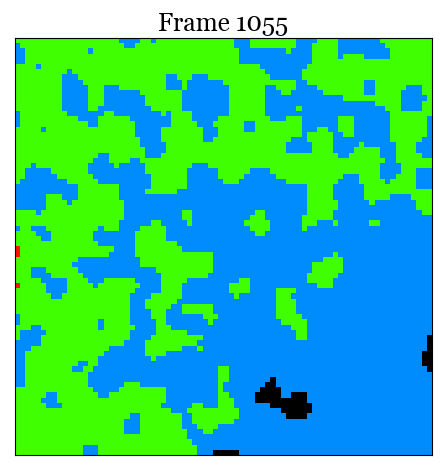

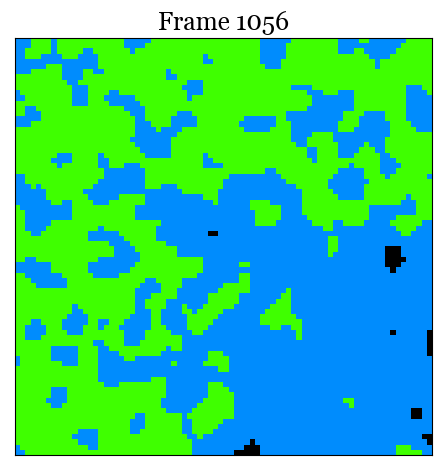

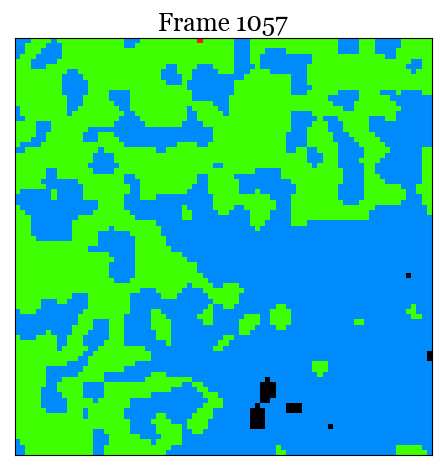

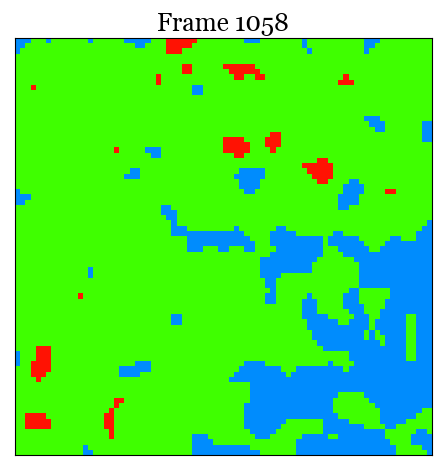

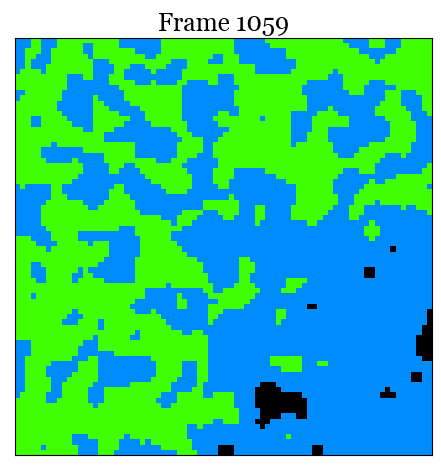

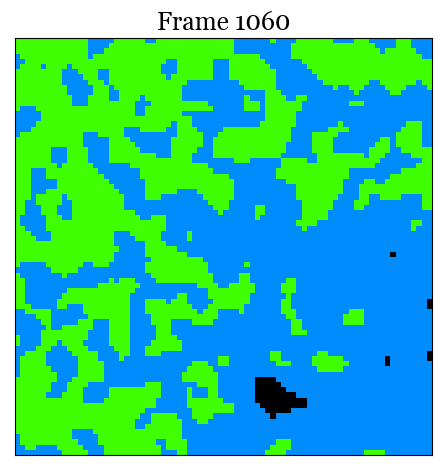

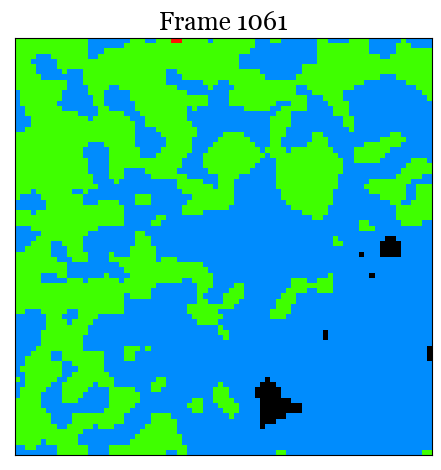

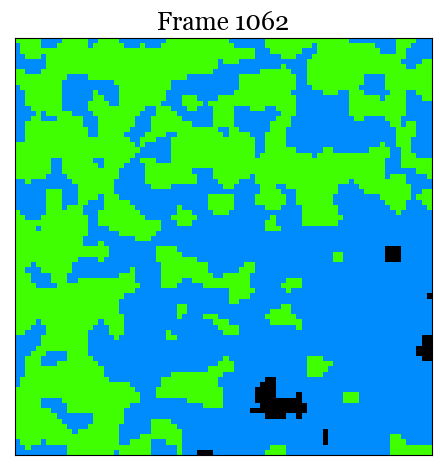

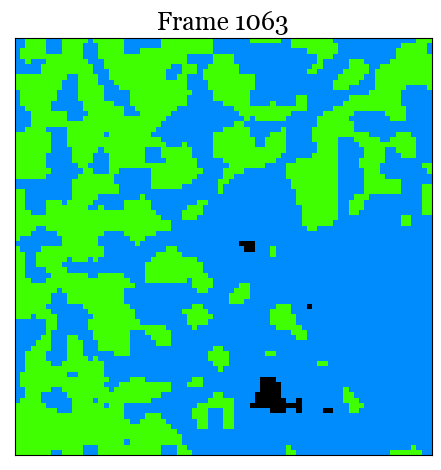

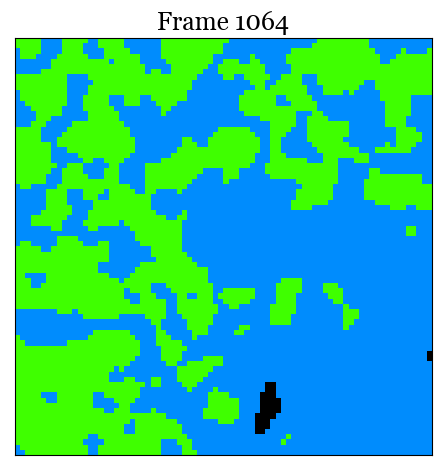

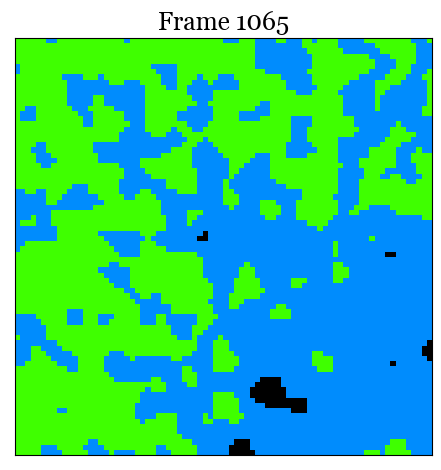

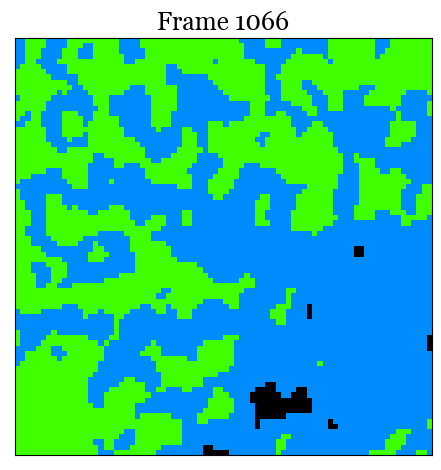

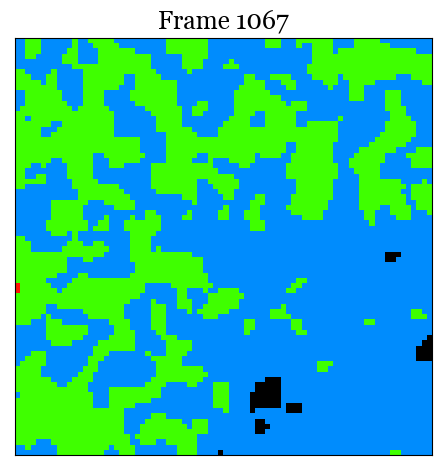

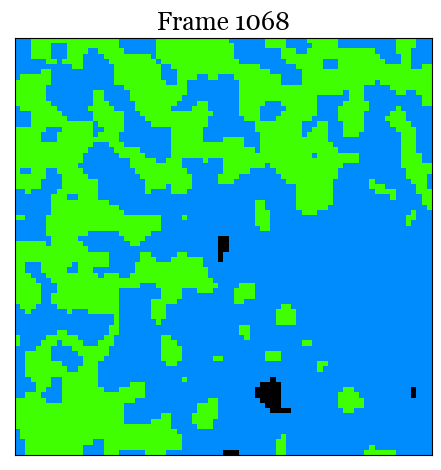

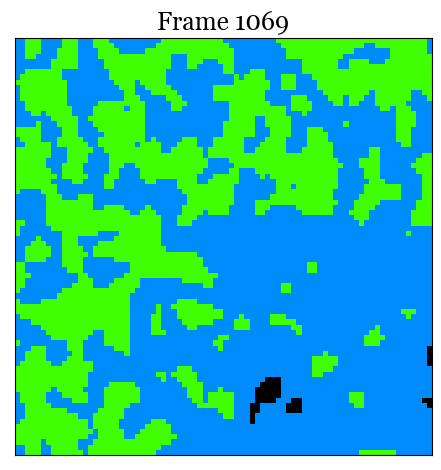

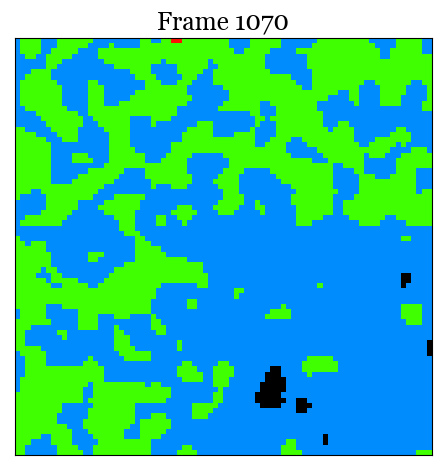

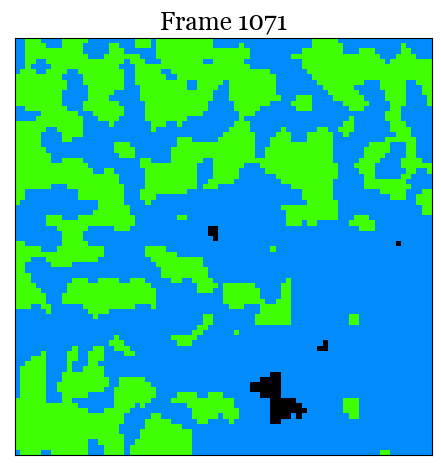

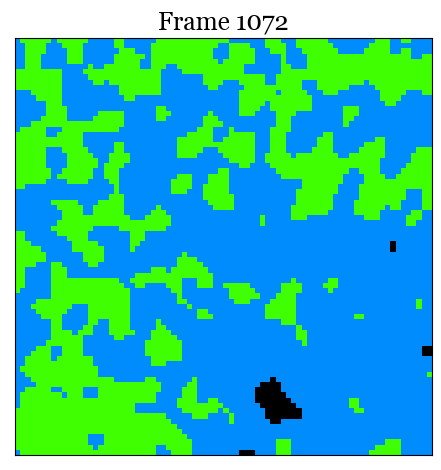

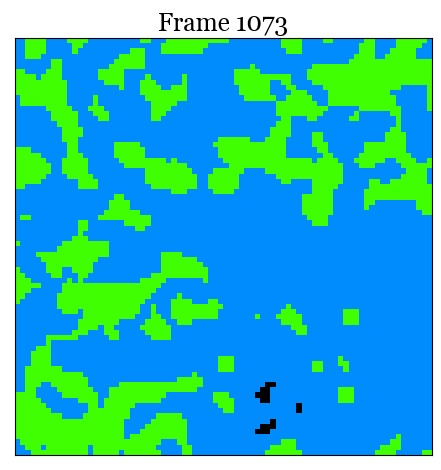

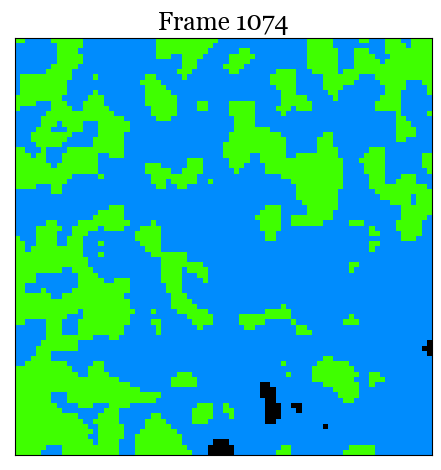

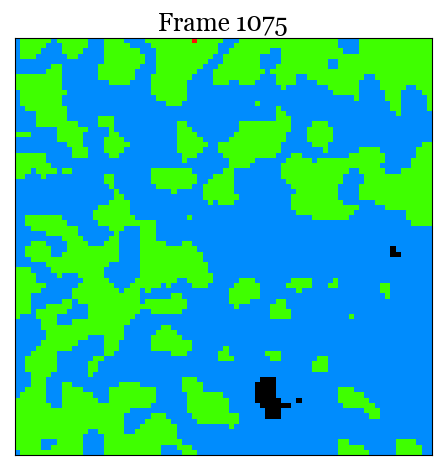

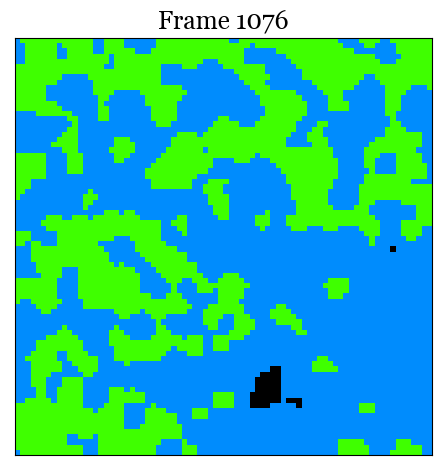

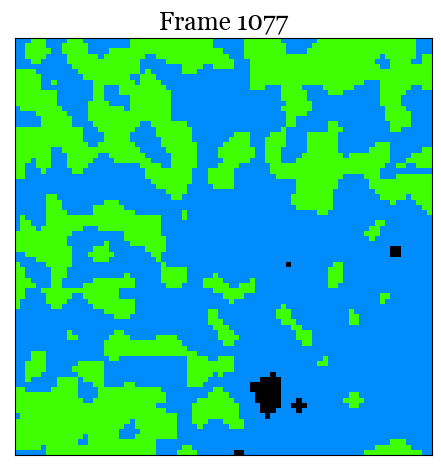

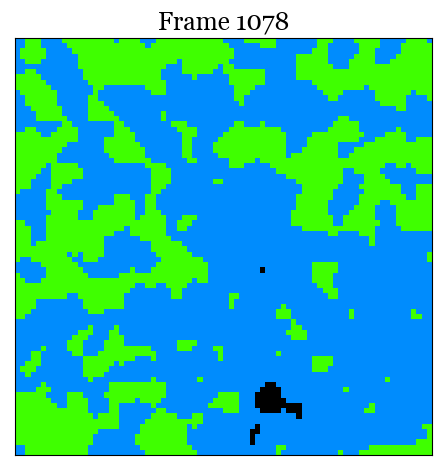

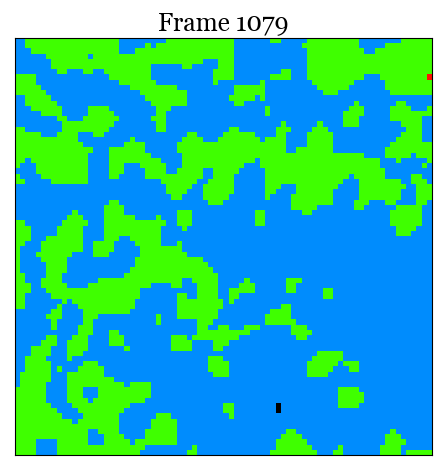

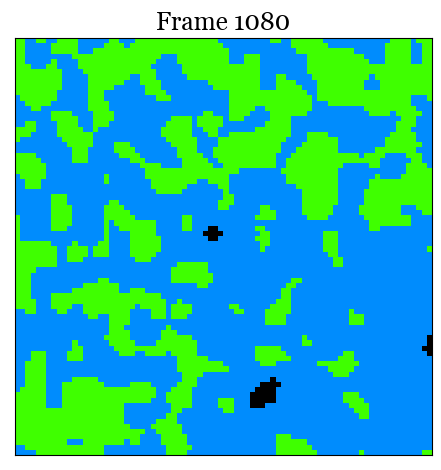

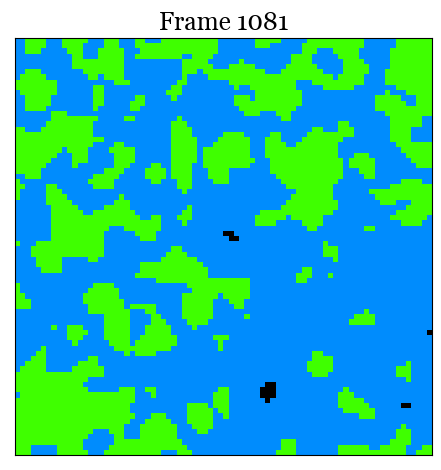

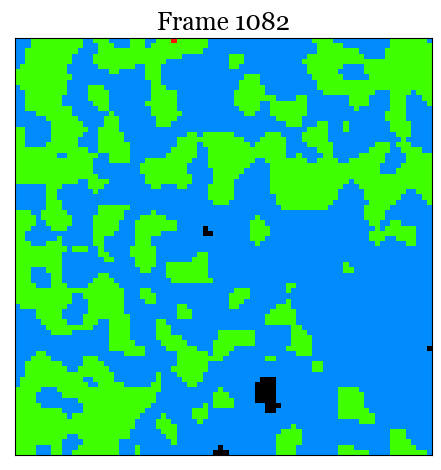

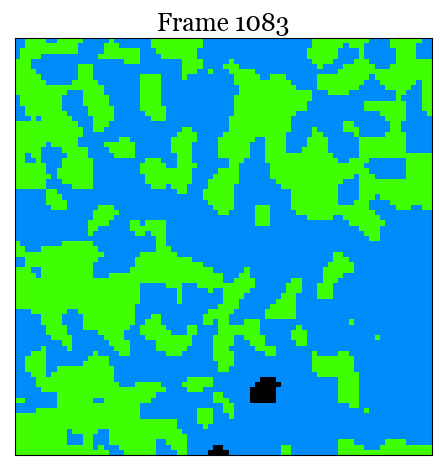

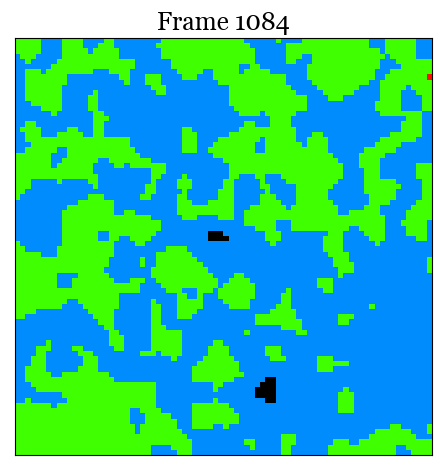

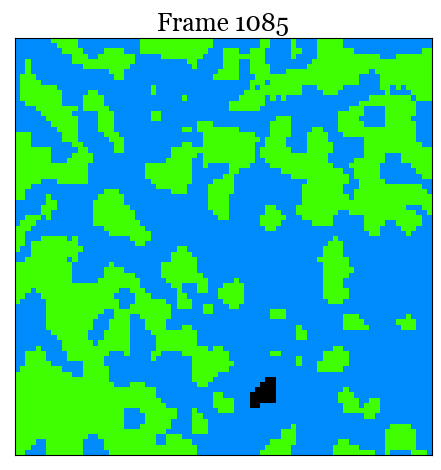

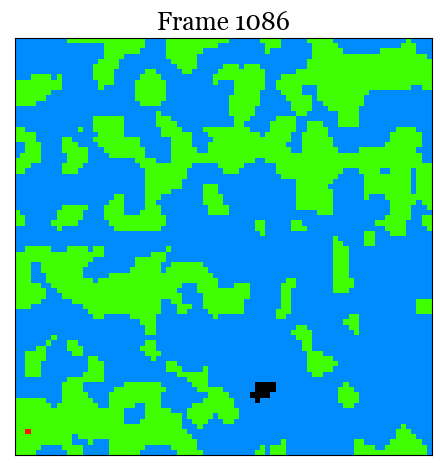

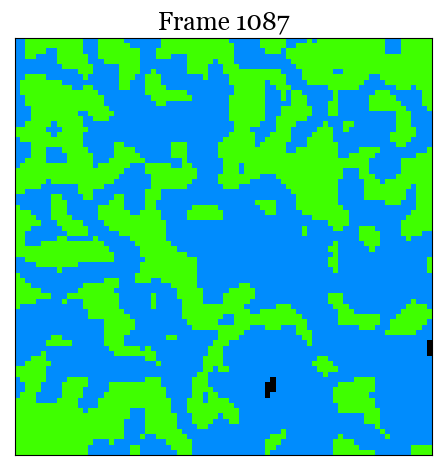

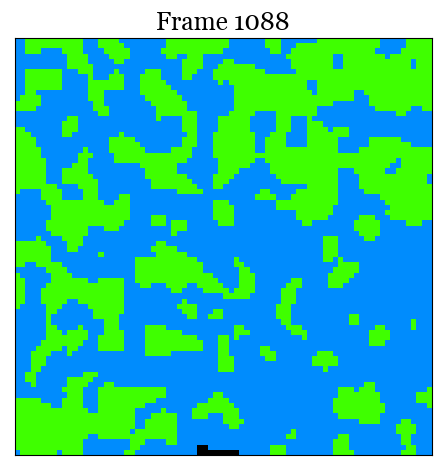

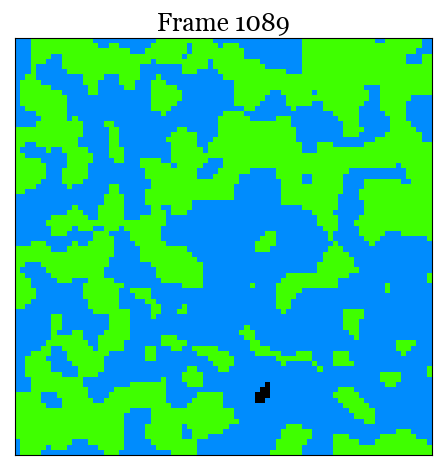

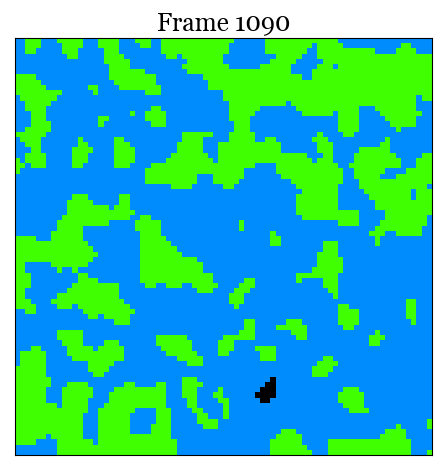

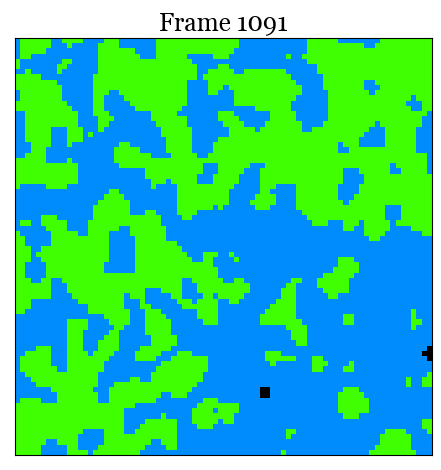

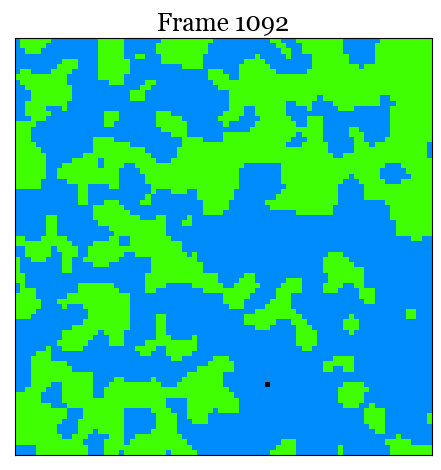

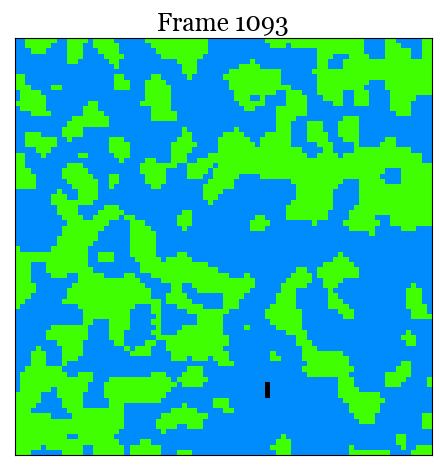

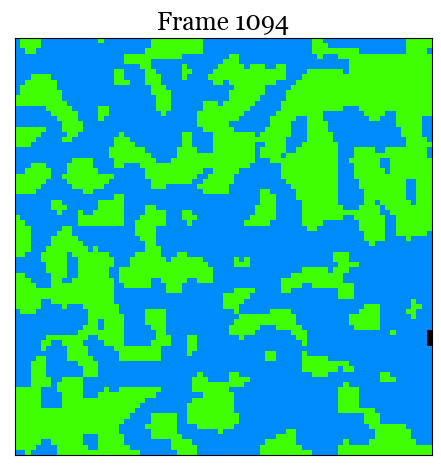

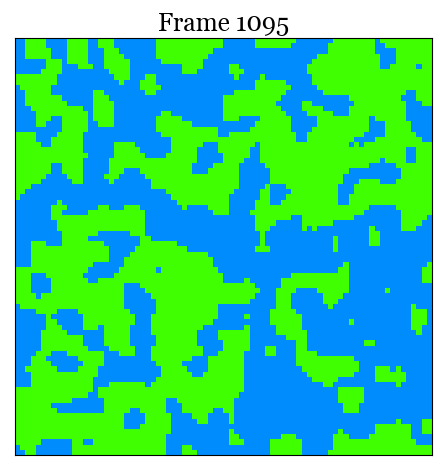

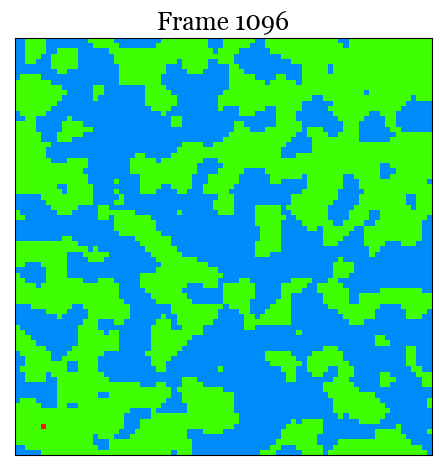

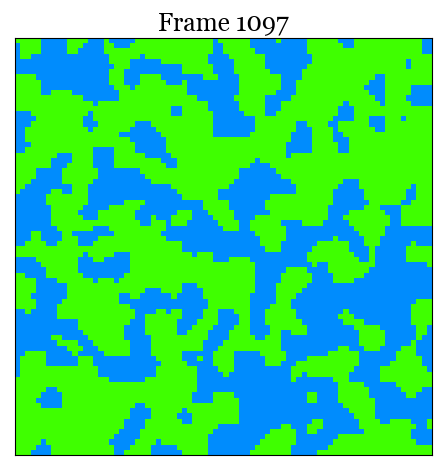

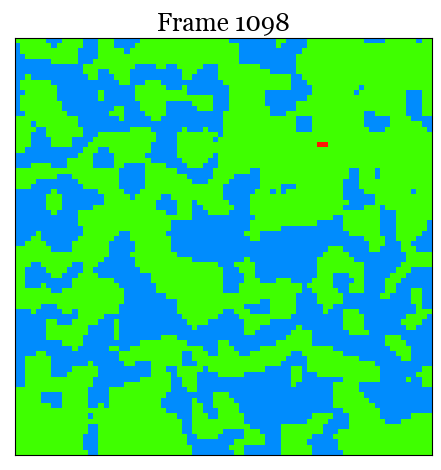

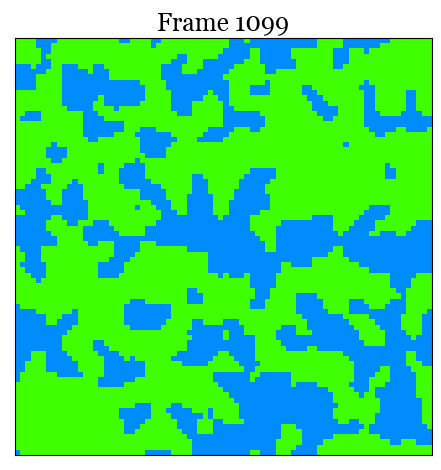

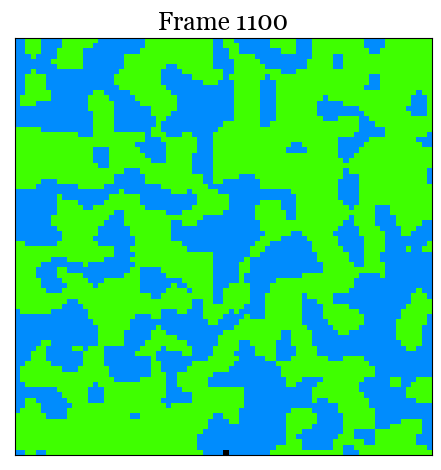

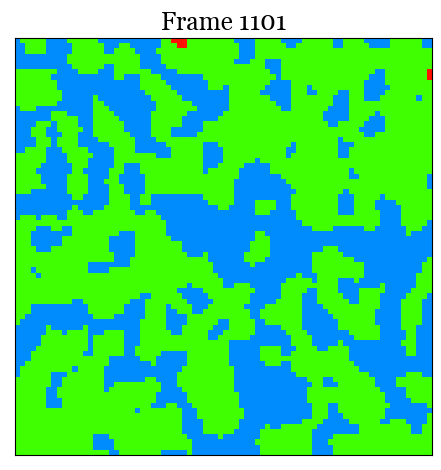

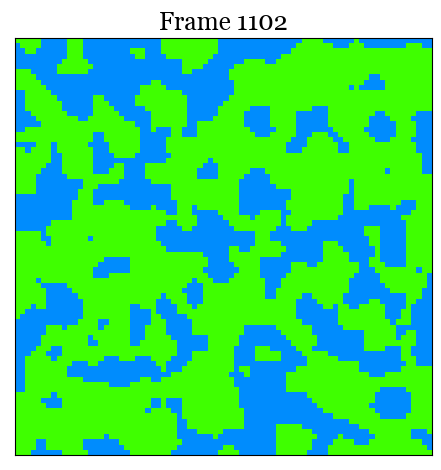

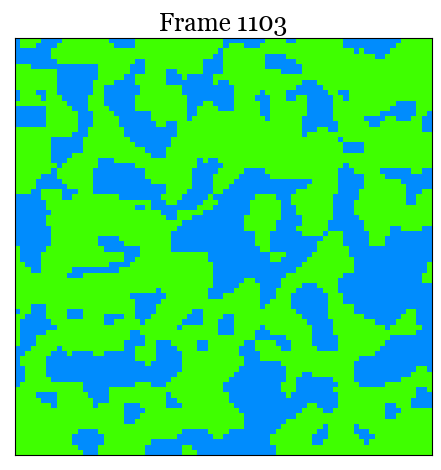

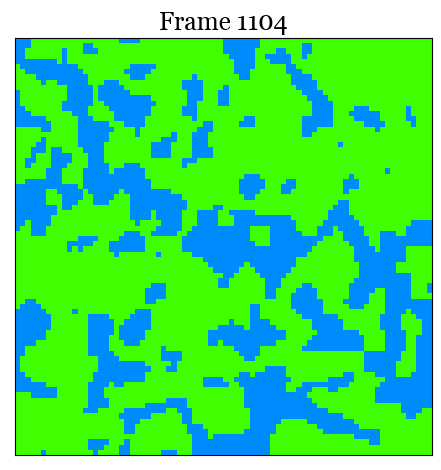

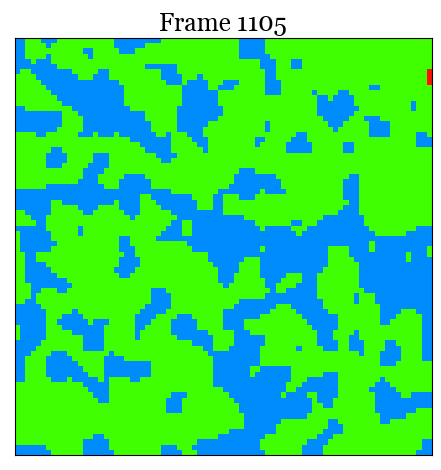

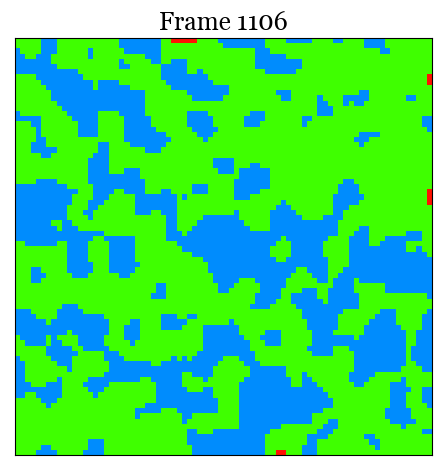

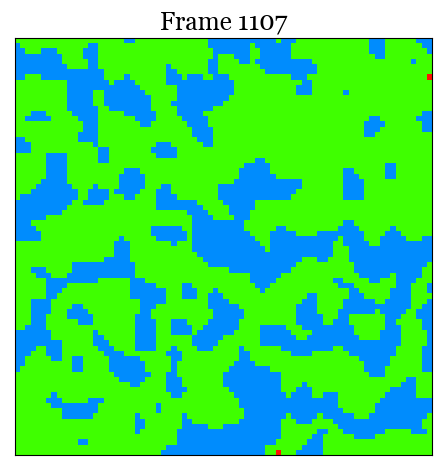

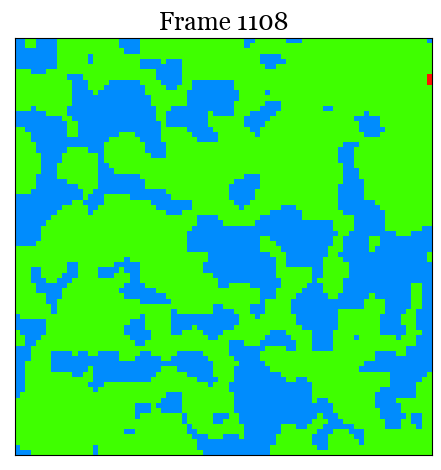

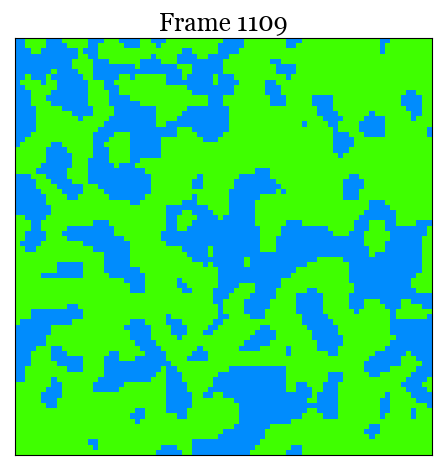

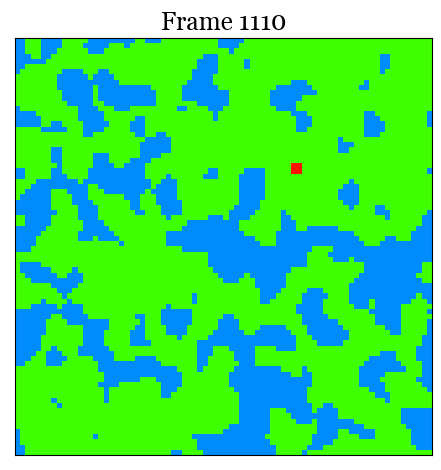

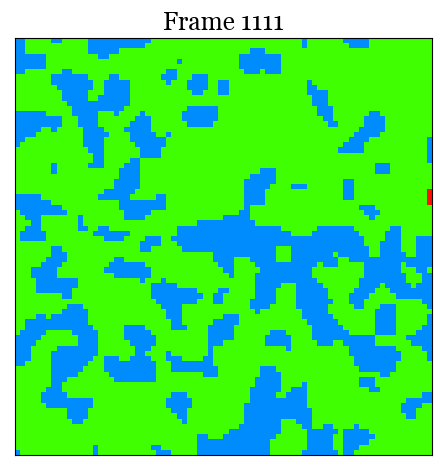

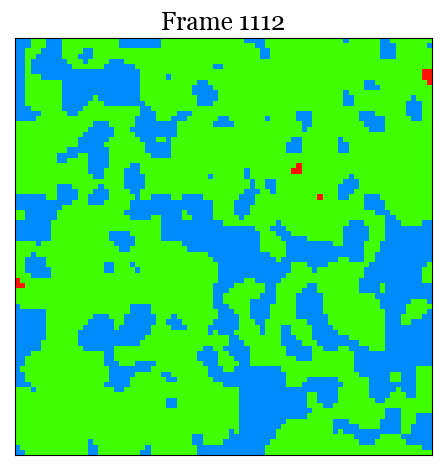

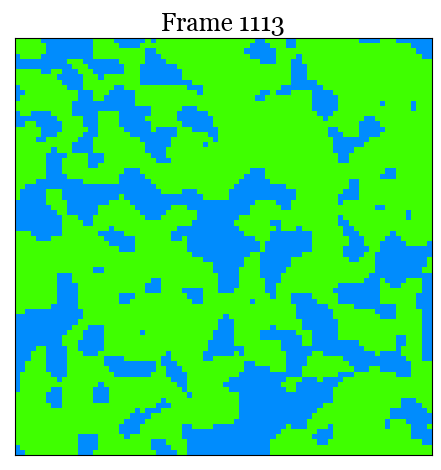

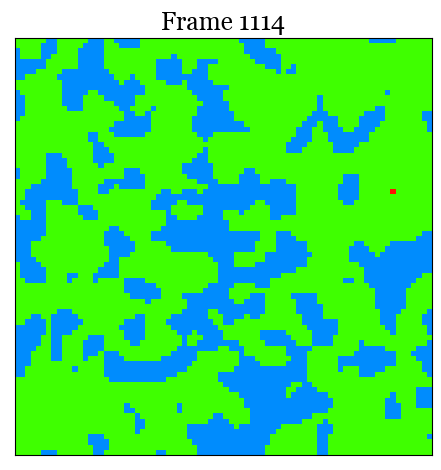

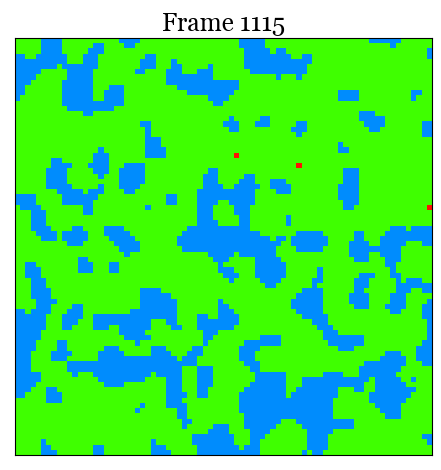

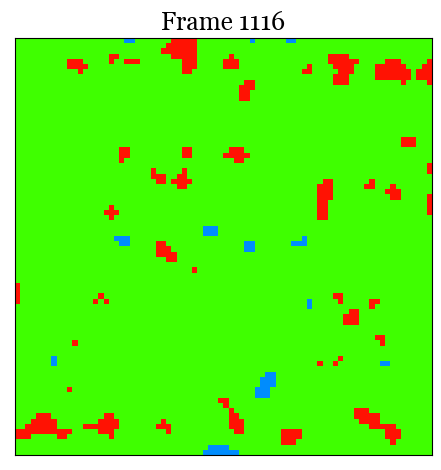

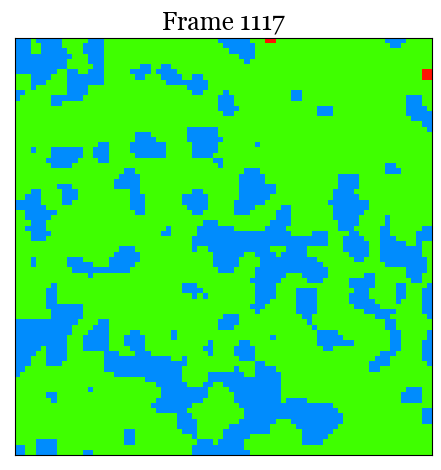

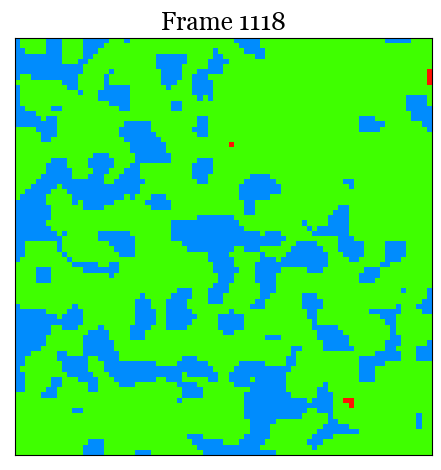

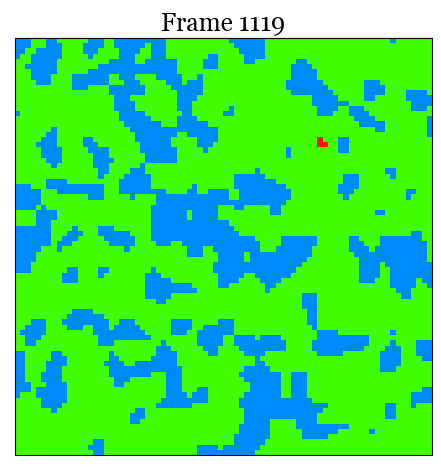

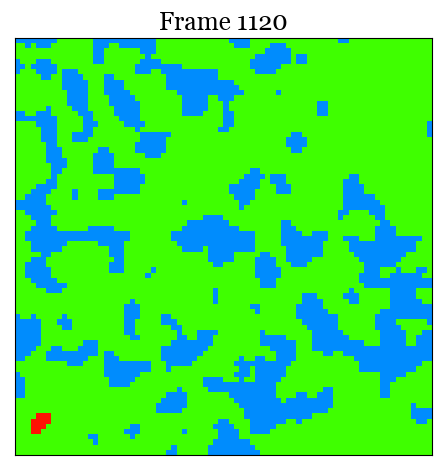

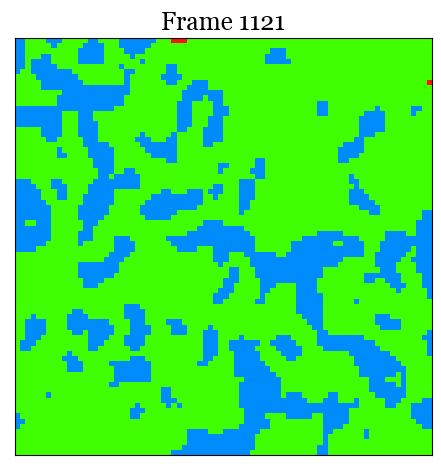

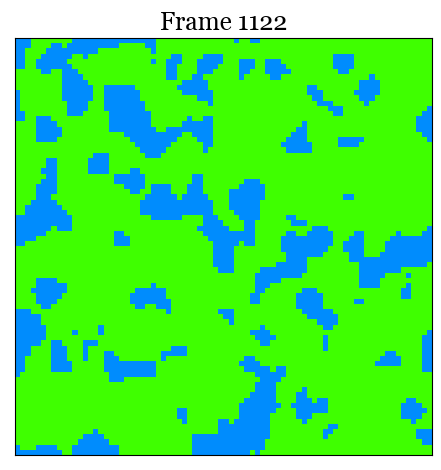

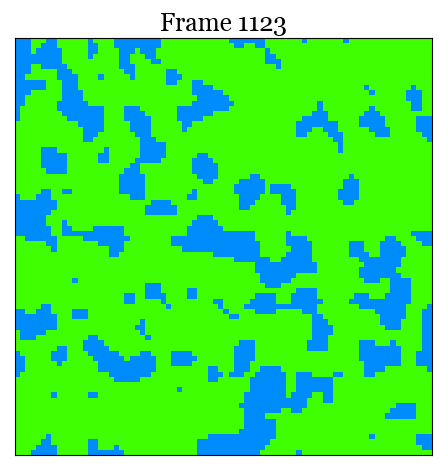

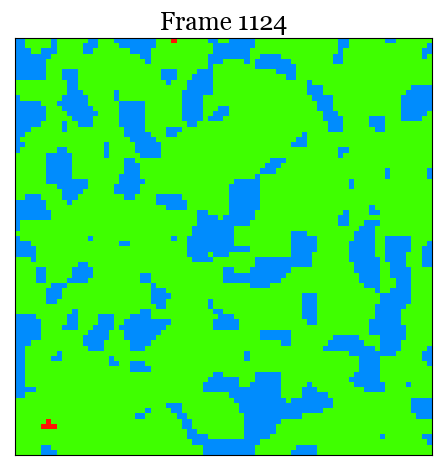

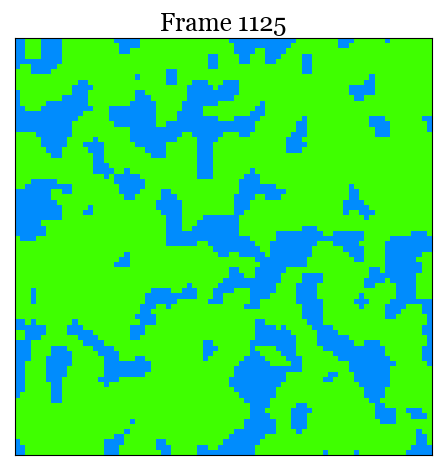

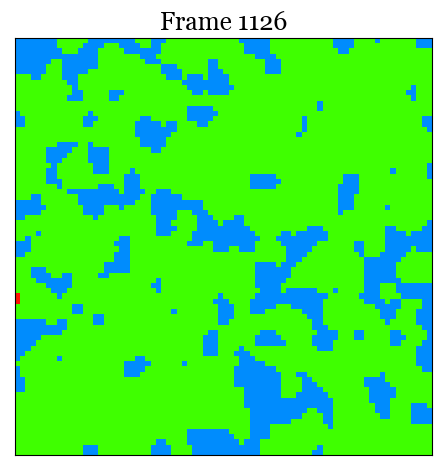

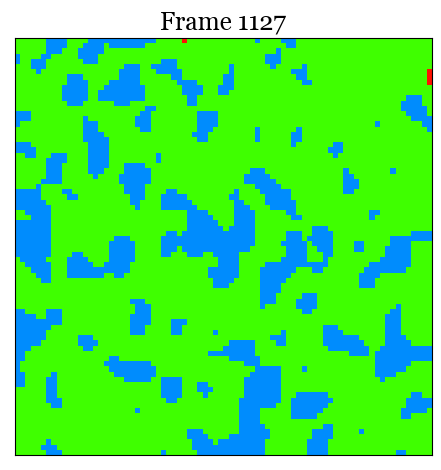

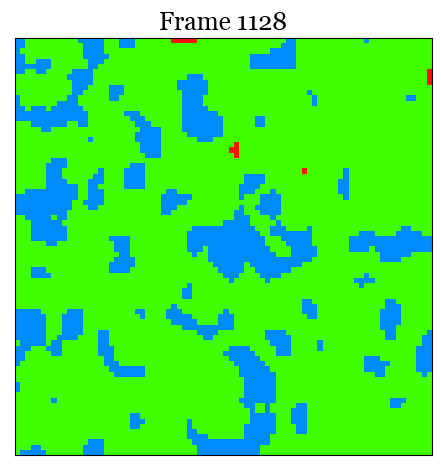

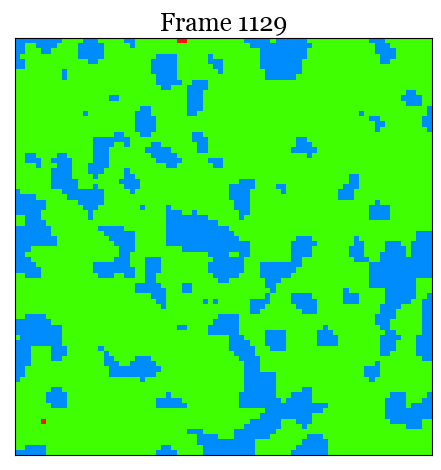

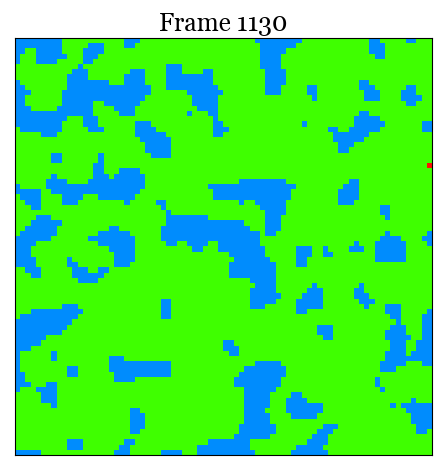

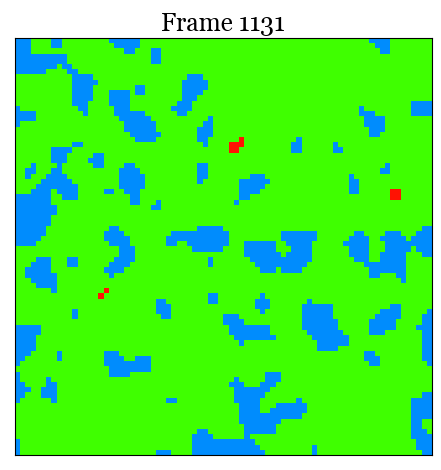

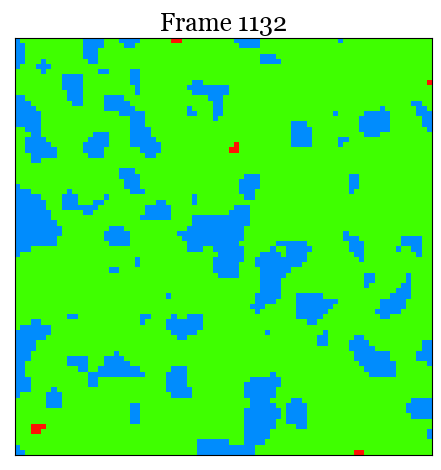

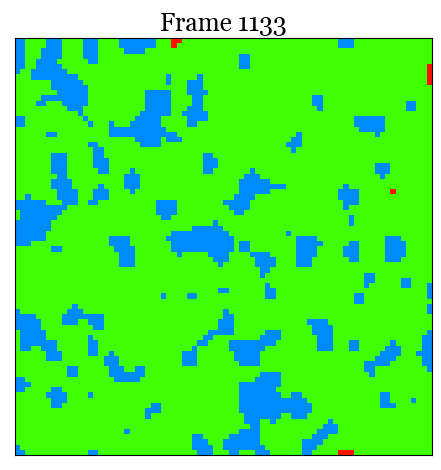

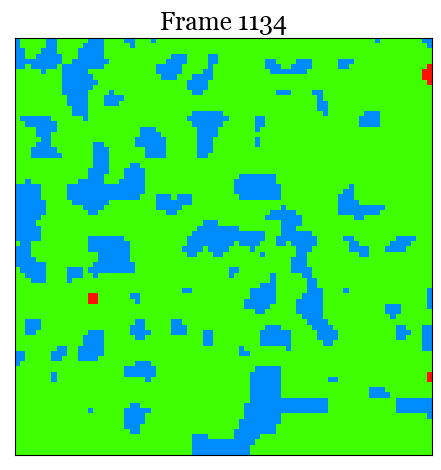

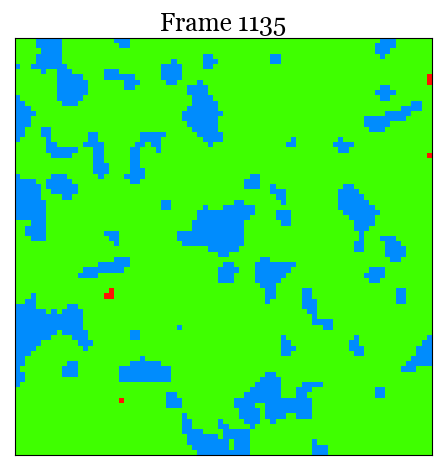

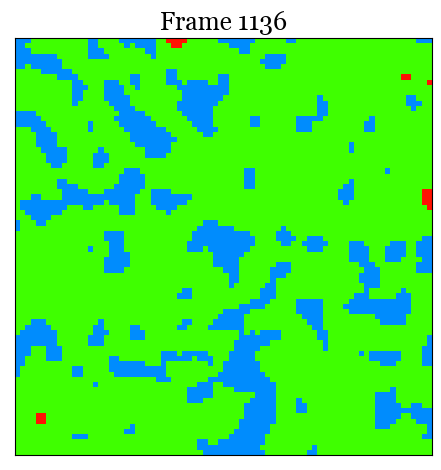

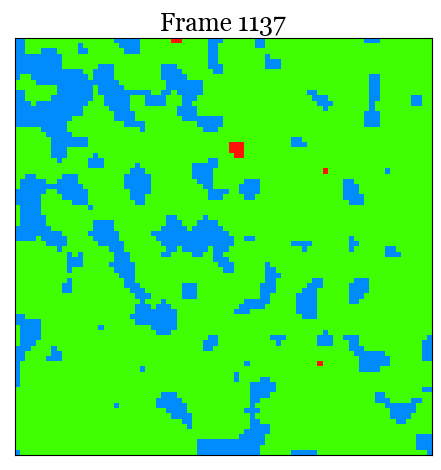

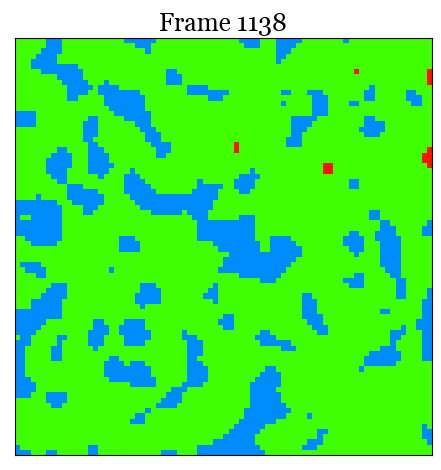

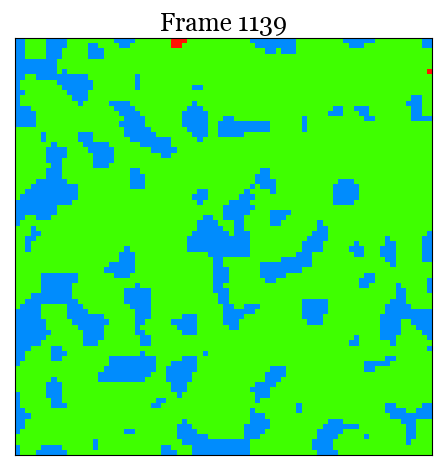

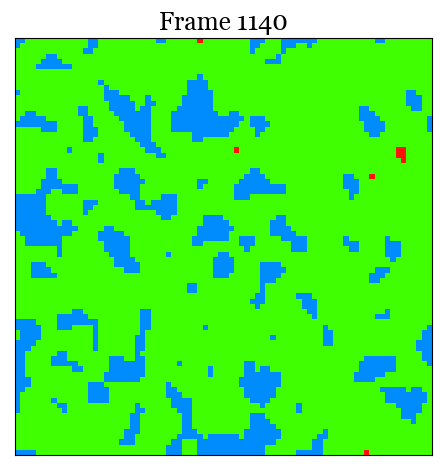

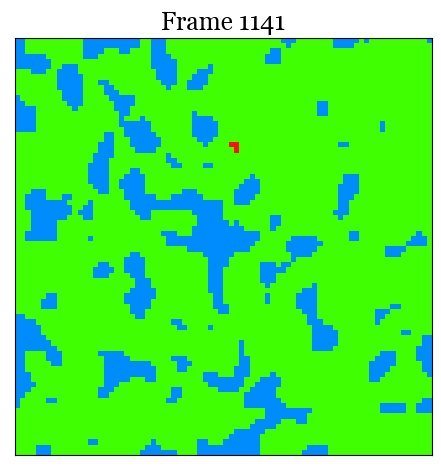

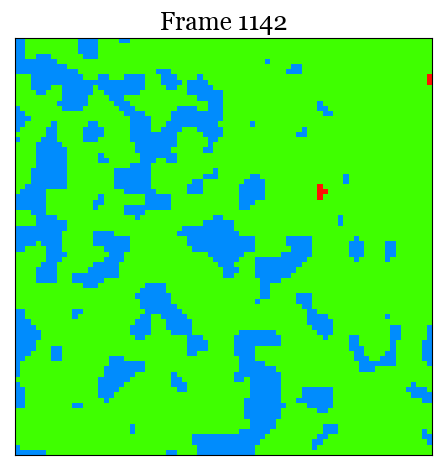

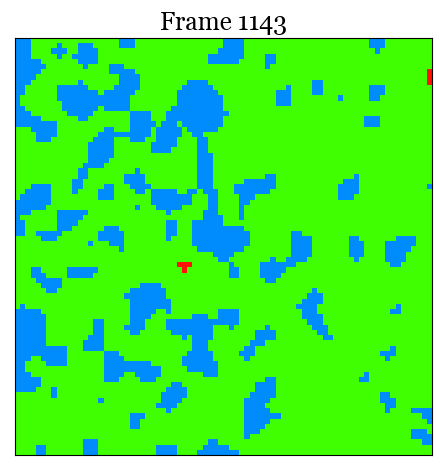

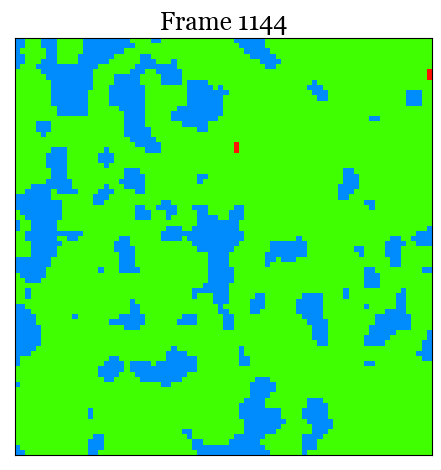

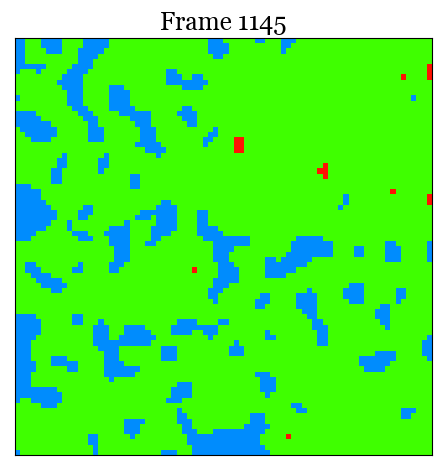

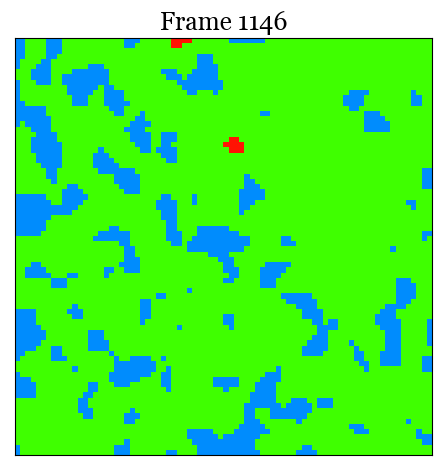

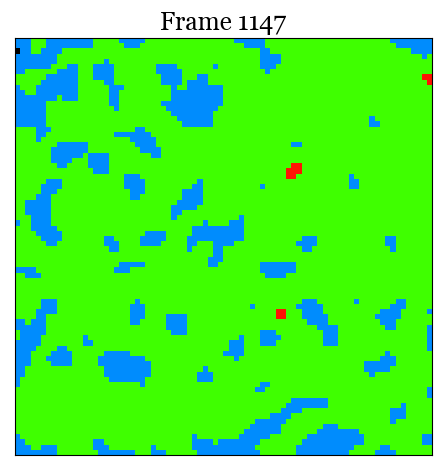

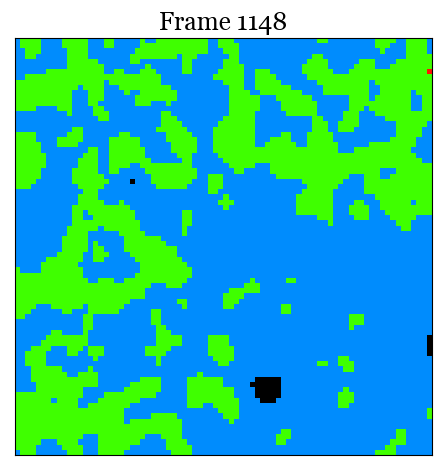

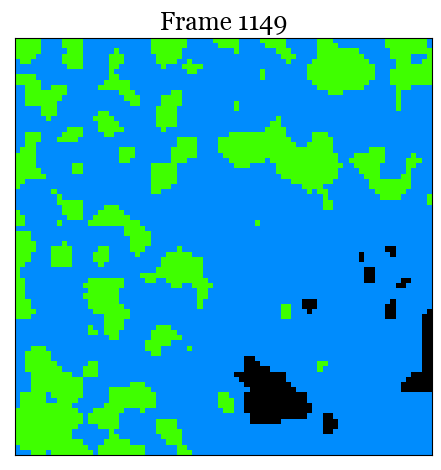

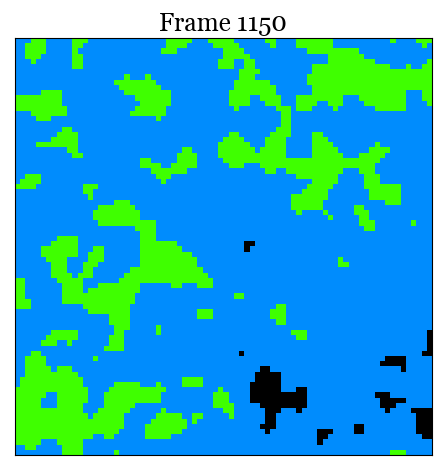

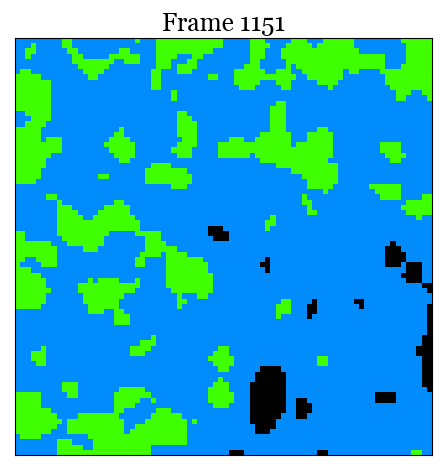

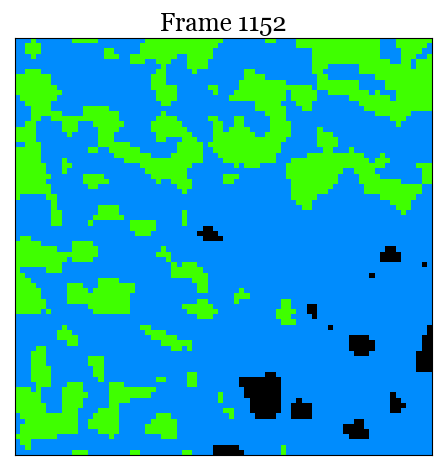

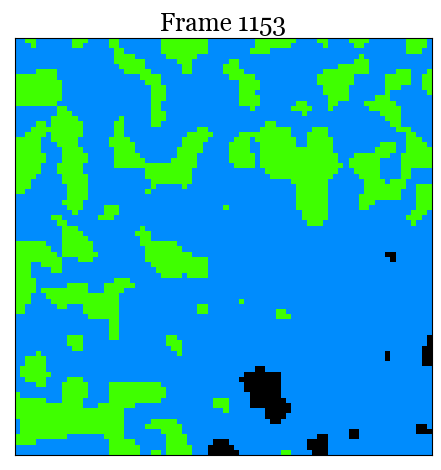

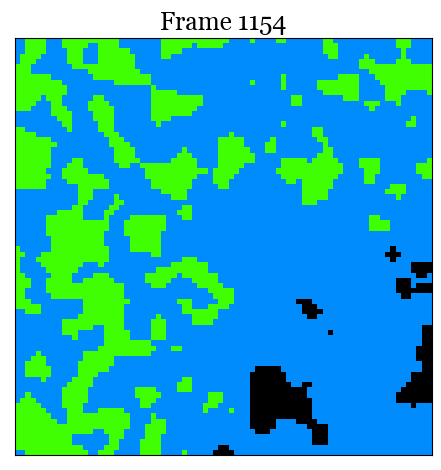

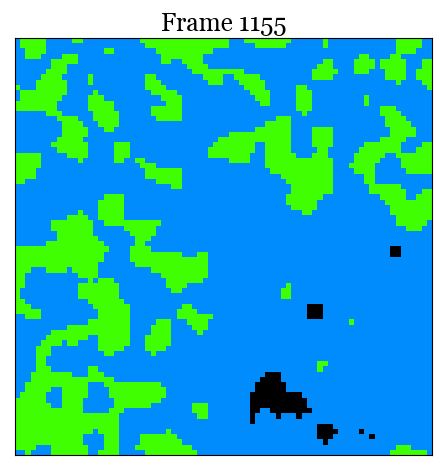

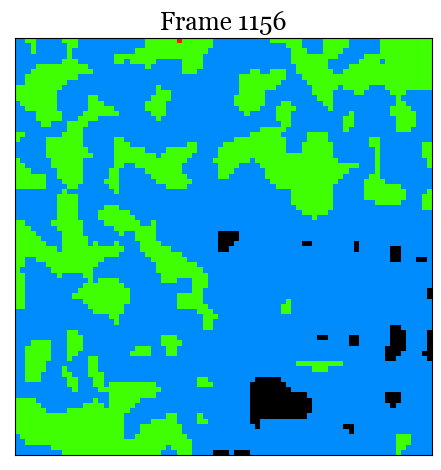

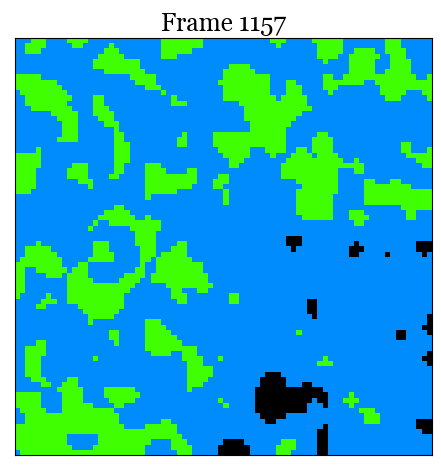

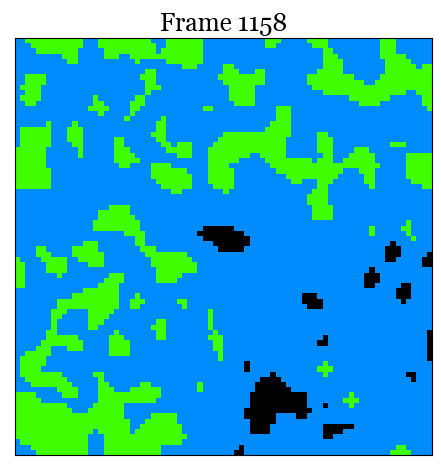

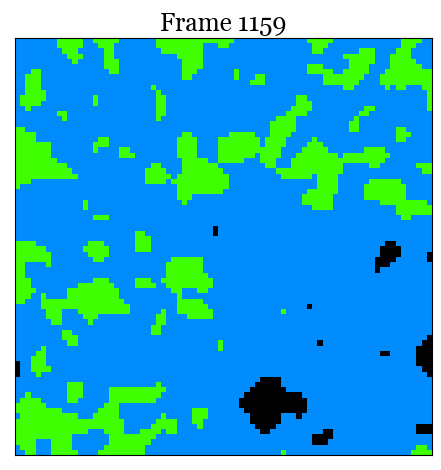

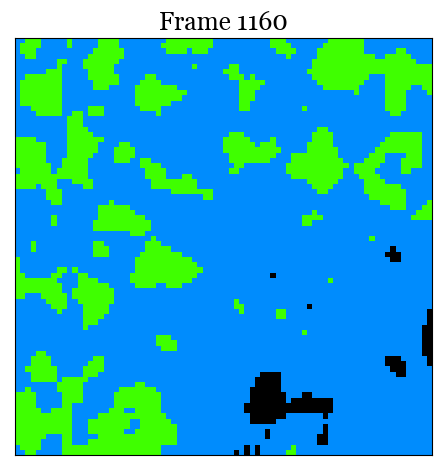

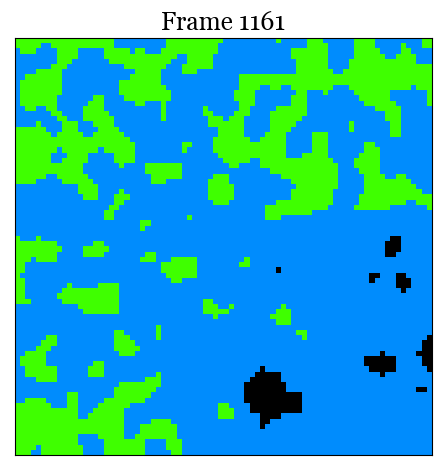

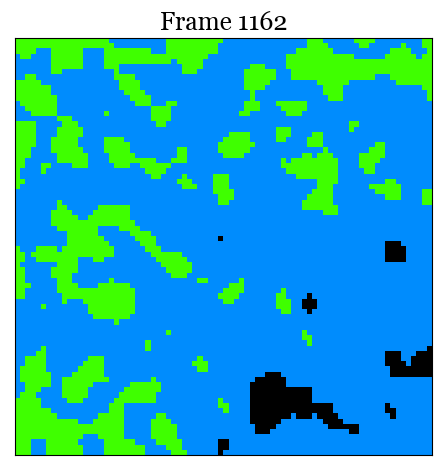

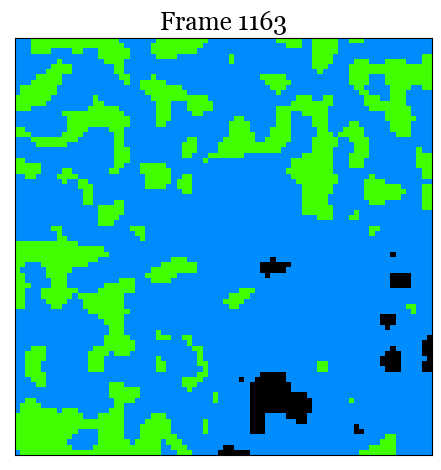

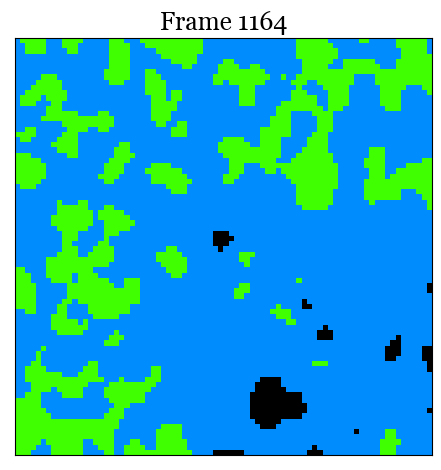

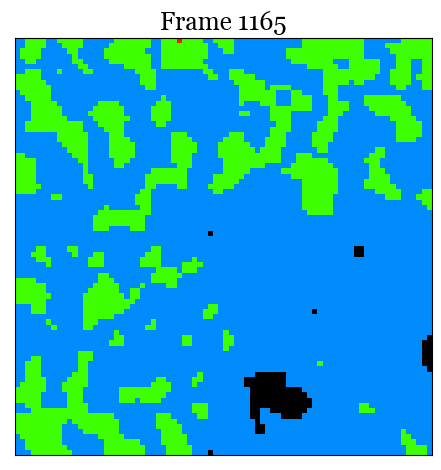

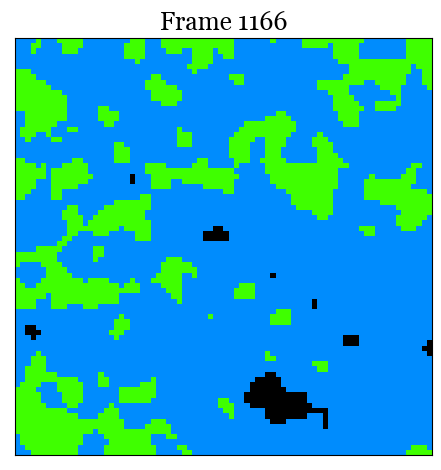

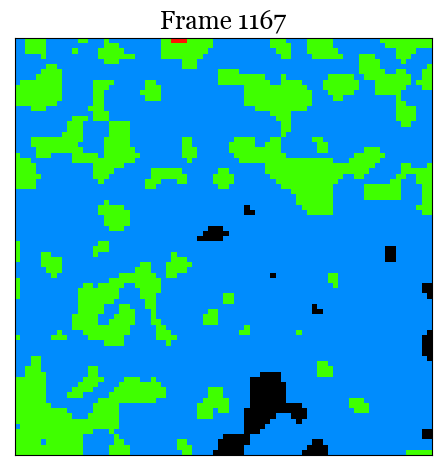

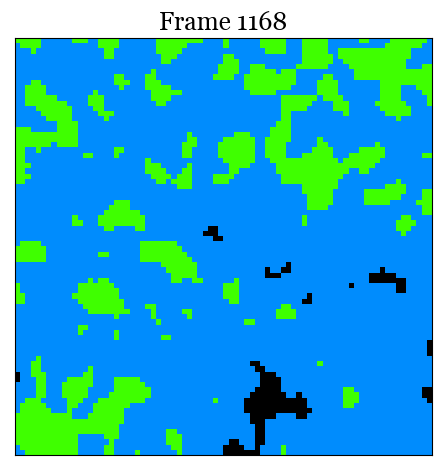

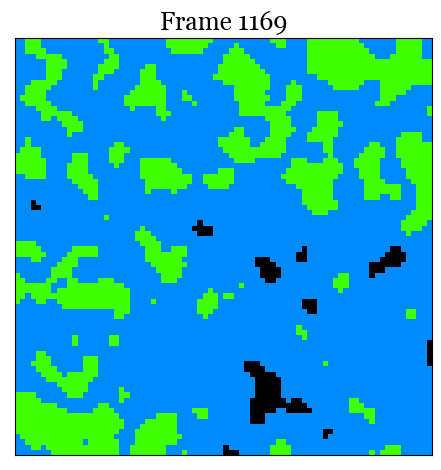

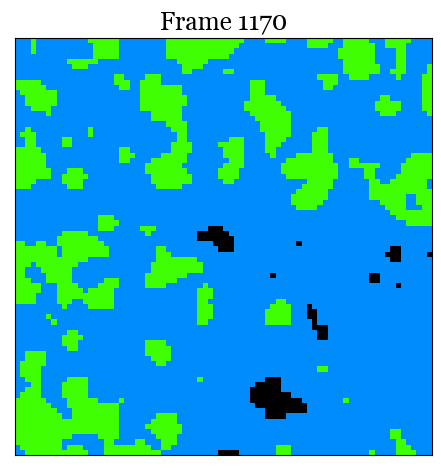

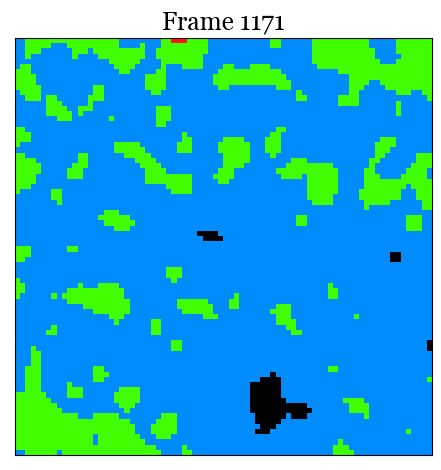

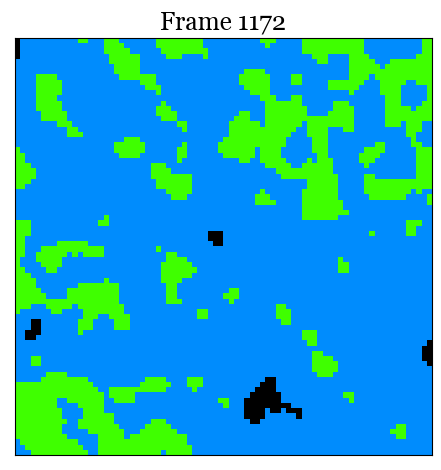

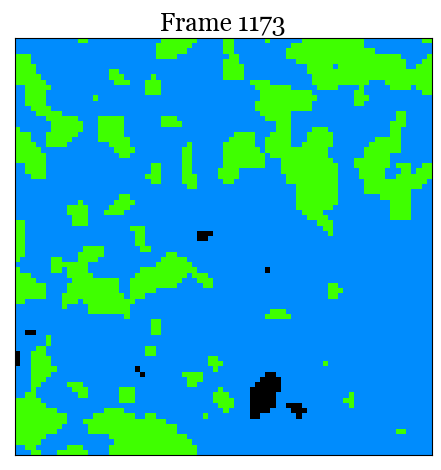

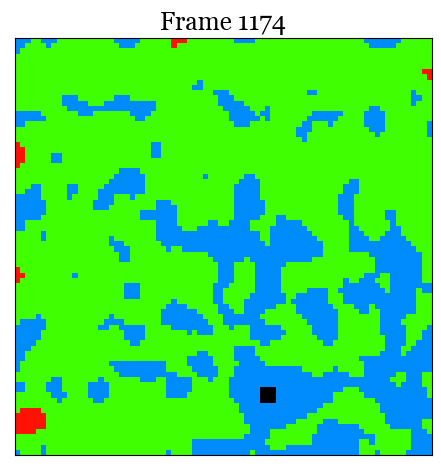

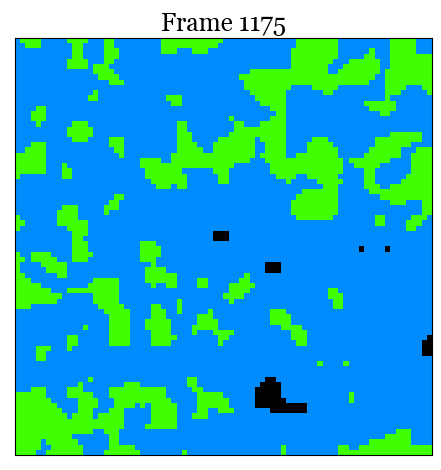

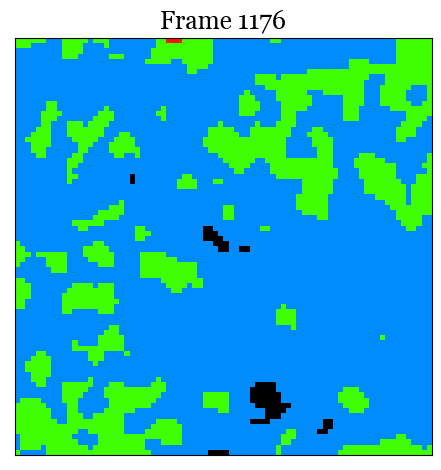

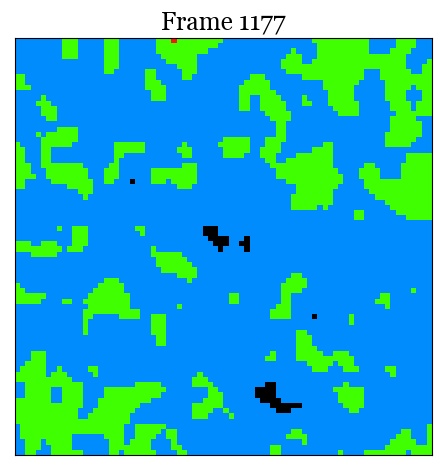

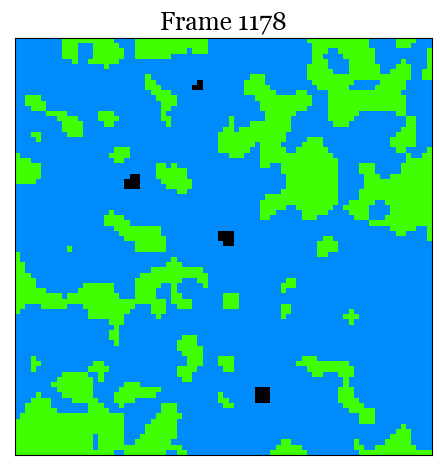

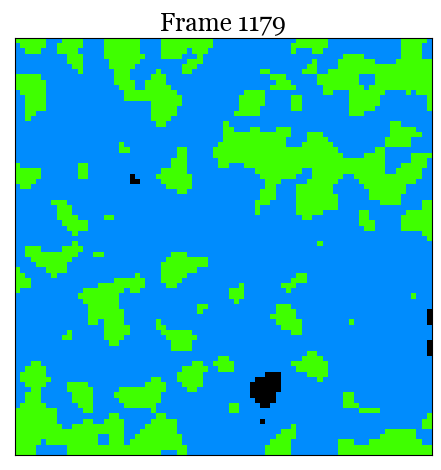

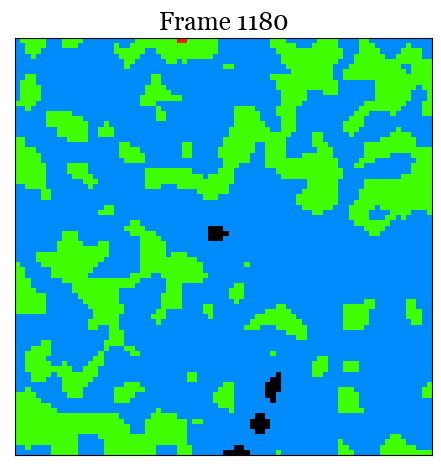

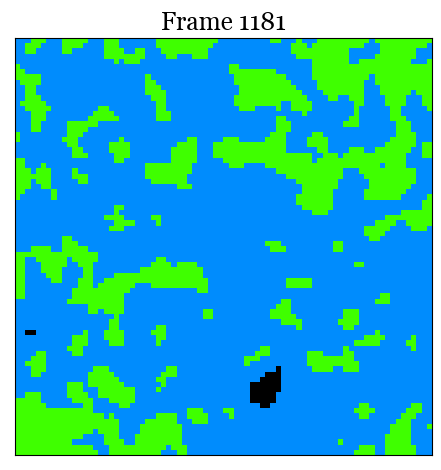

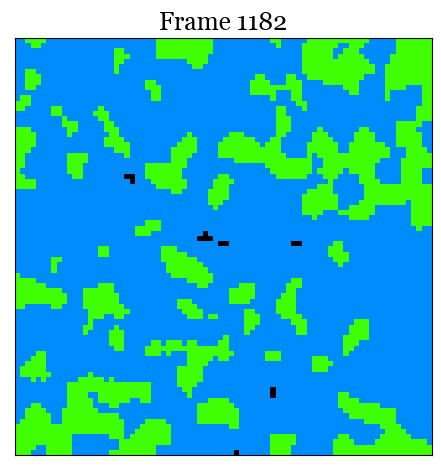

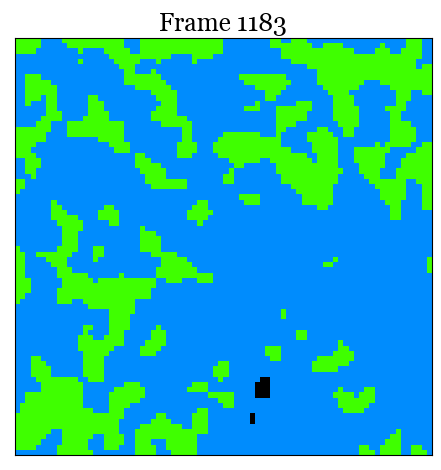

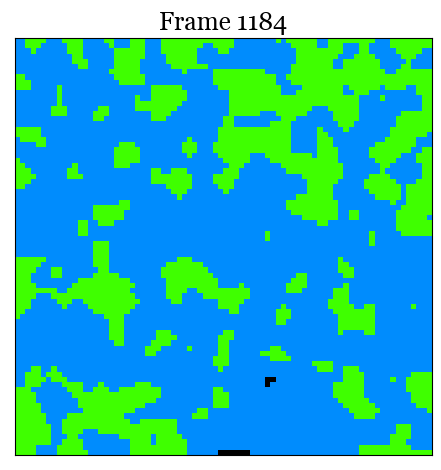

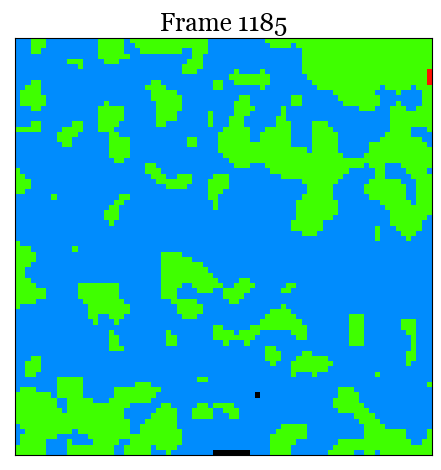

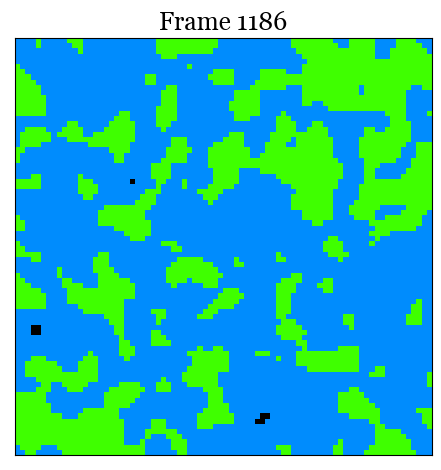

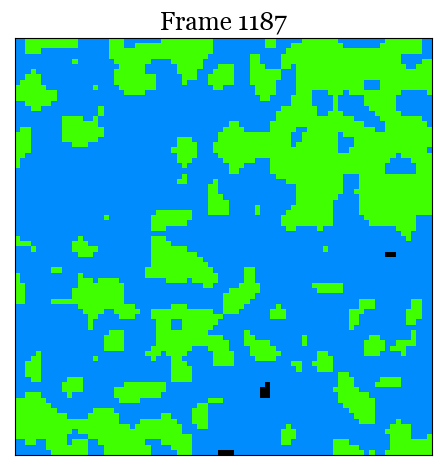

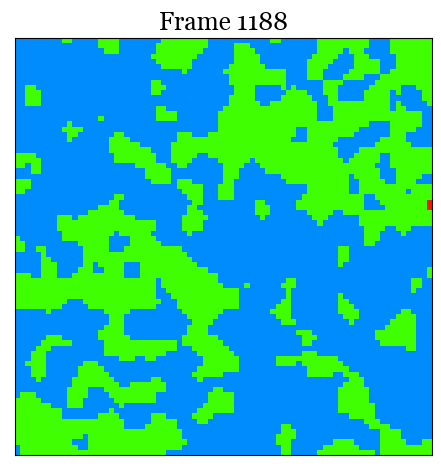

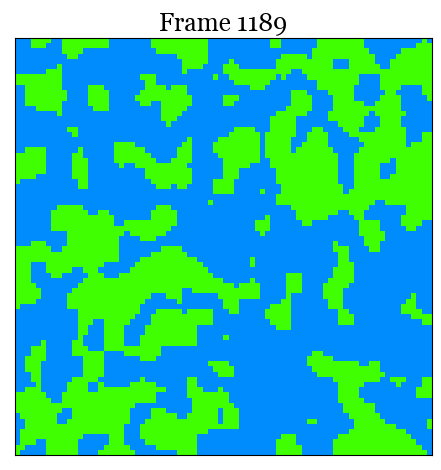

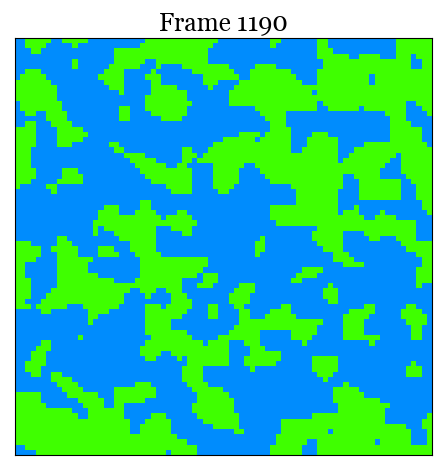

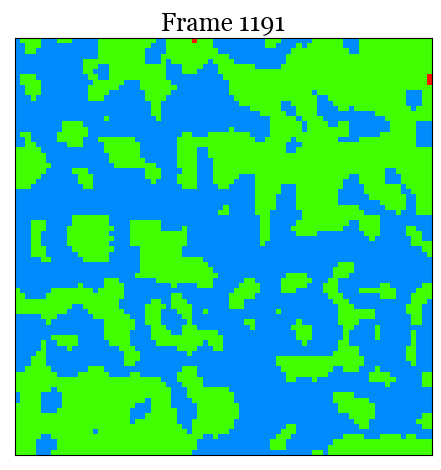

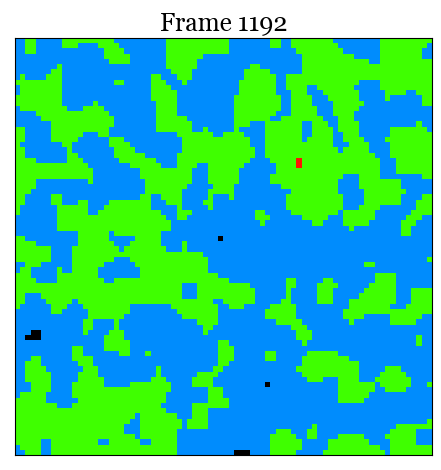

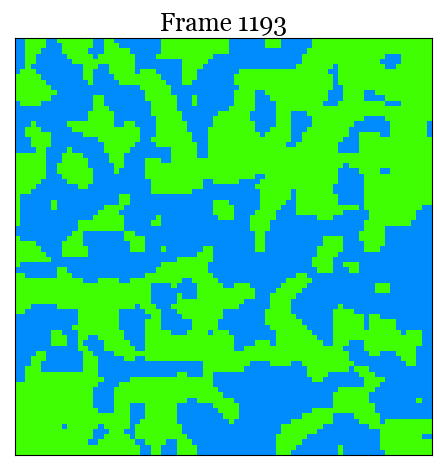

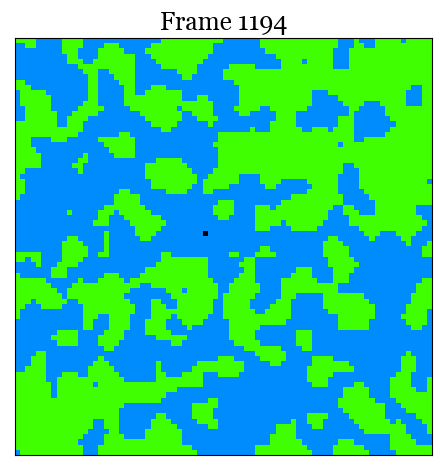

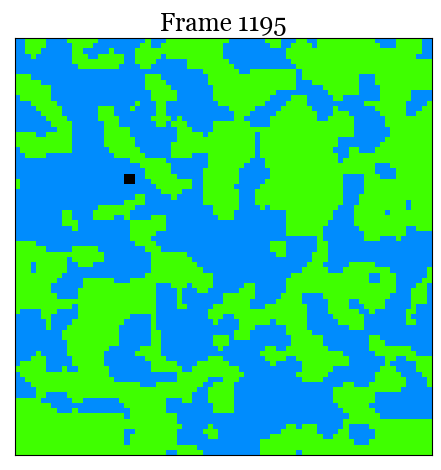

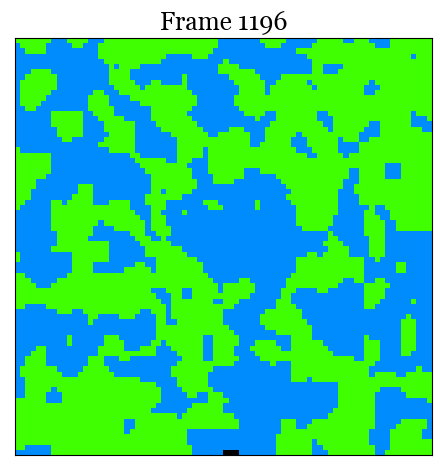

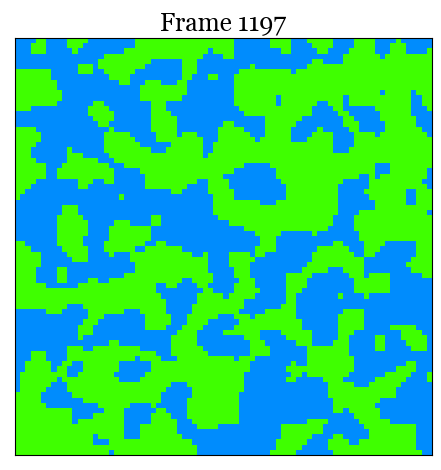

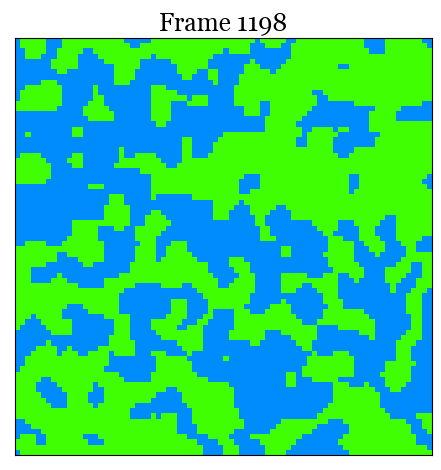

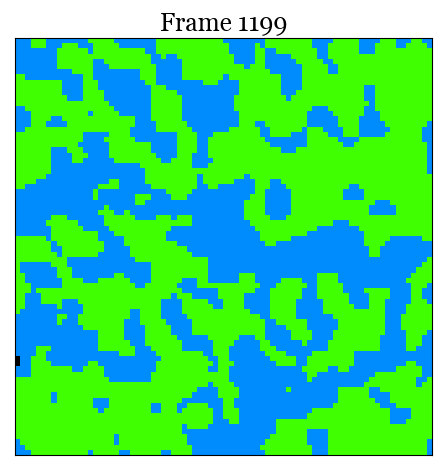

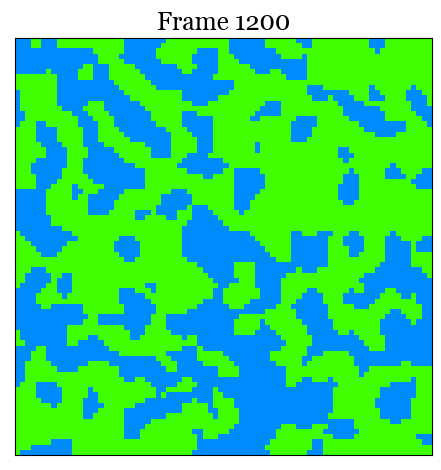

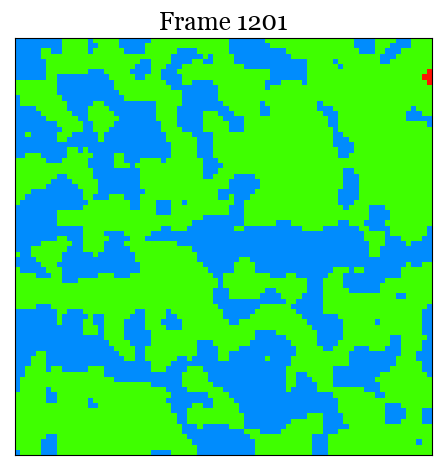

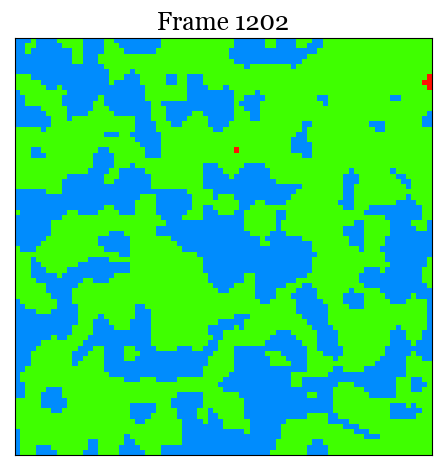

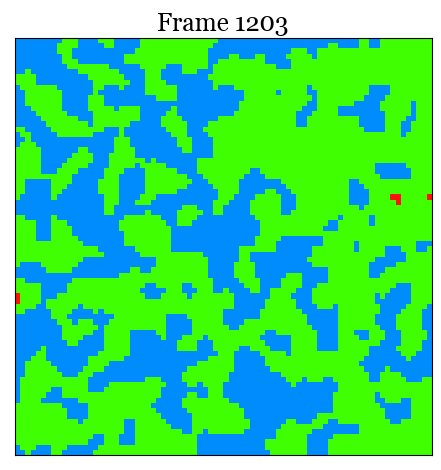

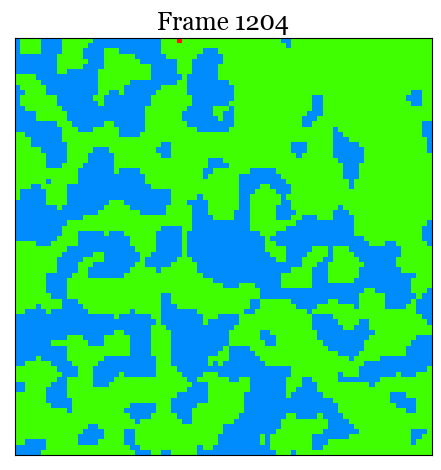

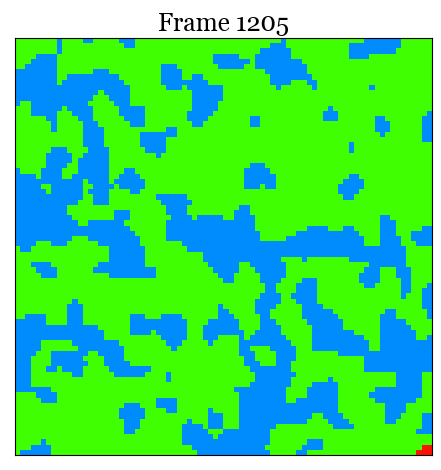

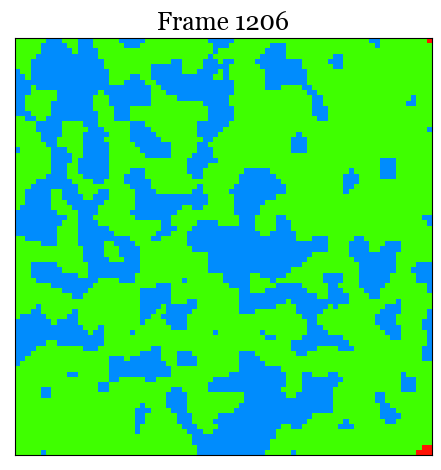

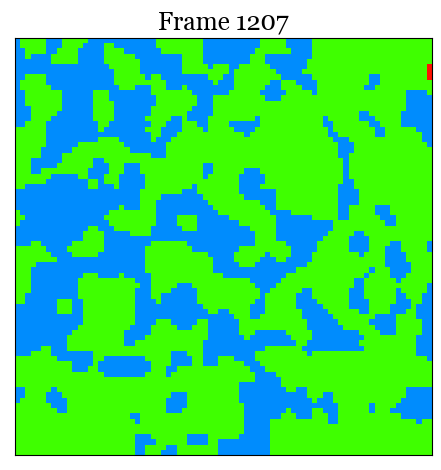

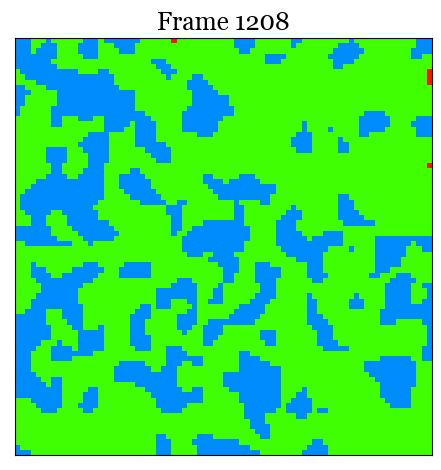

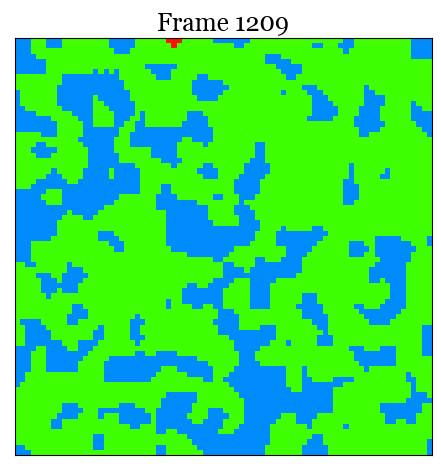

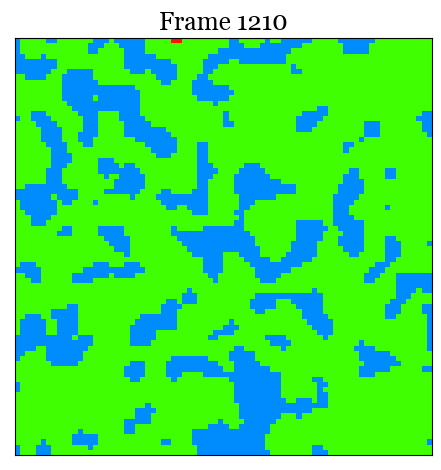

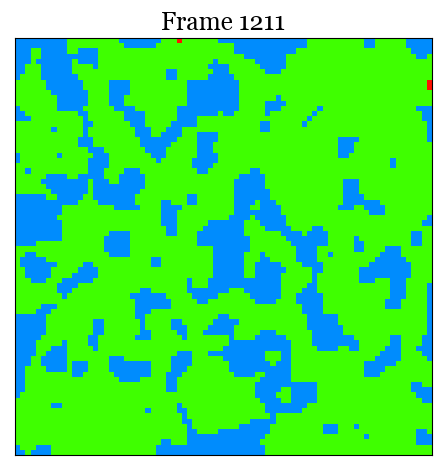

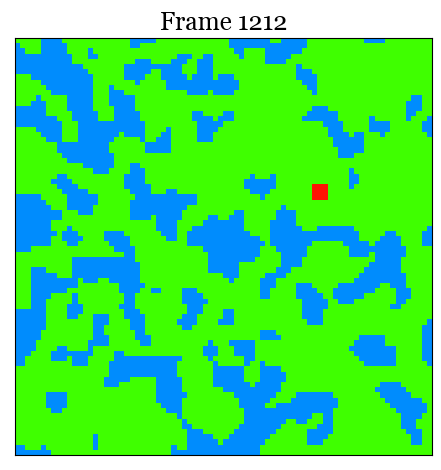

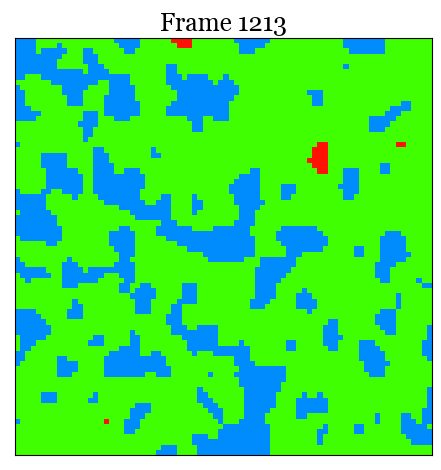

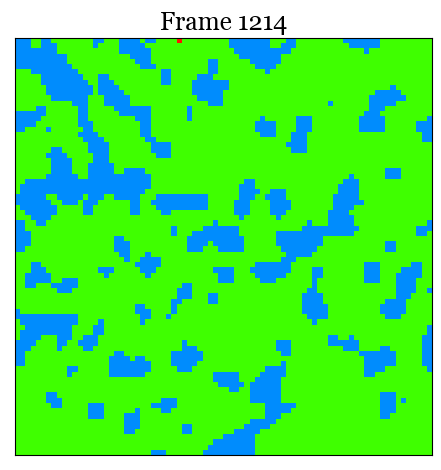

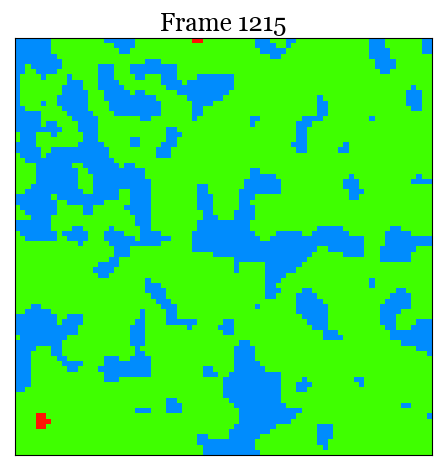

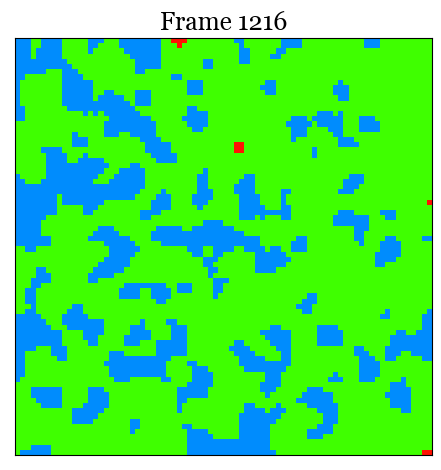

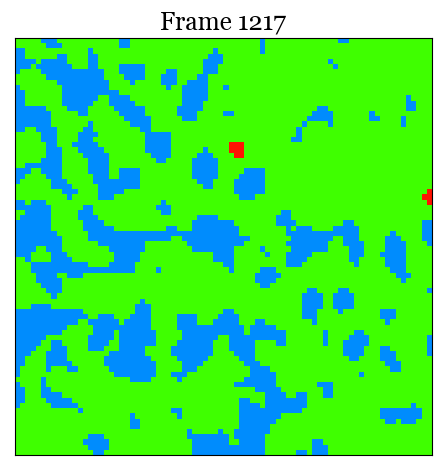

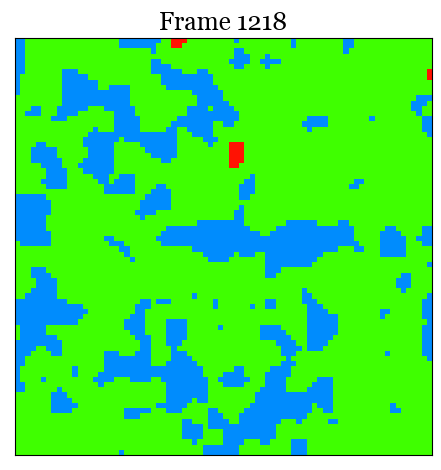

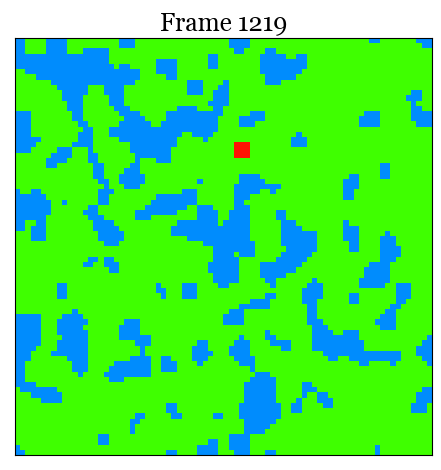

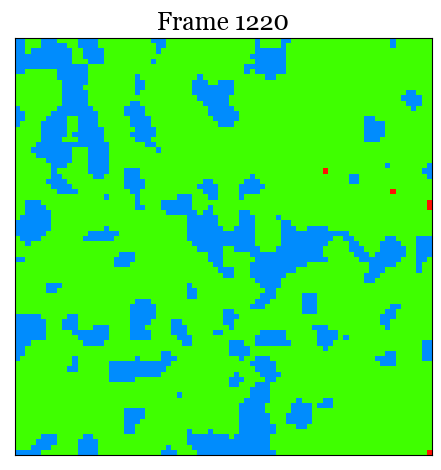

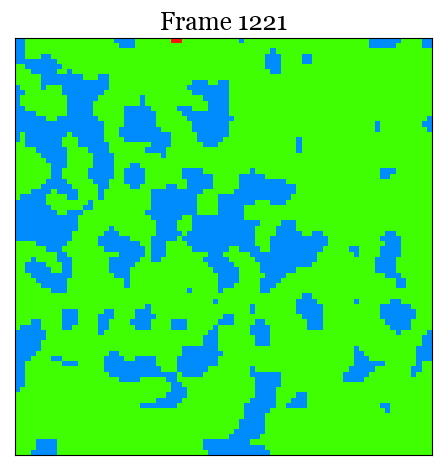

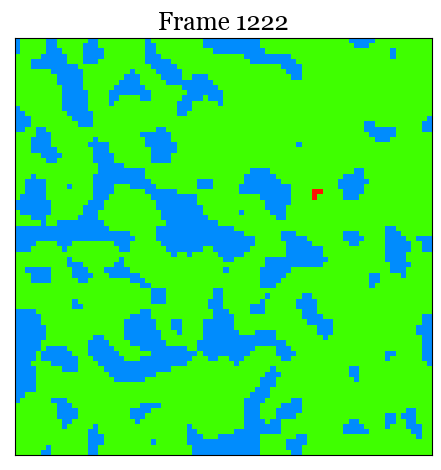

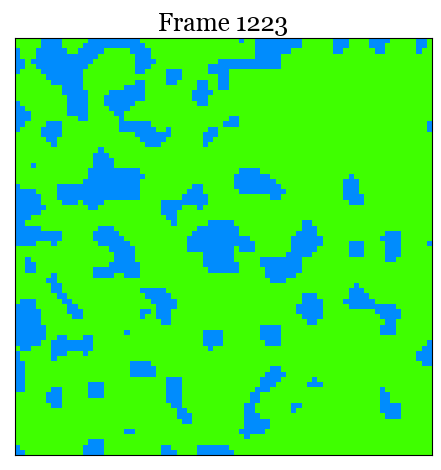

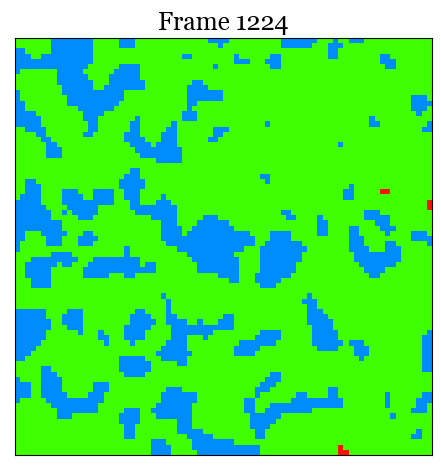

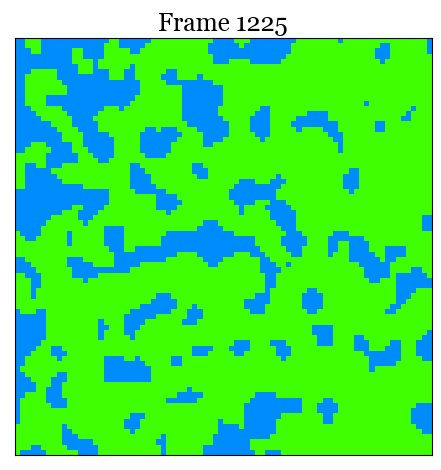

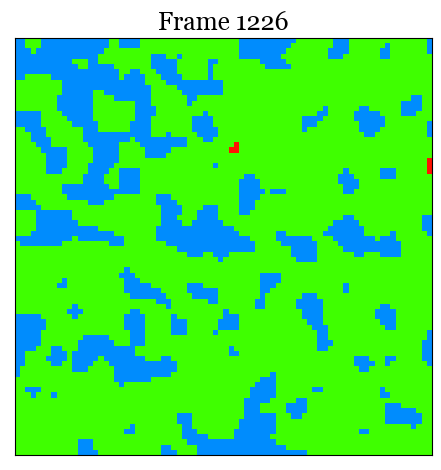

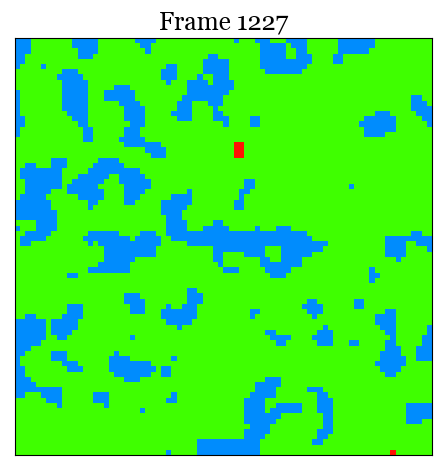

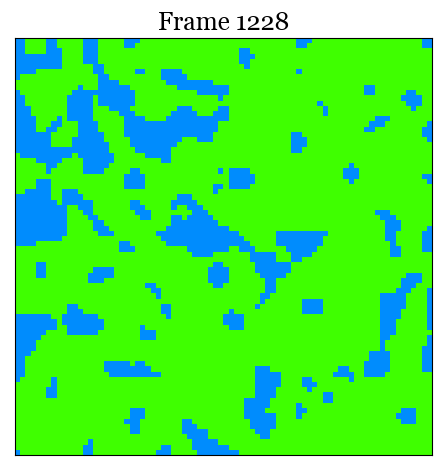

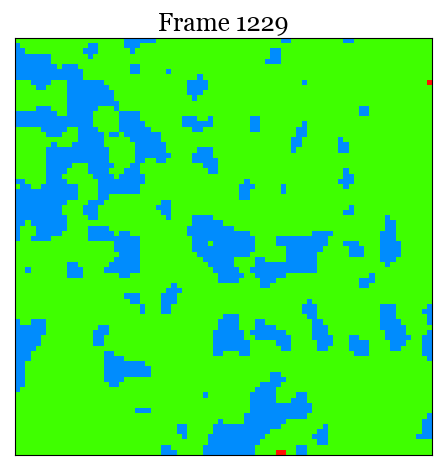

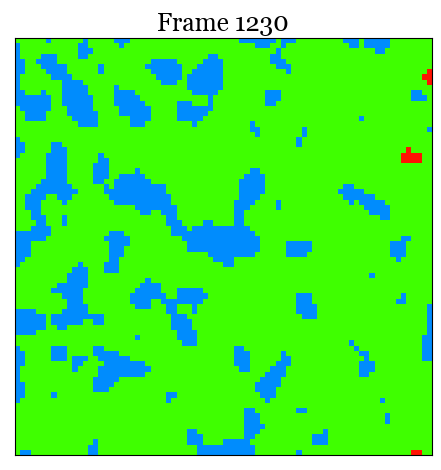

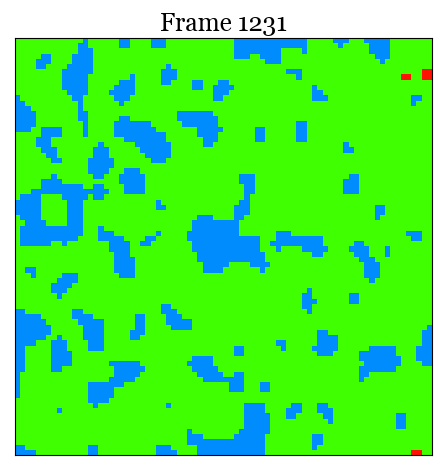

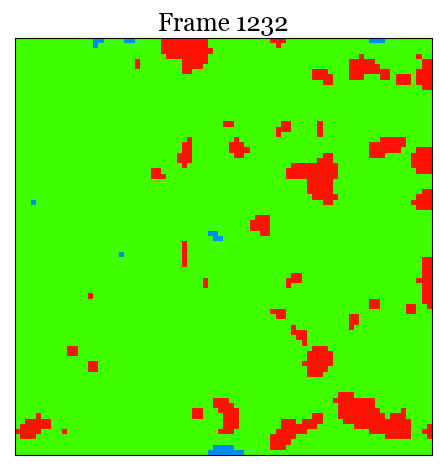

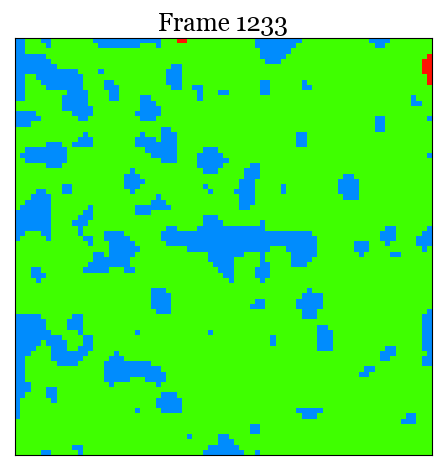

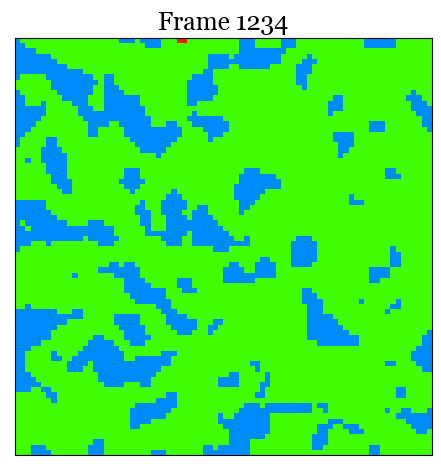

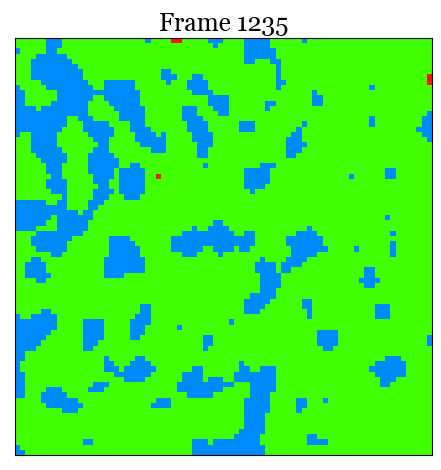

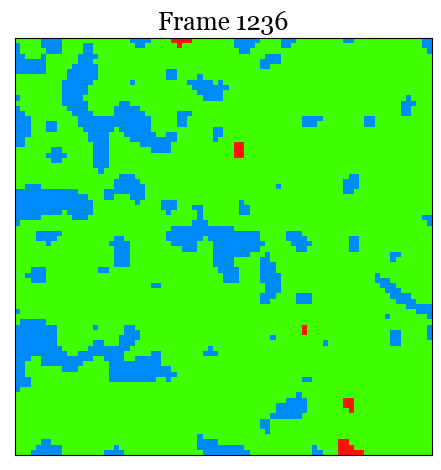

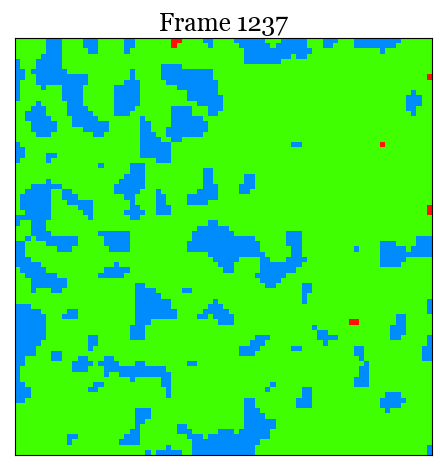

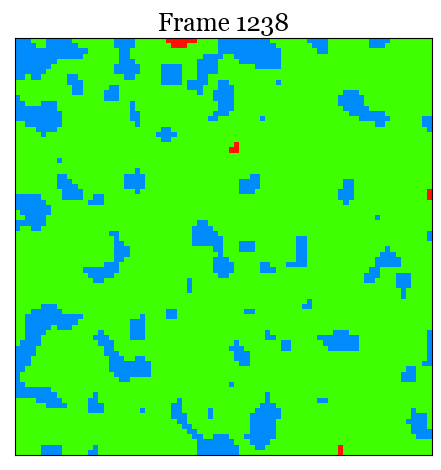

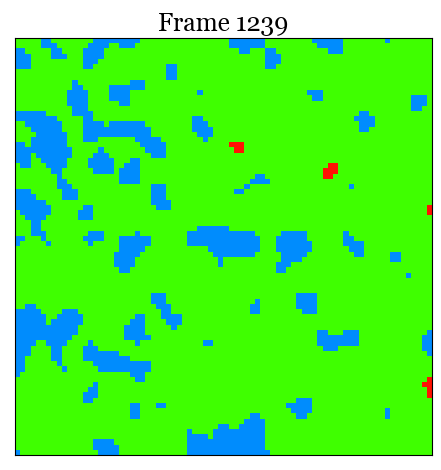

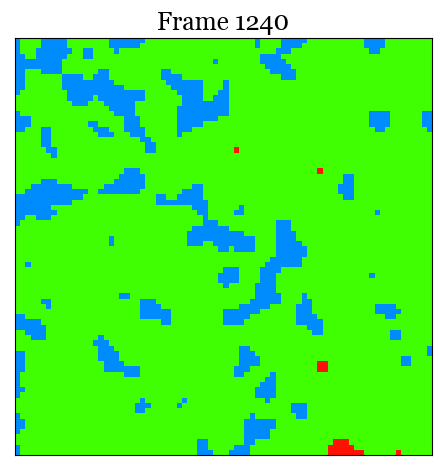

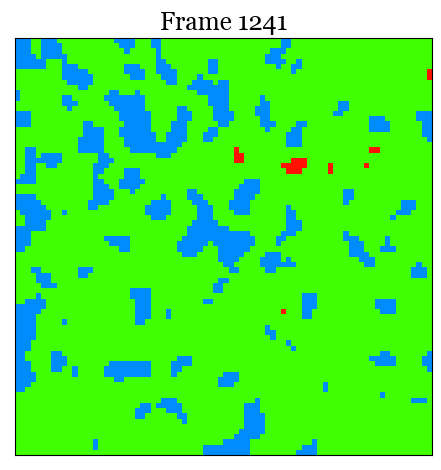

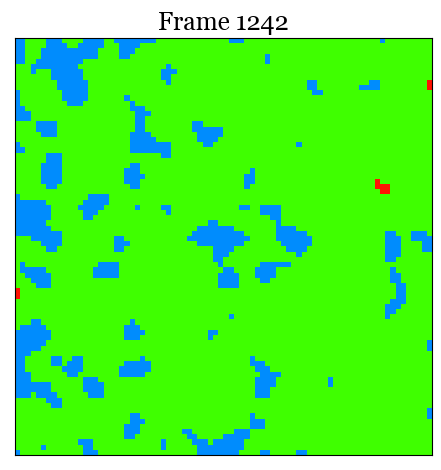

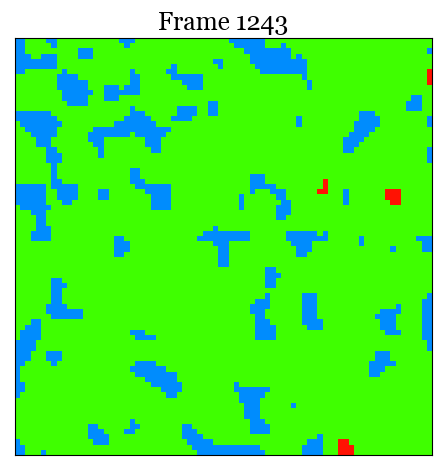

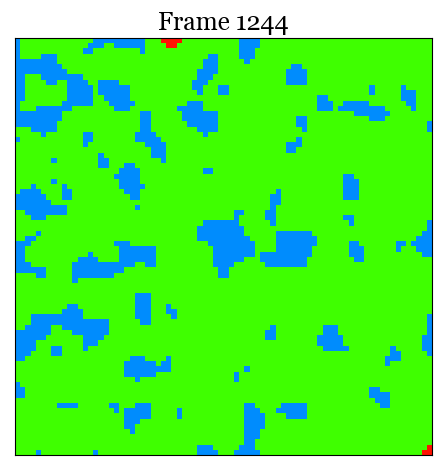

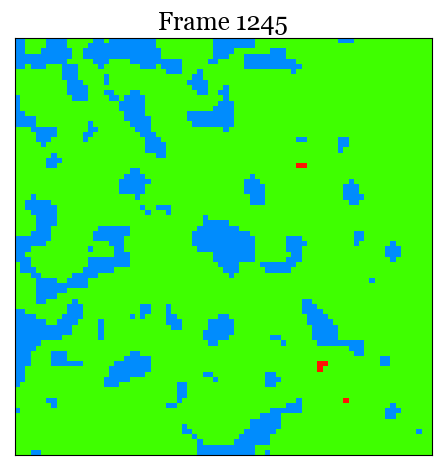

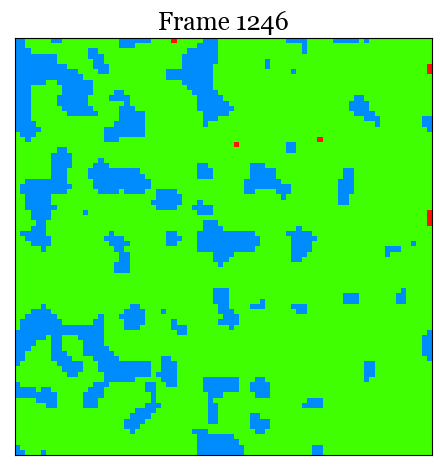

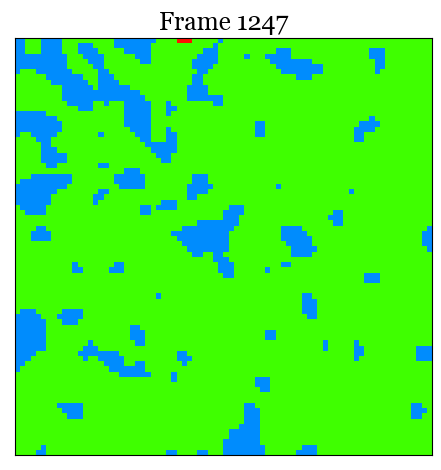

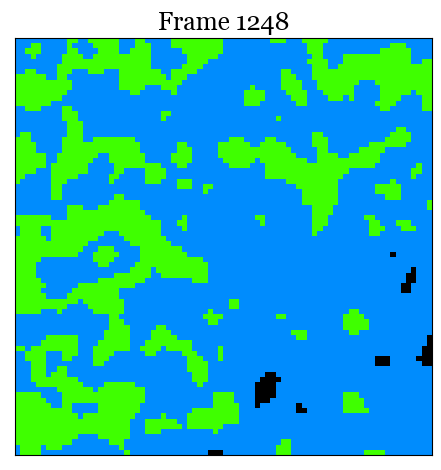

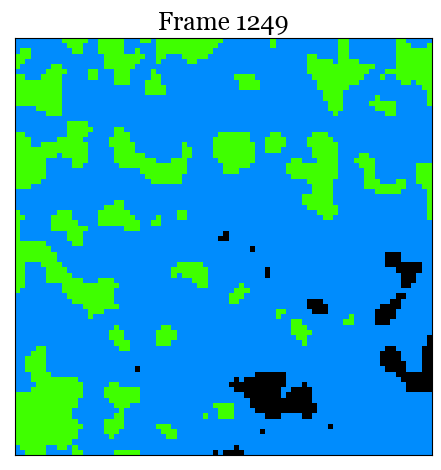

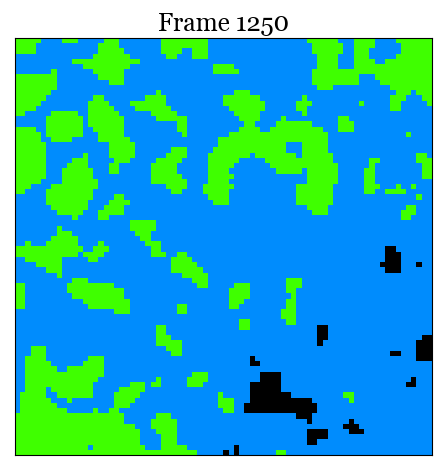

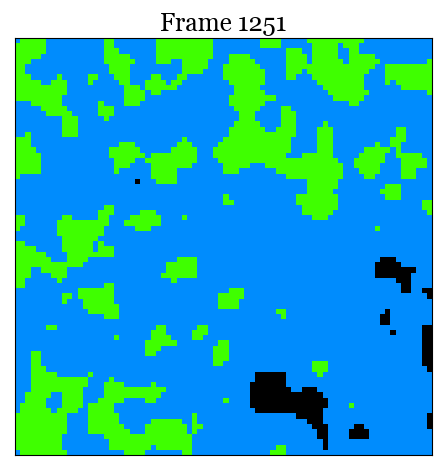

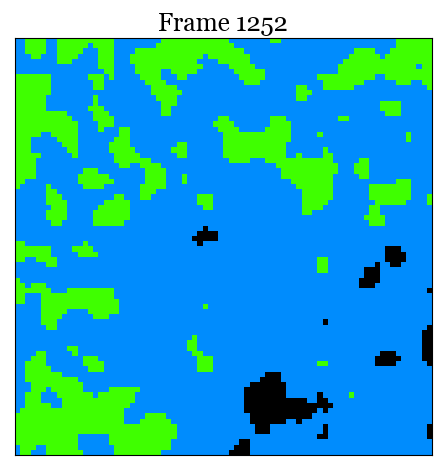

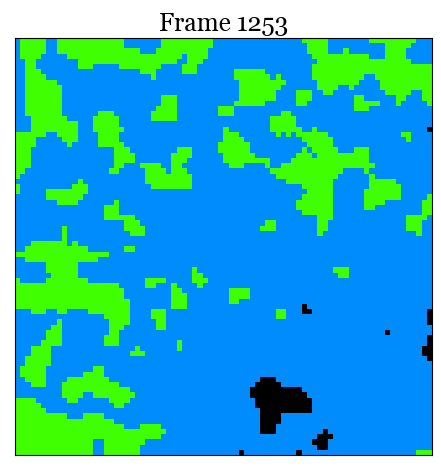

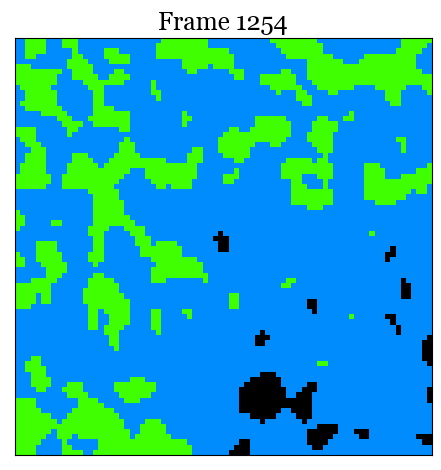

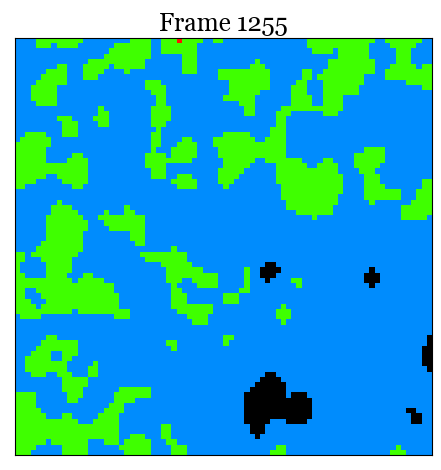

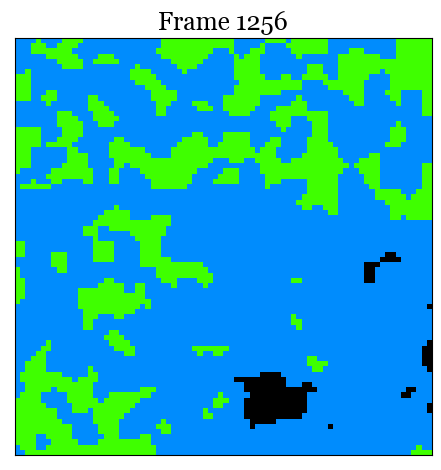

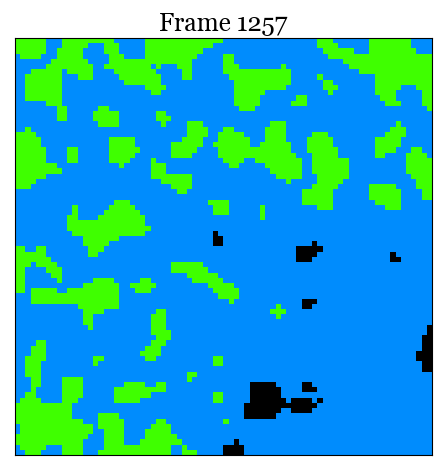

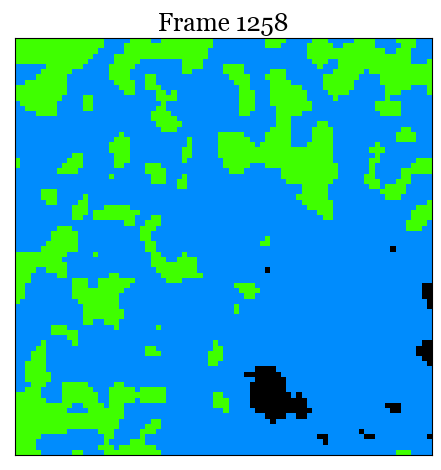

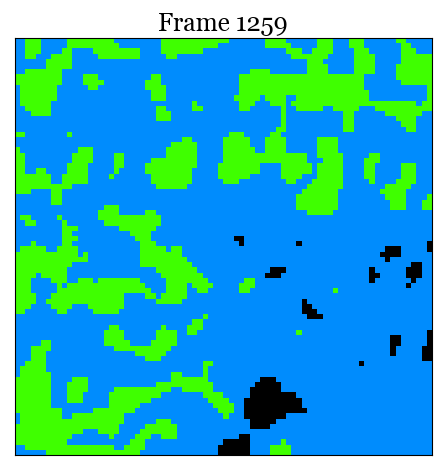

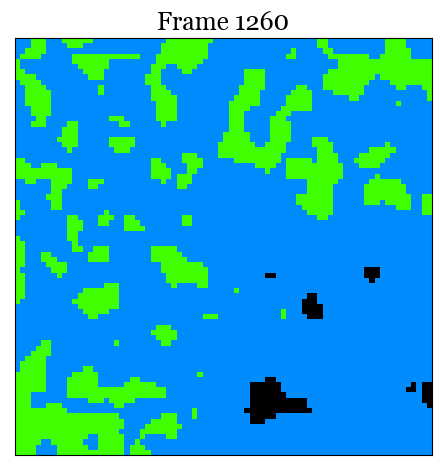

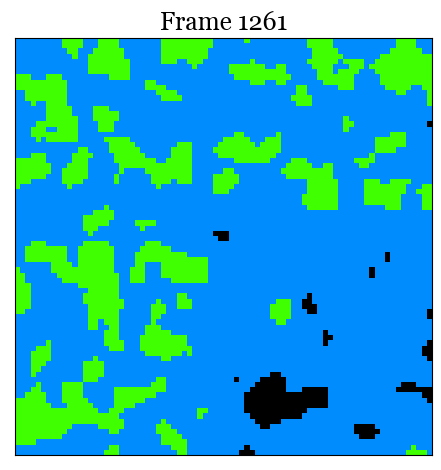

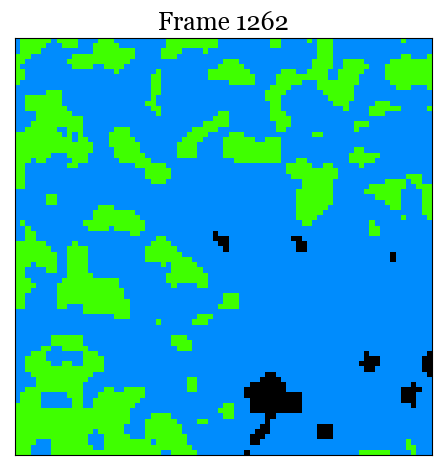

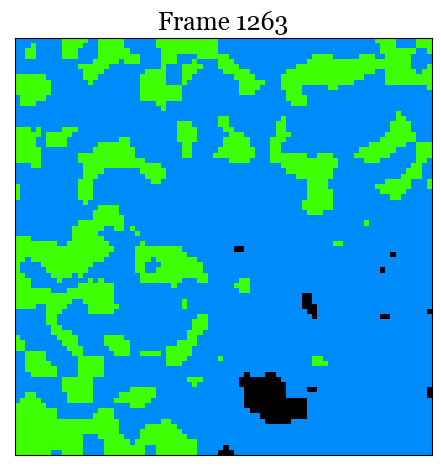

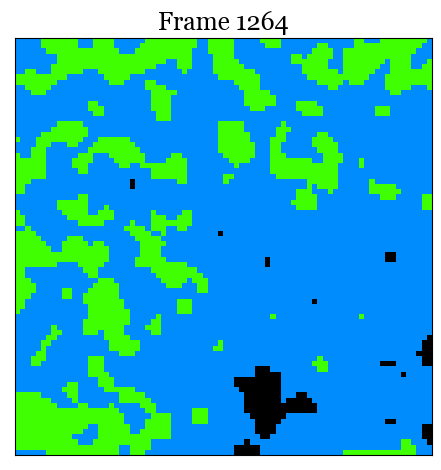

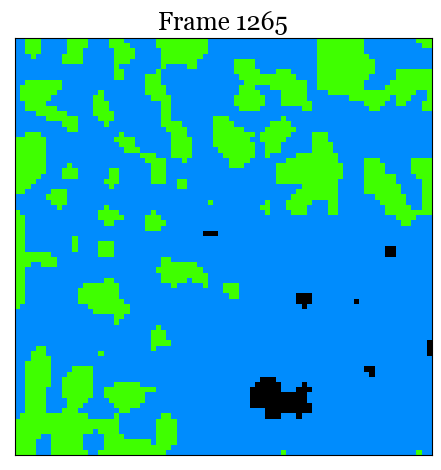

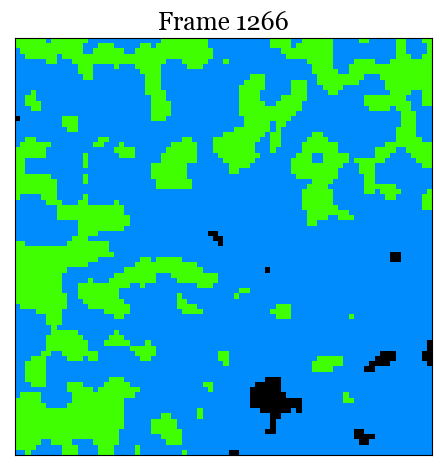

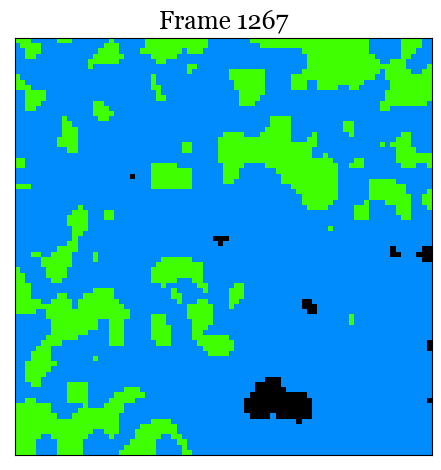

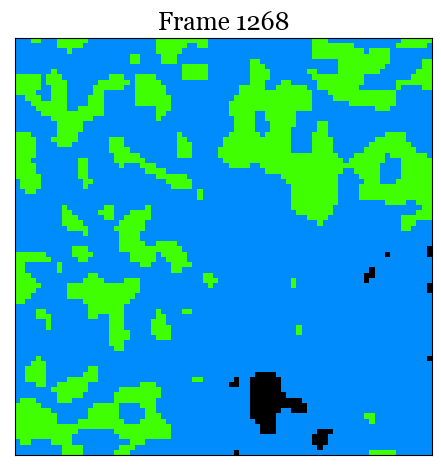

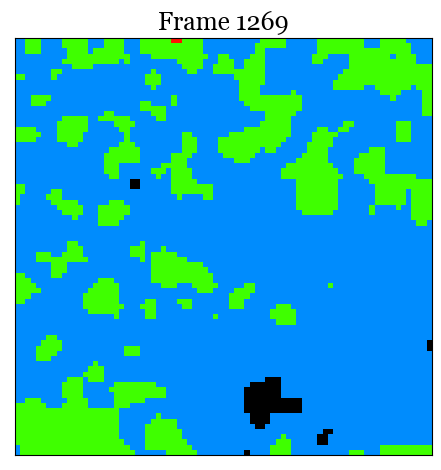

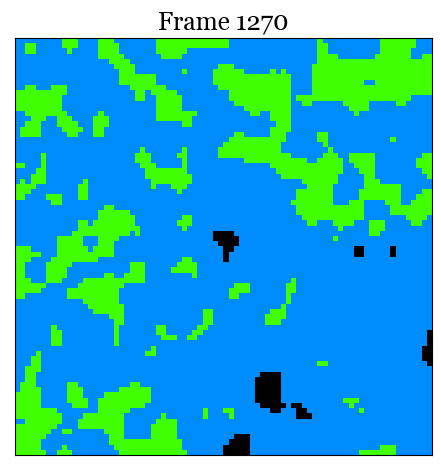

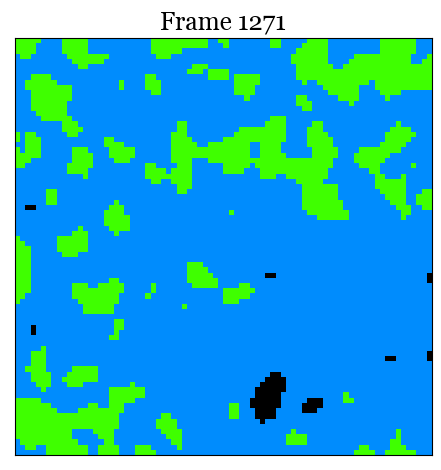

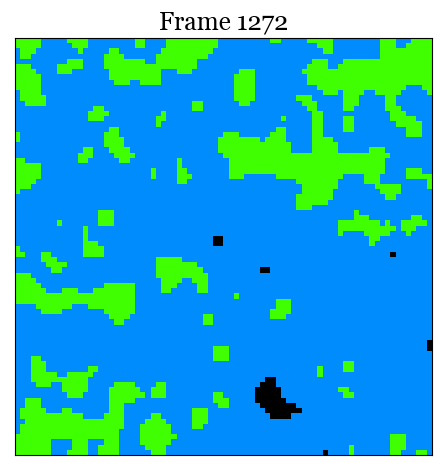

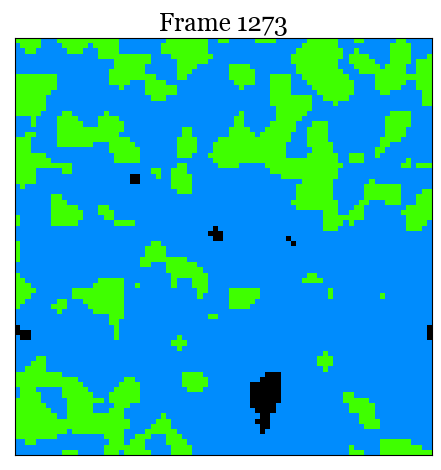

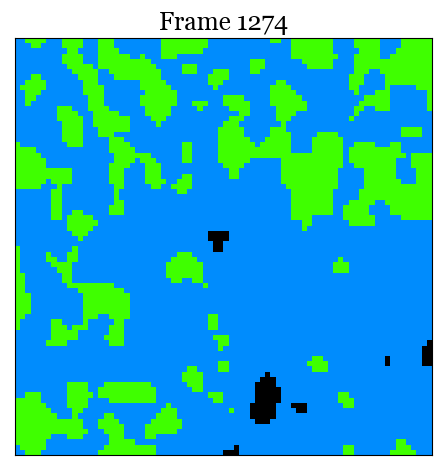

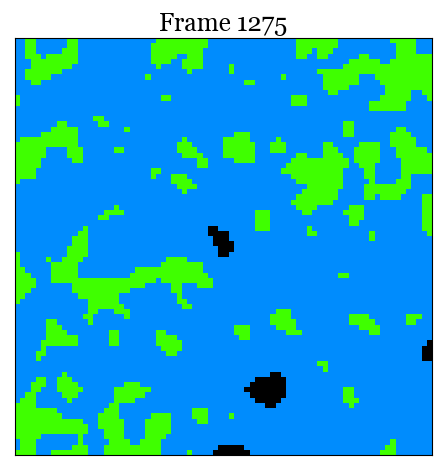

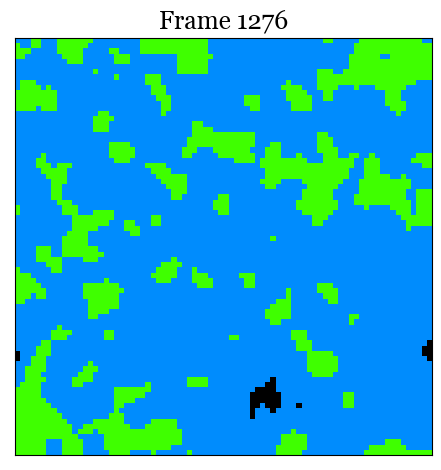

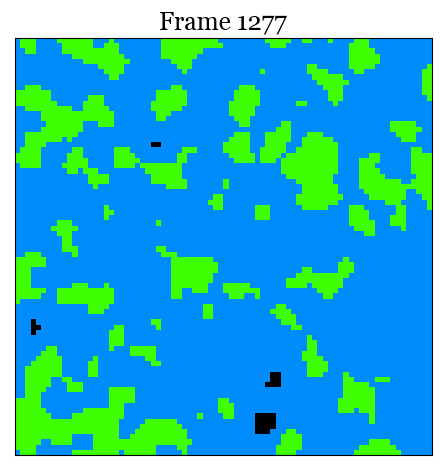

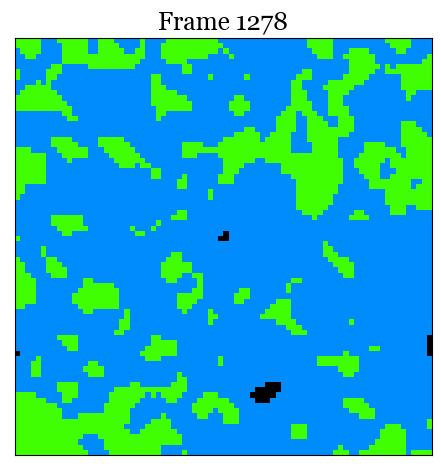

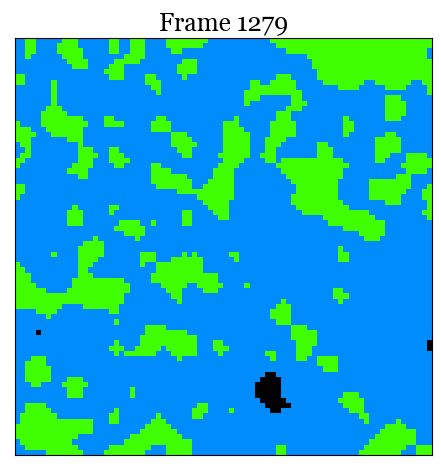

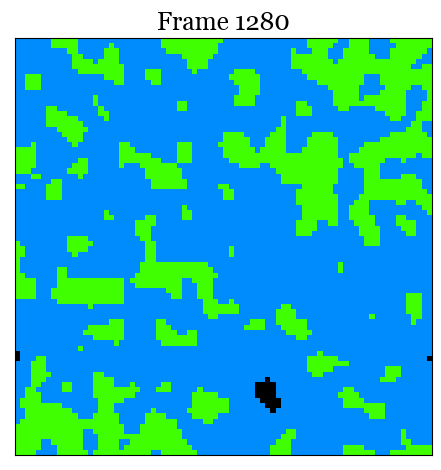

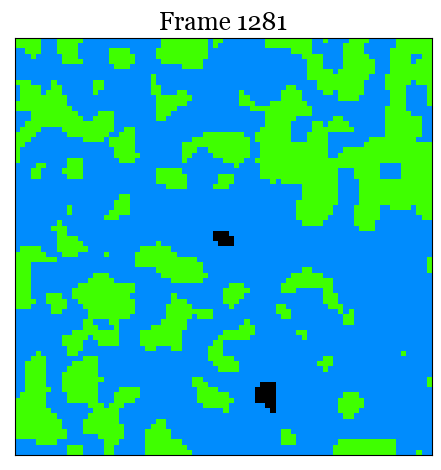

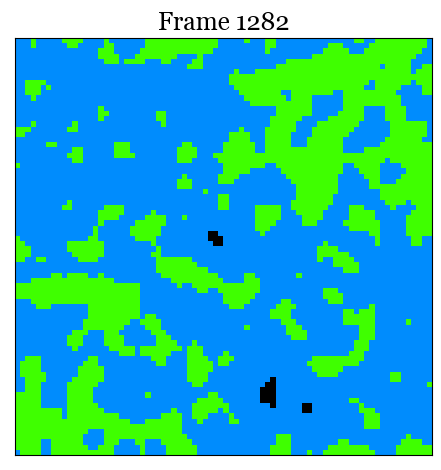

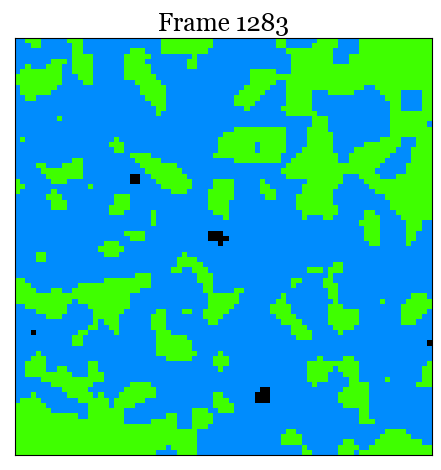

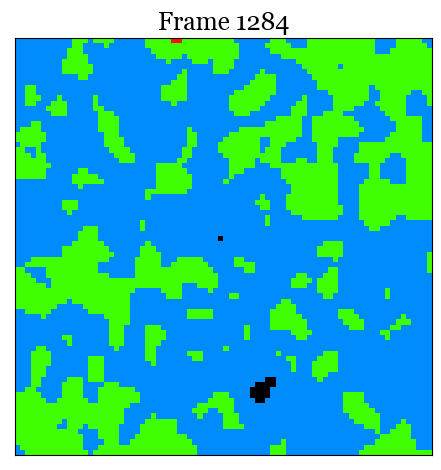

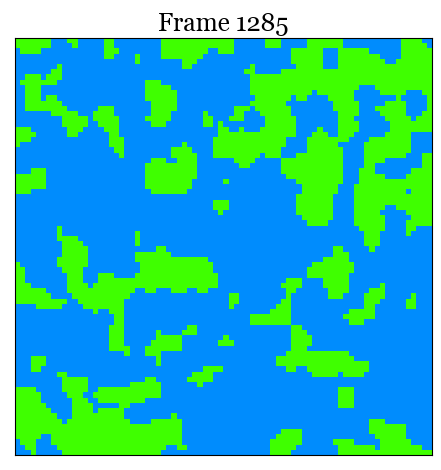

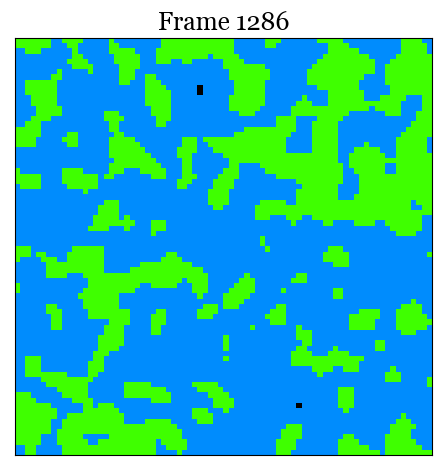

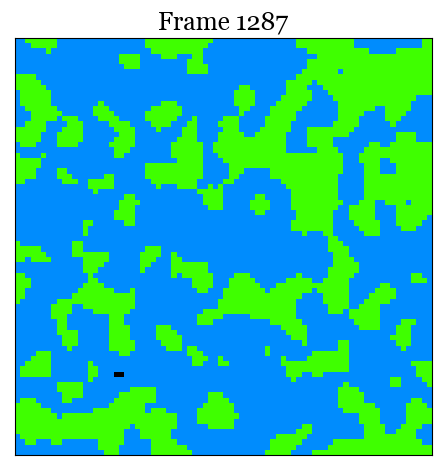

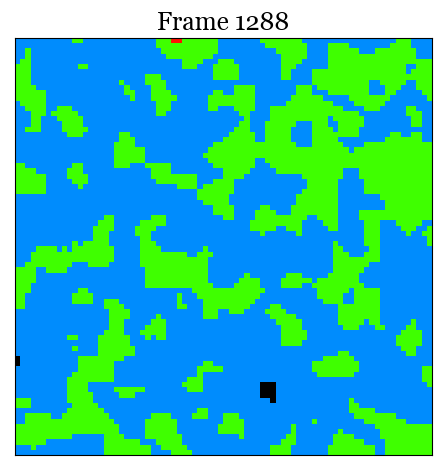

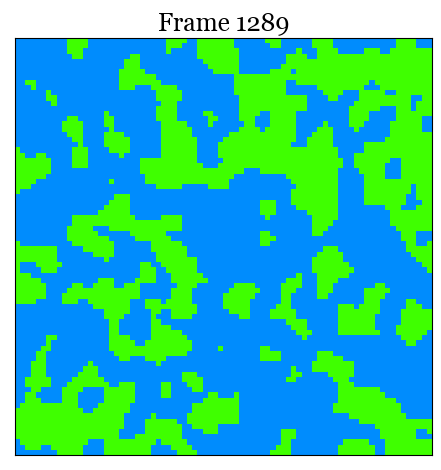

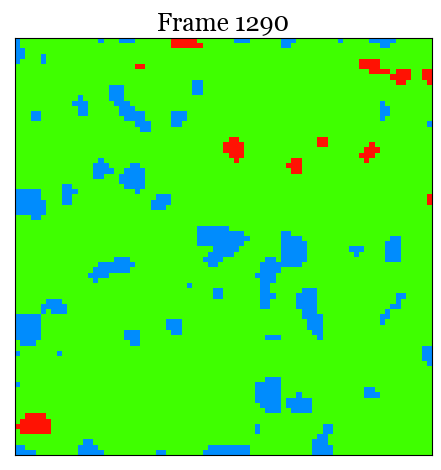

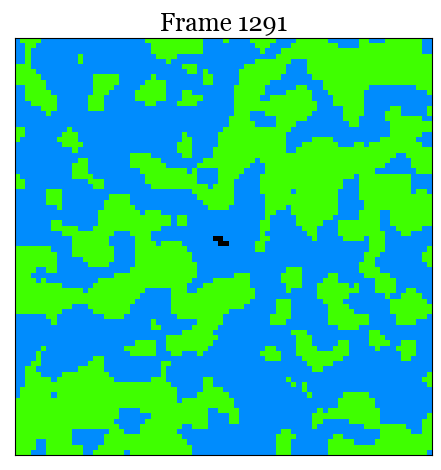

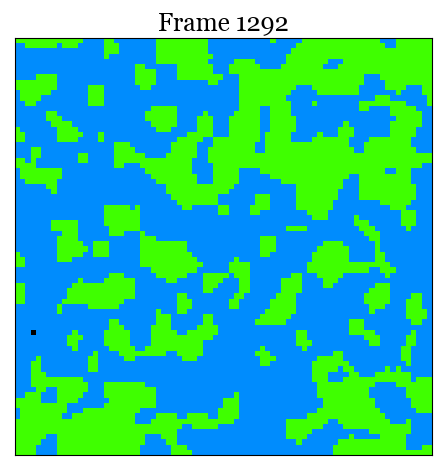

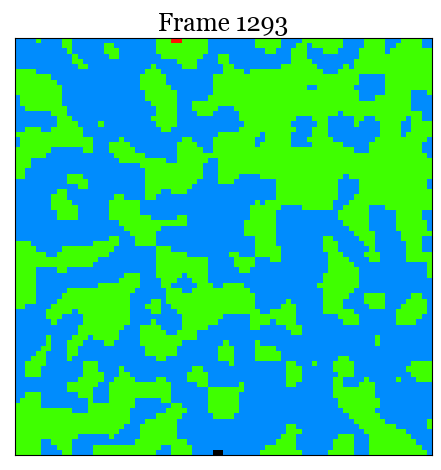

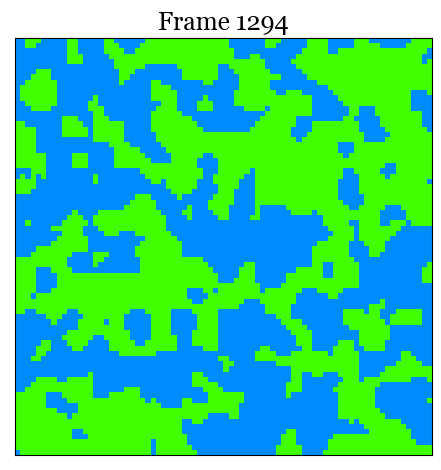

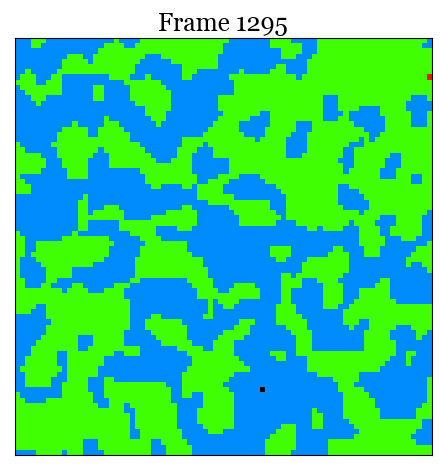

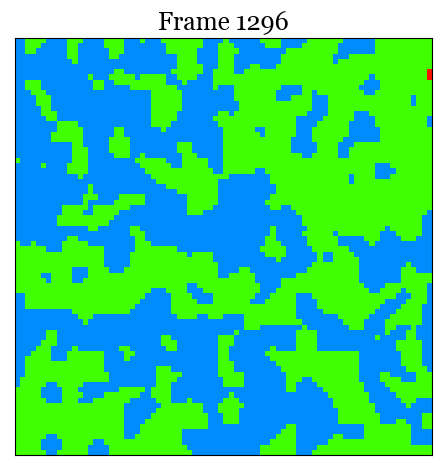

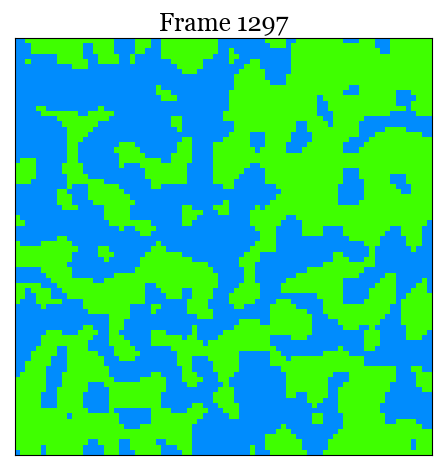

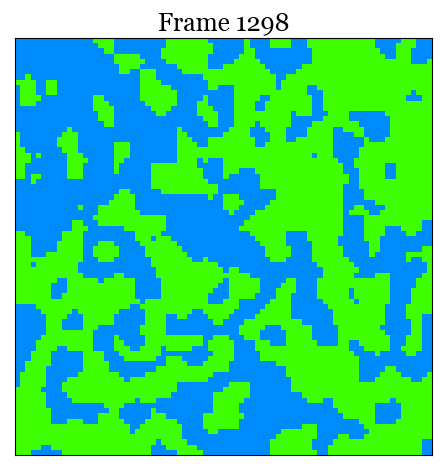

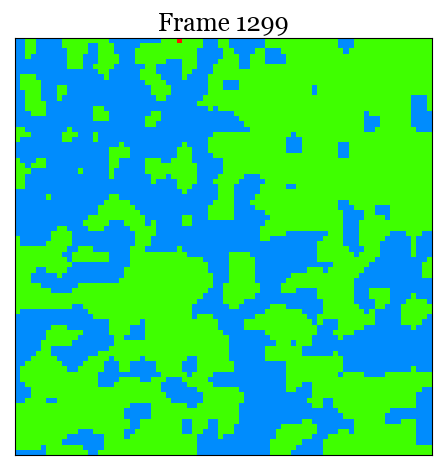

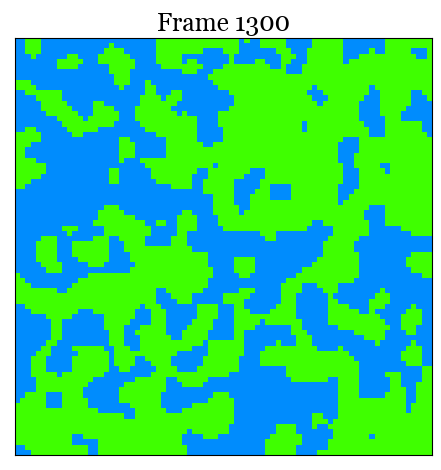

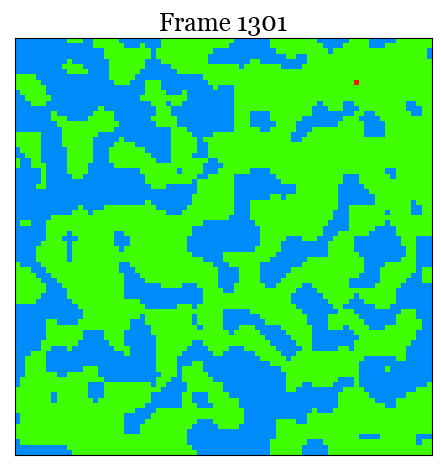

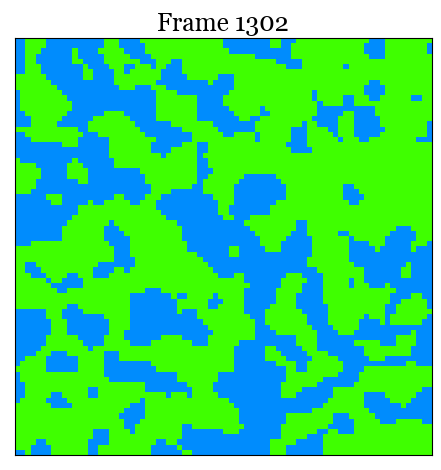

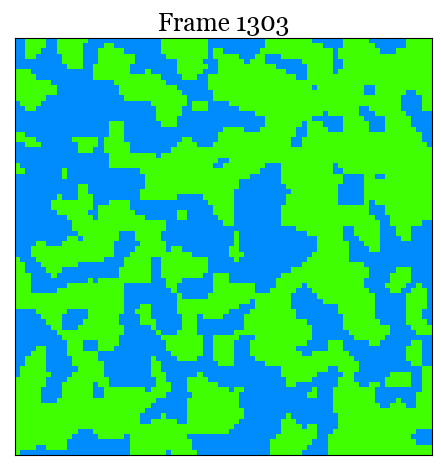

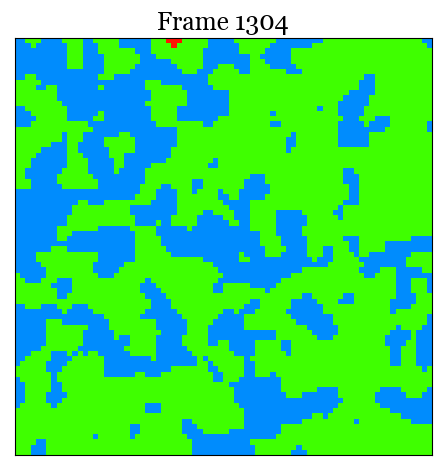

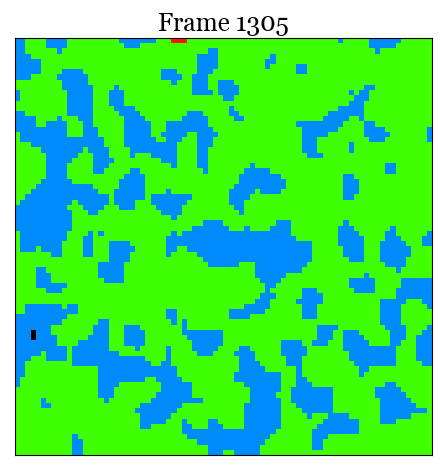

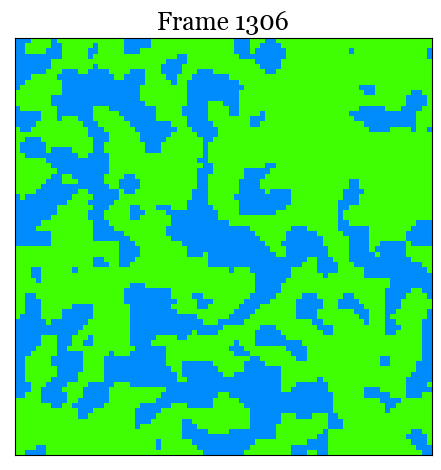

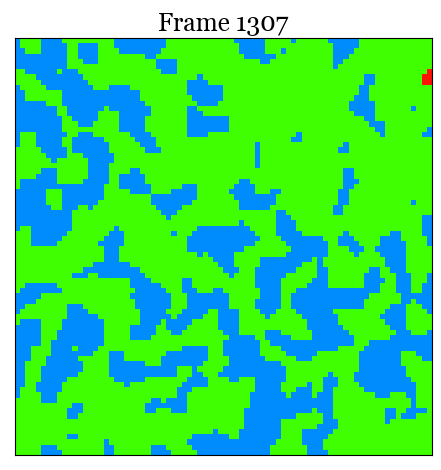

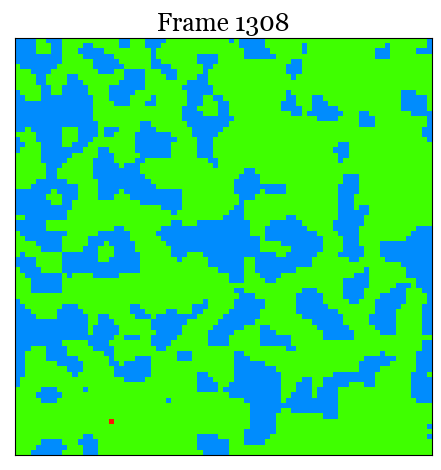

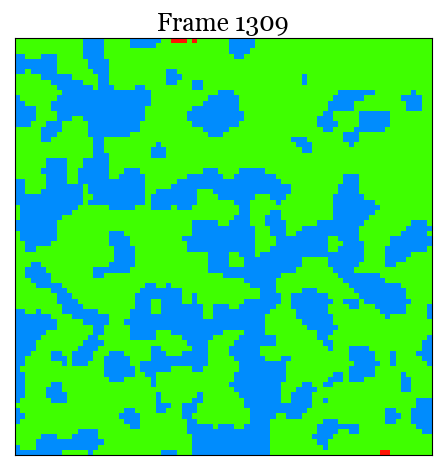

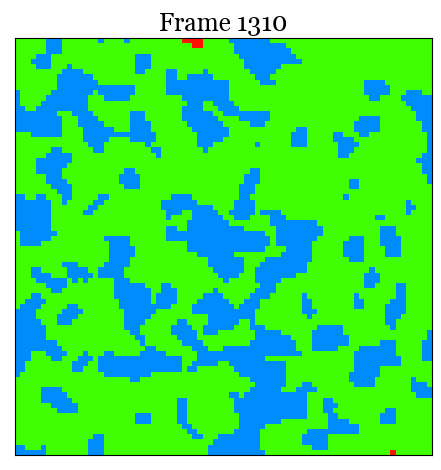

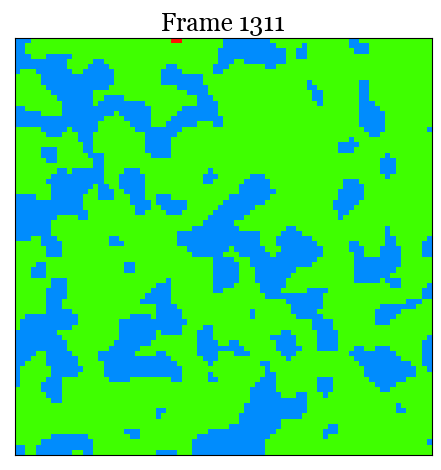

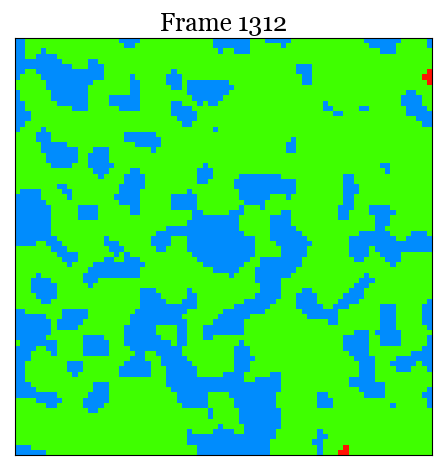

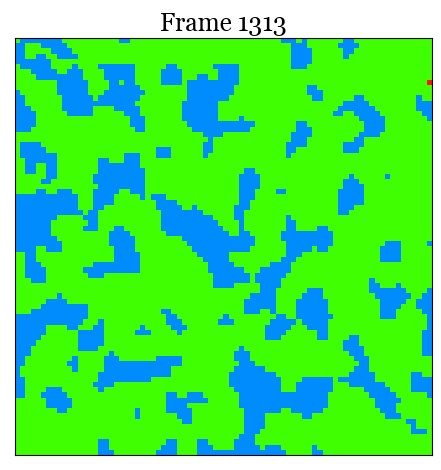

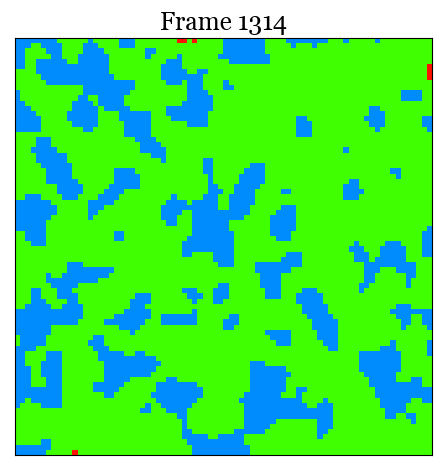

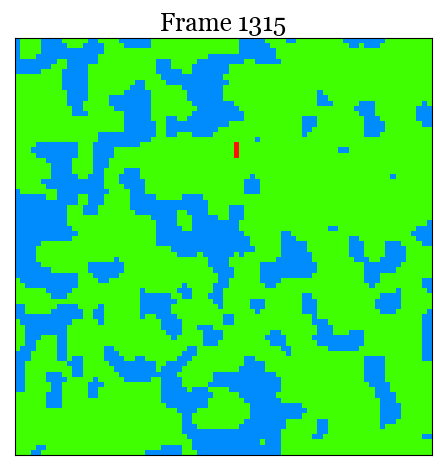

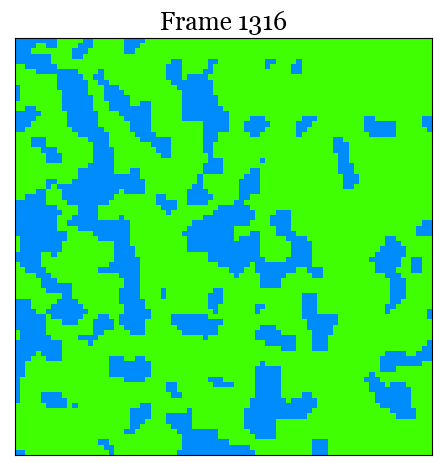

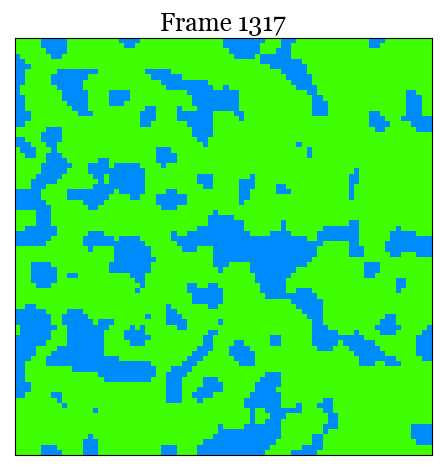

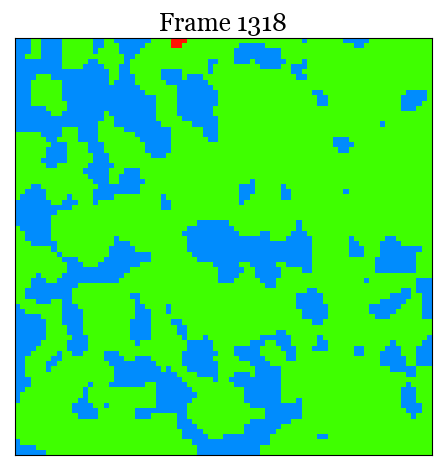

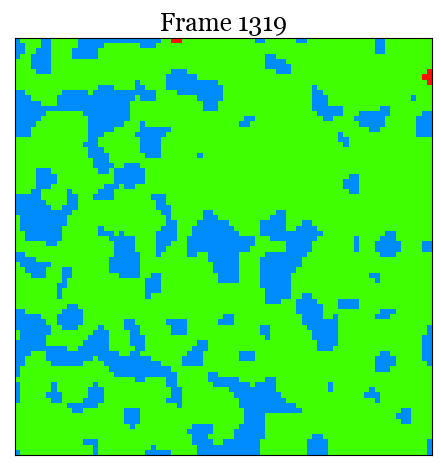

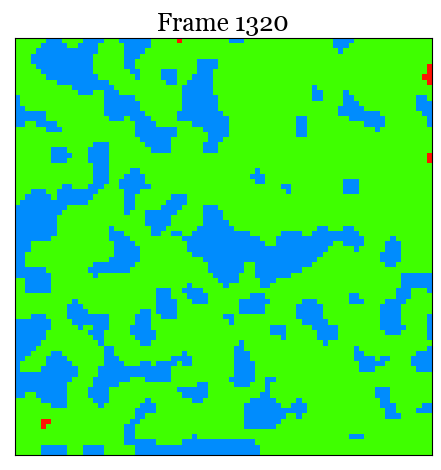

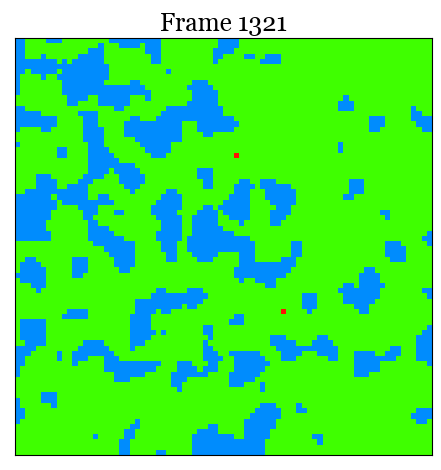

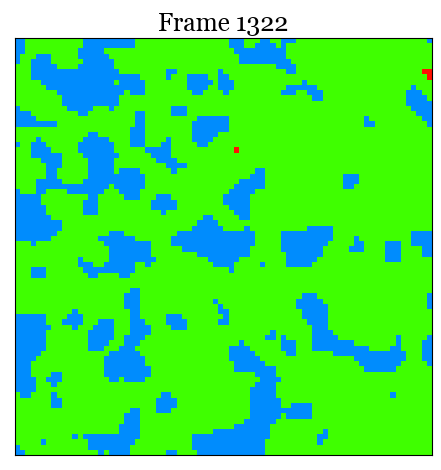

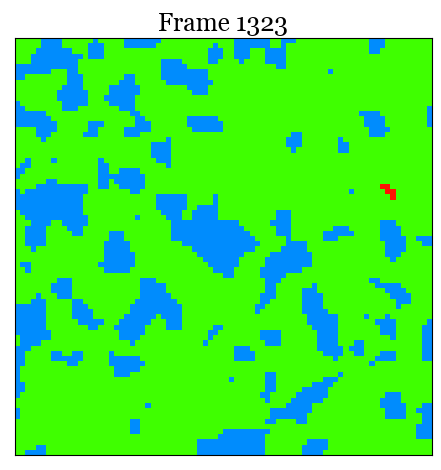

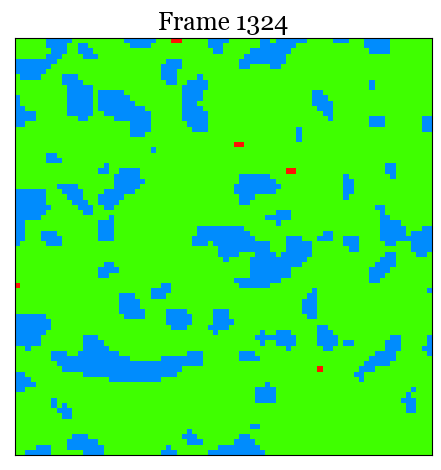

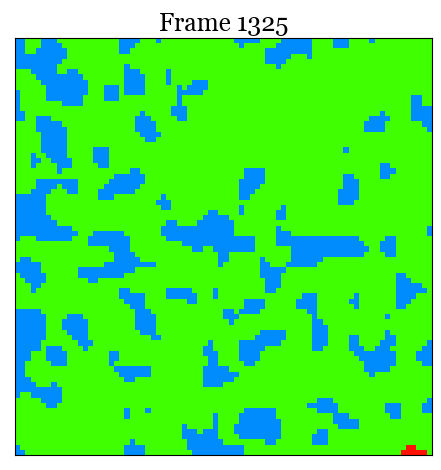

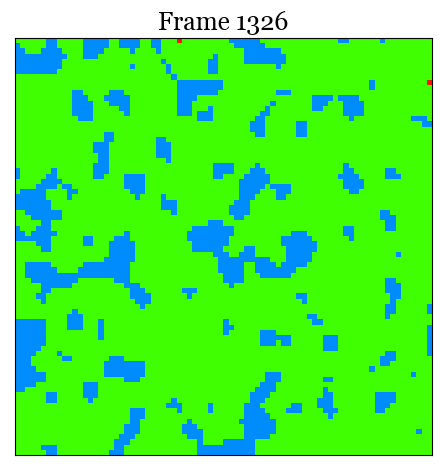

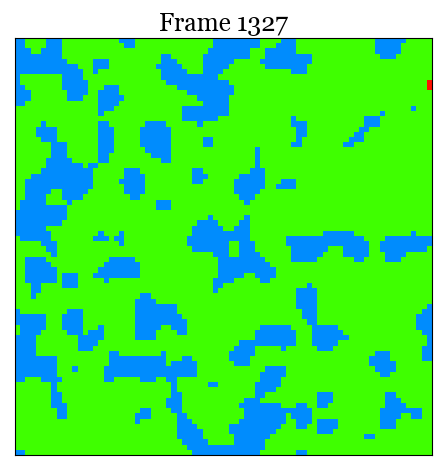

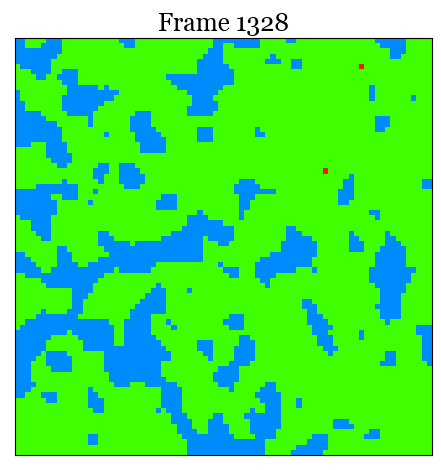

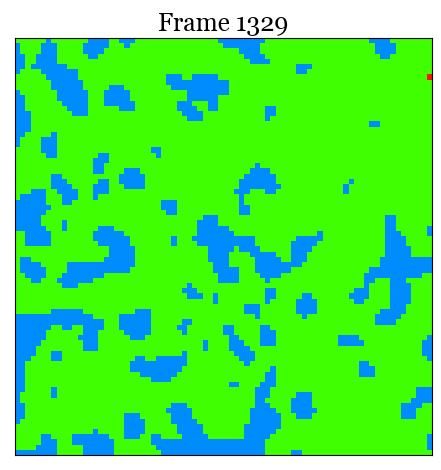

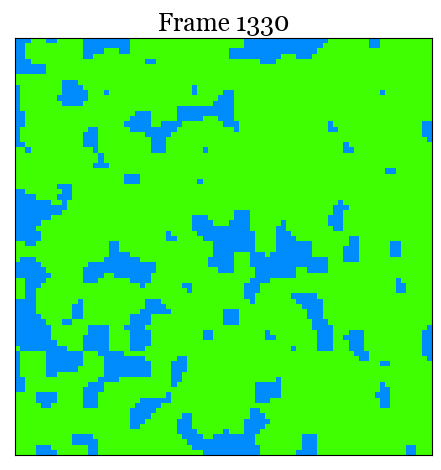

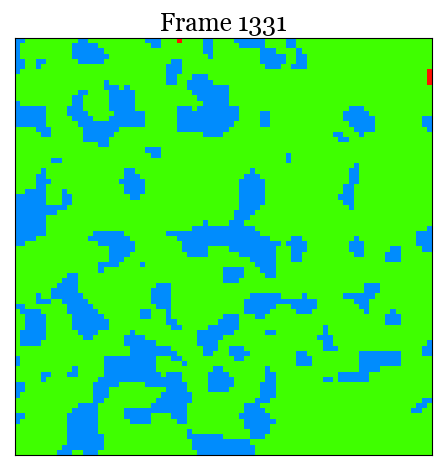

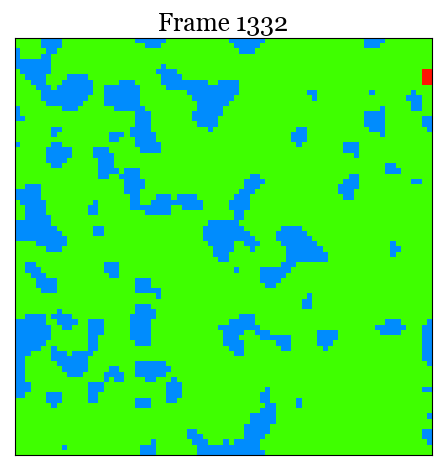

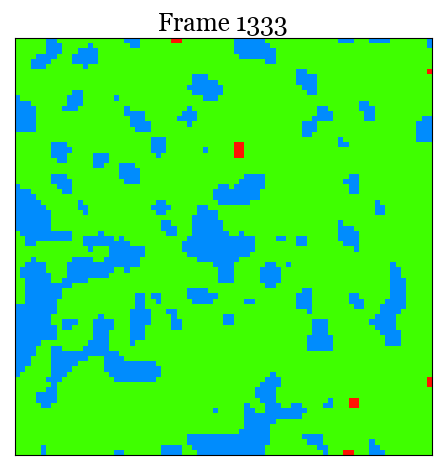

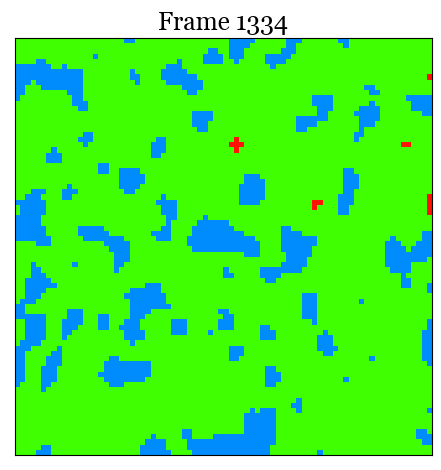

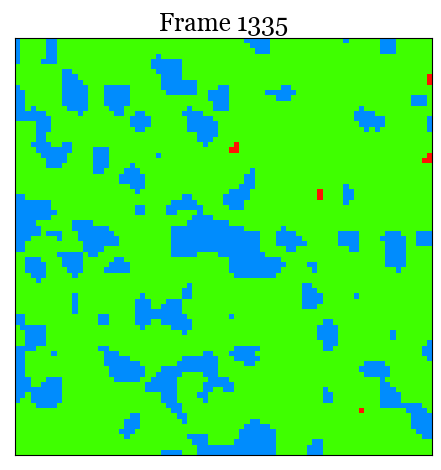

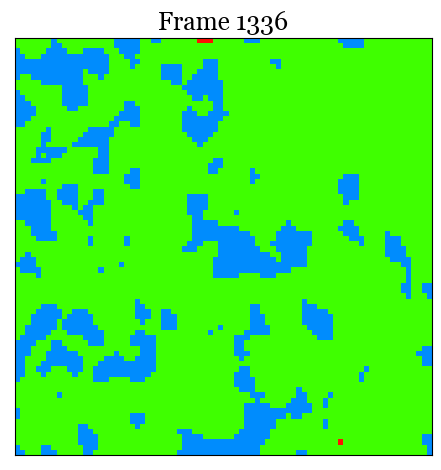

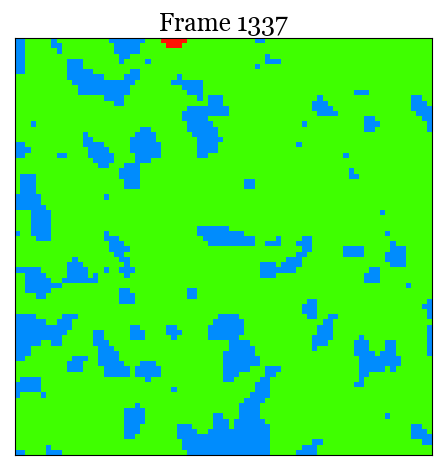

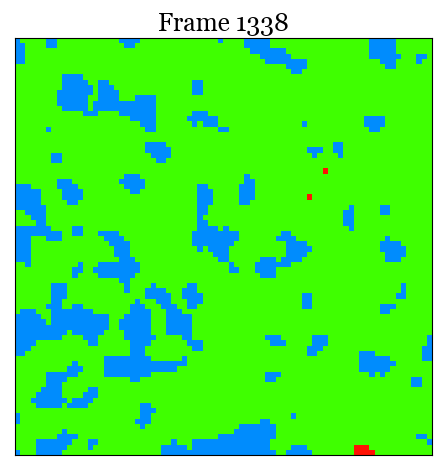

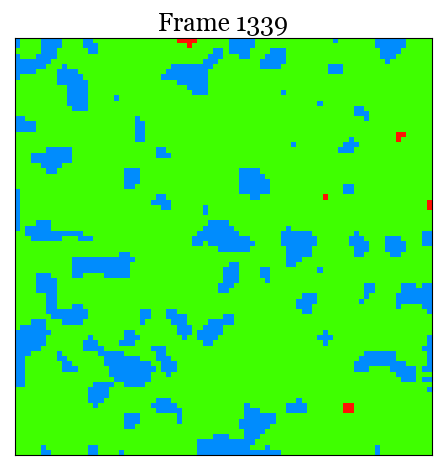

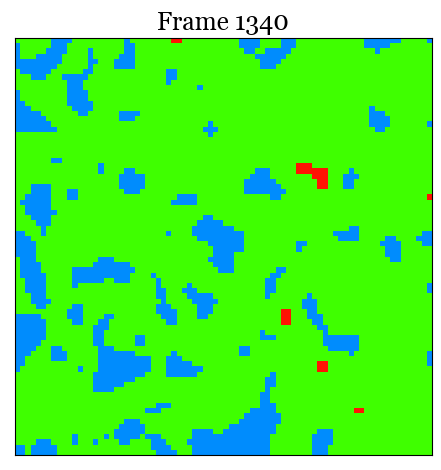

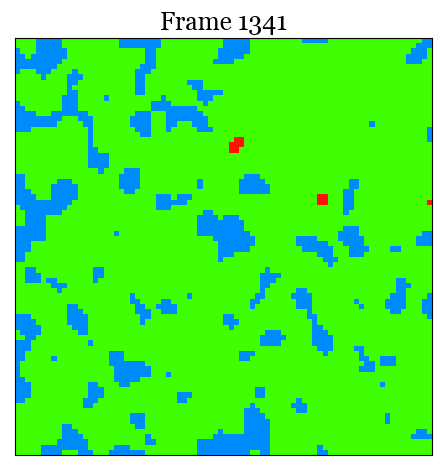

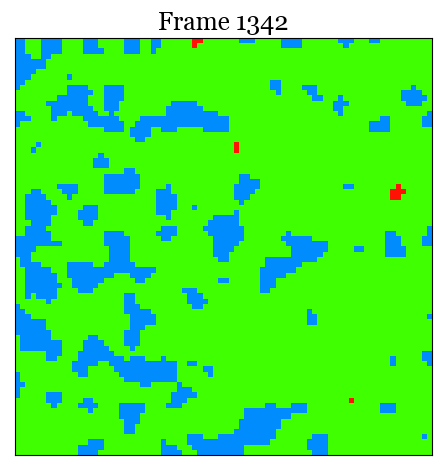

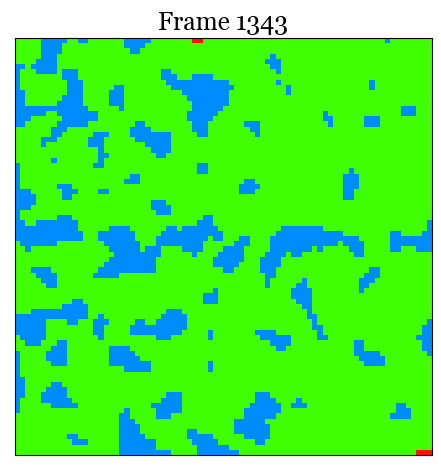

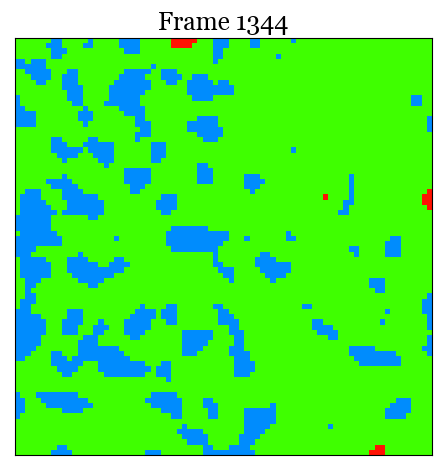

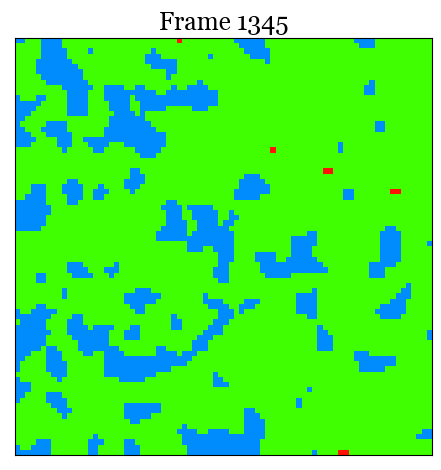

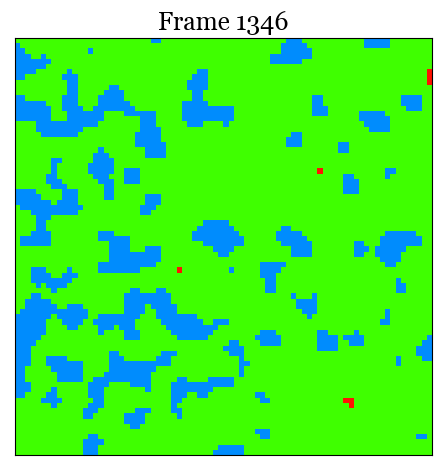

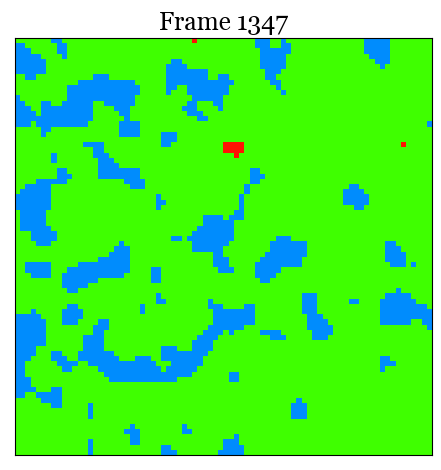

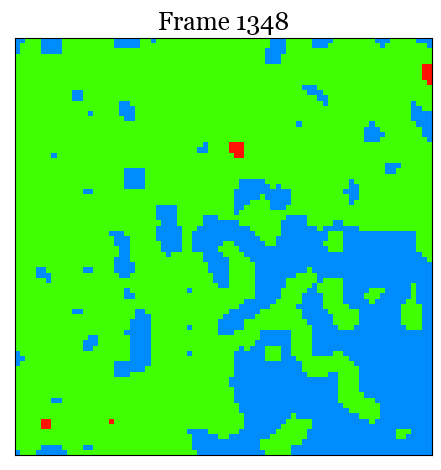

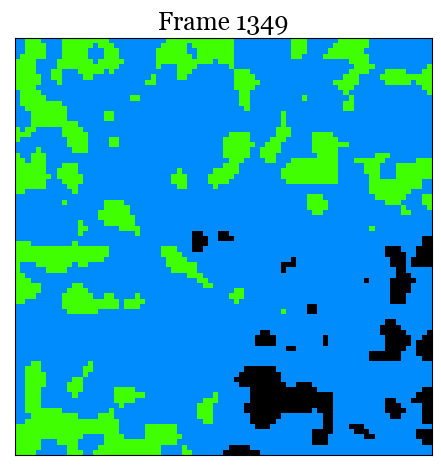

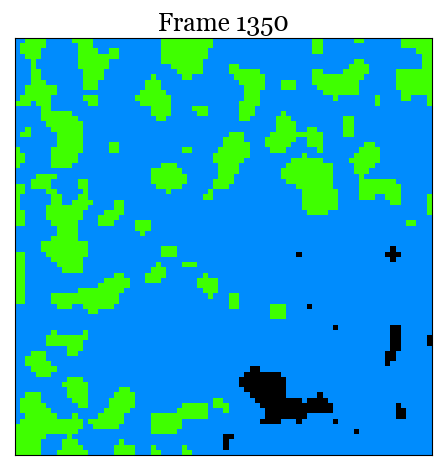

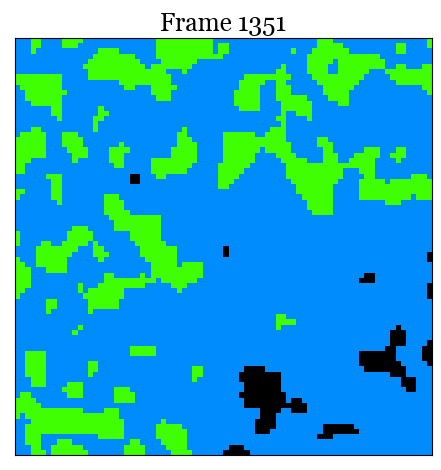

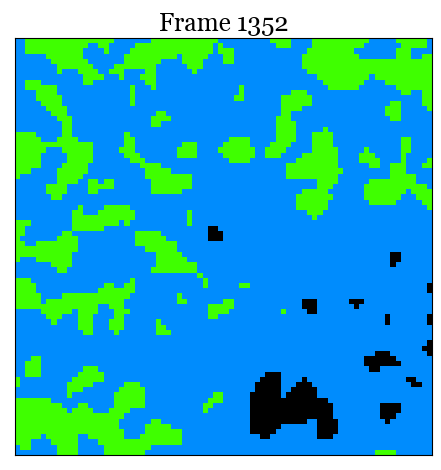

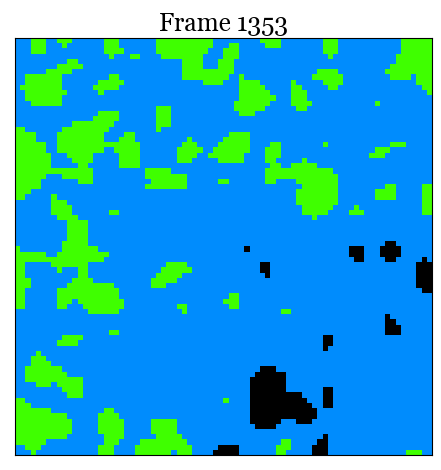

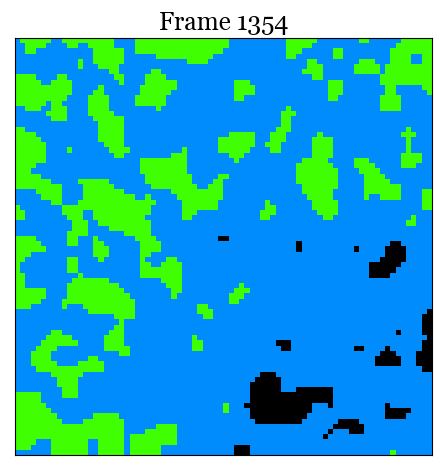

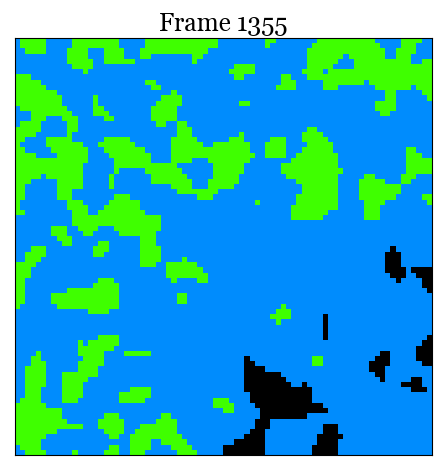

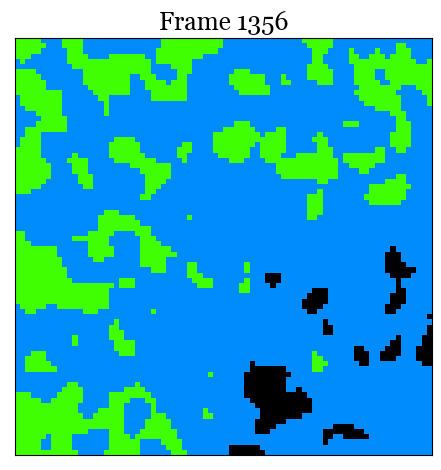

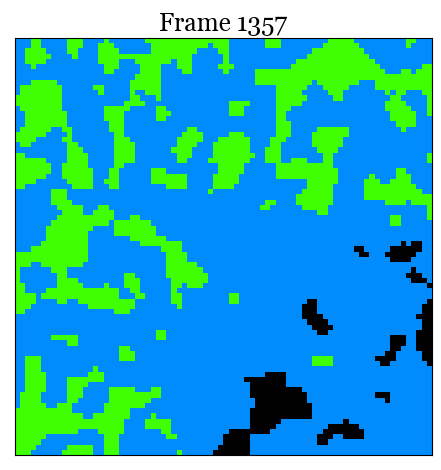

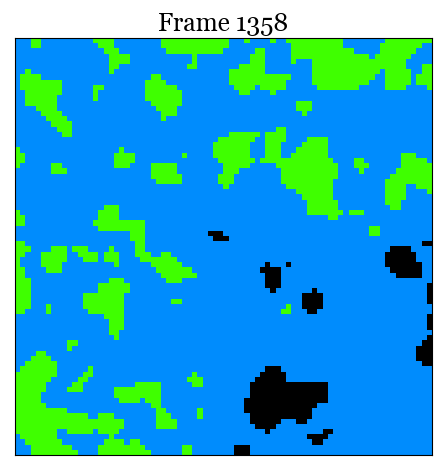

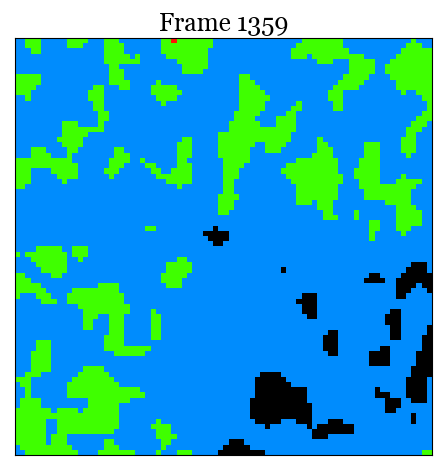

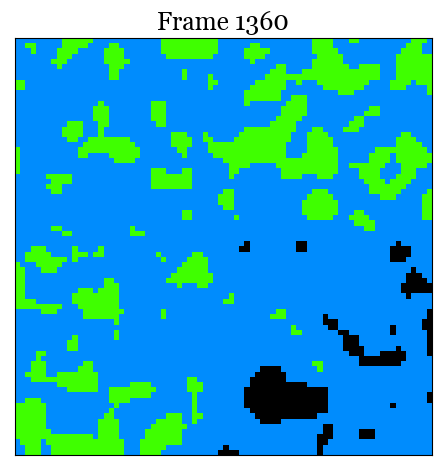

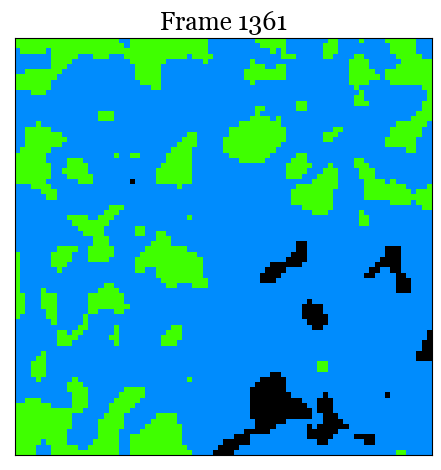

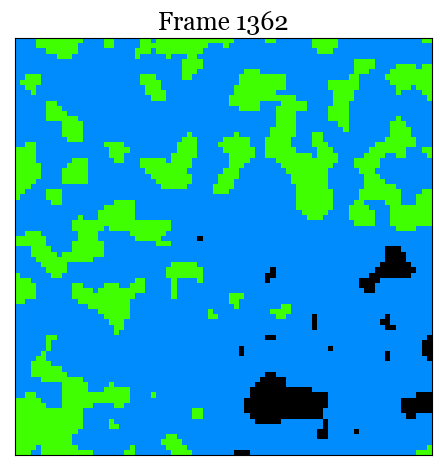

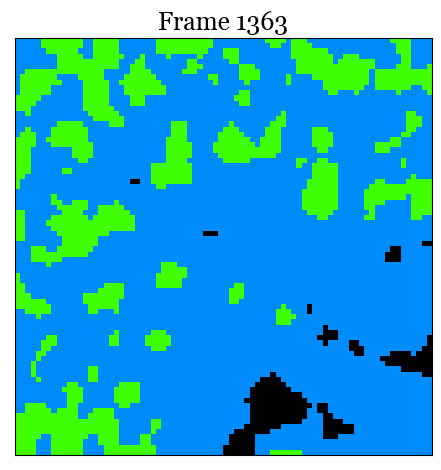

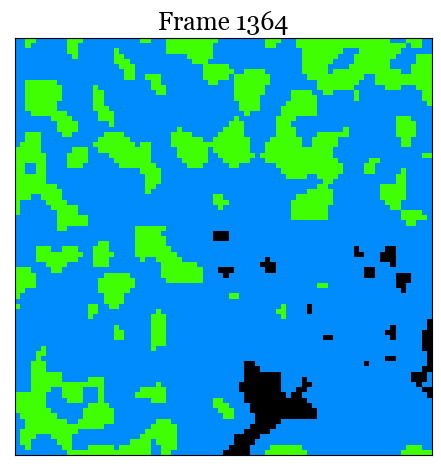

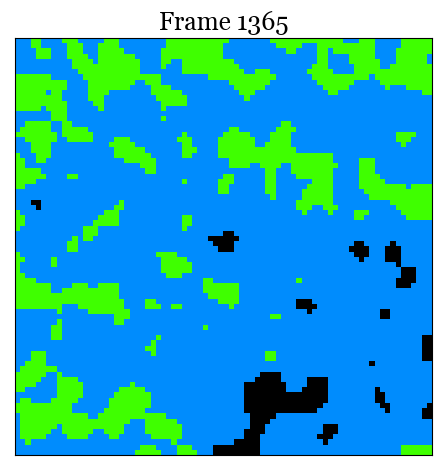

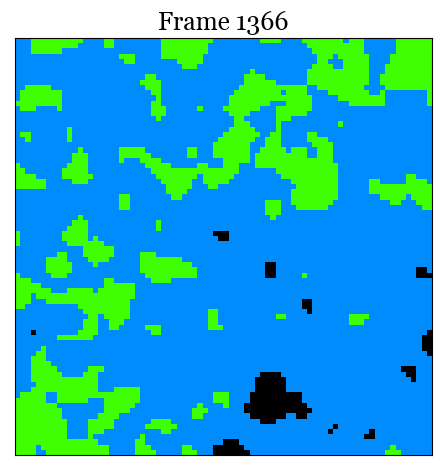

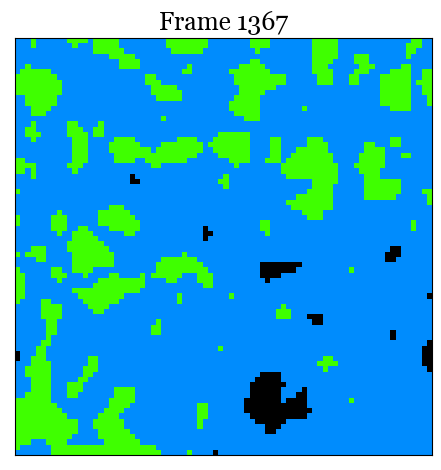

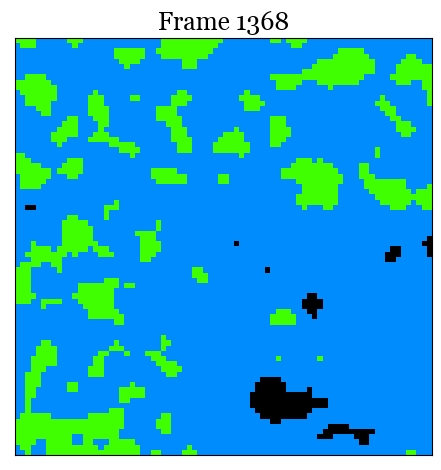

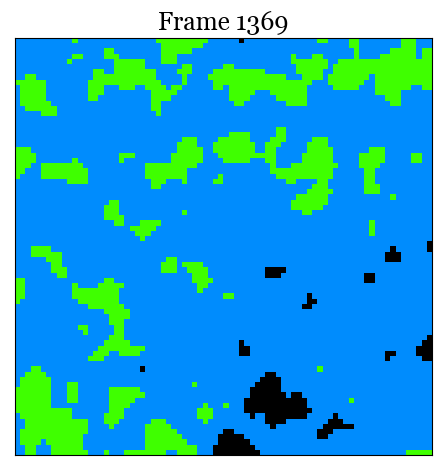

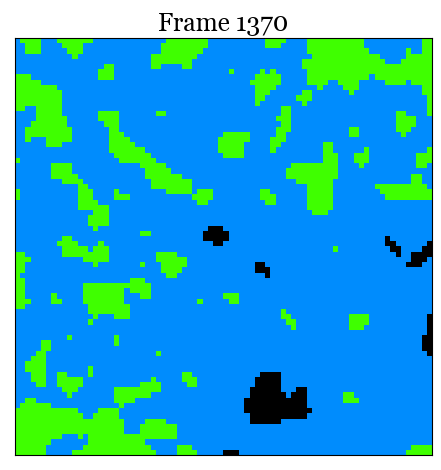

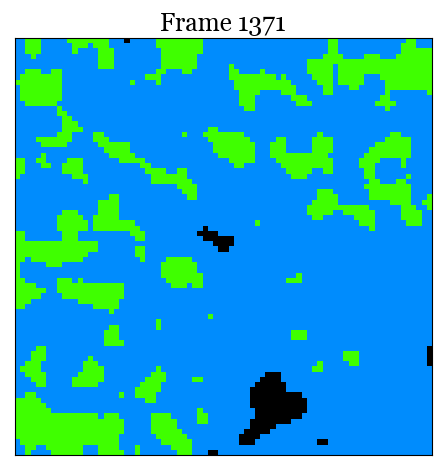

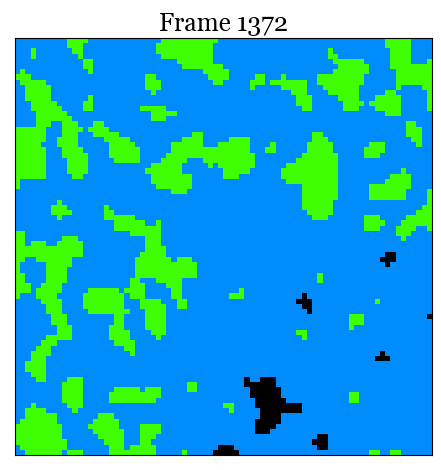

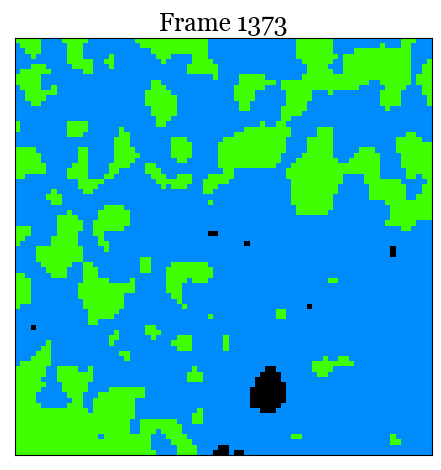

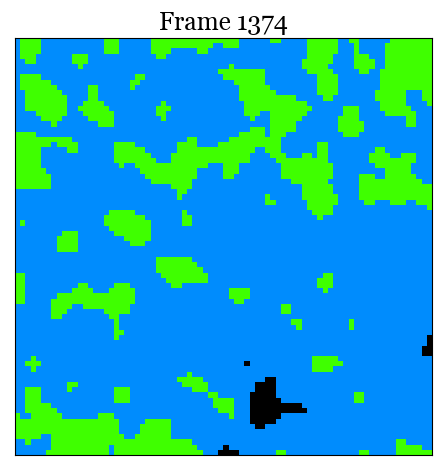

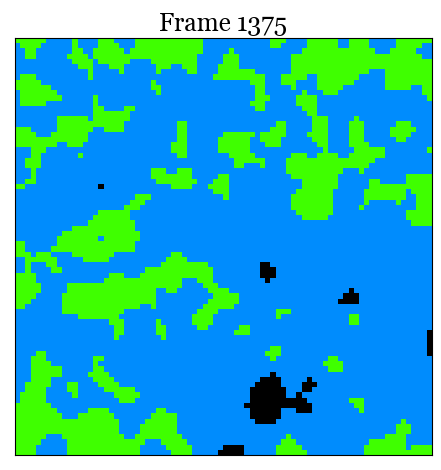

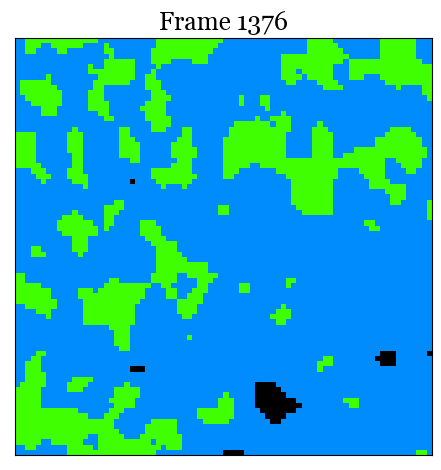

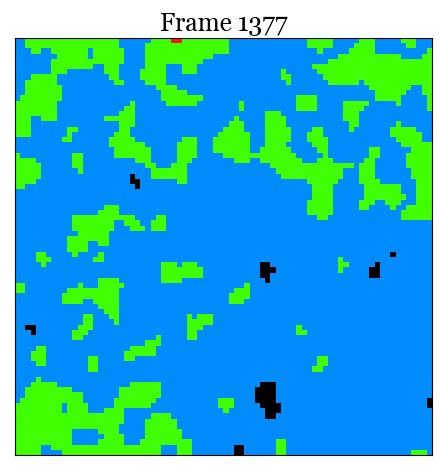

Error in callback <function flush_figures at 0x000001F07601B4C0> (for post_execute):


KeyboardInterrupt: 

In [29]:
matplotlib.rcParams['font.family'] = "sans-serif"

for frame_num in tqdm(range(space_data3.shape[0])):
    data = mask[frame_num, :, :]
    if np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1., 2., 3.])):
        colors = ['#000000', '#008cfd', '#3FFF00', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1., 2.])):
        colors = ['#000000', '#008cfd', '#3FFF00']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1., 3.])):
        colors = ['#000000', '#008cfd', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([1., 2., 3.])):
        colors = ['#008cfd', '#3FFF00', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1.])):
        colors = ['#000000', '#008cfd']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 2.])):
        colors = ['#000000', '#3FFF00']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([1., 2.])):
        colors = ['#008cfd', '#3FFF00']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0.])):
        colors = ['#000000']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([1.])):
        colors = ['#008cfd']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([2.])):
        colors = ['#3FFF00']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([3.])):
        colors = ['#ff1203']

    fig, ax = plt.subplots(1)
    # ax.imshow(img_data[:, :], cmap='gray') # background
    ax.imshow(data, cmap=matplotlib.colors.ListedColormap(colors)) #, alpha=0.4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Frame {frame_num+front_frame_num}', fontname='Georgia', fontsize=18)
    plt.tight_layout()
    plt.savefig(fig_dir + f'\\Results_{data_type}\\{frame_num+front_frame_num}.png', bbox_inches='tight')
    
plt.close()

- Make a video clip of generated masks

In [30]:
img_array_lst = []
for frame_num in tqdm(range(space_data3.shape[0])):
    img = cv.imread(fig_dir + f'\\Results_{data_type}\\{frame_num+front_frame_num}.png')
    h, w, _ = img.shape
    assert h == 470 and w == 441
    size = (w, h)
    img_array_lst.append(img)

out = cv.VideoWriter(fig_dir + f'\\{data_type}.mp4', cv.VideoWriter_fourcc(*'mp4v'), 15, (441, 470), True)

for i in range(space_data3.shape[0]):
    out.write(img_array_lst[i])
out.release()

100%|██████████| 4000/4000 [00:12<00:00, 311.25it/s]
